<a href="https://colab.research.google.com/github/Jmqcooper1/nlp1/blob/main/NLP1_2024_Practical_2_(student_version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------
**You cannot apply any changes to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------


# Practical 2: Representing Sentences with Neural Models

In this second practical, we will train neural network models to obtain sentence representations. We can then use these sentence representations for a downstream task such as sentiment classification.

In this notebook, we will help you to develop models for your experiments. But this time, next to completing the notebook, **you are expected to write a four-page scientific report with your findings**. Please still submit the notebook together with your scientific report so that we can reproduce your experiments. (Note: if you find it useful, you can split this notebook into multiple notebooks. If you do so, keep it mind that it should be possible for your TAs to reproduce the entire content of the notebooks without having to ask for clarifications or to copy and paste functions from one sub-notebook to another.) Make sure your code corresponds to the description you give in the report; we will deduct points if this is not the case. **Make sure you run all your code before submitting the notebook, and do not leave unnecessary print statements / cells in your notebook that are not intended for the grader.**

**Important!** The main purpose of this lab is for you to learn how to answer research questions by experimenting and then writing a scientific report.
So you will be *judged by the quality of your report* but will lose points if your experiments are not reproducible.
You can find the requirements for the report at the end of this notebook.


### Data set
We will use the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/) (SST), which provides sentences, their binary tree structure, and fine-grained sentiment scores.
This dataset is different from the one we used in the first practical.
In Practical 1, a review consisted of several sentences, and we had one sentiment score for the whole review. Now, a review consists of a single sentence, and we have a sentiment score for each node in the binary tree that makes up the sentence, including the root node (i.e., we still have an overall sentiment score for the entire review). We will look at an example below.

In the first part of this practical we will only make use of the sentence tokens whereas in the second part we will also exploit the tree structure that is provided by the SST.

We will cover the following approaches:

- Bag-of-words (BOW)
- Continuous bag-of-words (CBOW)
- Deep continuous bag-of-words (Deep CBOW)
- LSTM
- Tree-LSTM


## Preparing the data

Let's first download the data set and take a look.

In [16]:
import re
import random
import time
import math
import numpy as np
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import logging
from pathlib import Path
import torch.cuda as cuda
plt.style.use('default')

In [17]:
!wget http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
!unzip trainDevTestTrees_PTB.zip

--2024-12-11 22:26:19--  http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip [following]
--2024-12-11 22:26:19--  https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 789539 (771K) [application/zip]
Saving to: ‘trainDevTestTrees_PTB.zip’

trainDevTestTrees_P 100%[===================>] 771.03K  3.38MB/s    in 0.2s    

2024-12-11 22:26:19 (3.38 MB/s) - ‘trainDevTestTrees_PTB.zip’ saved [789539/789539]

Archive:  trainDevTestTrees_PTB.zip
   creating: trees/
  inflating: trees/dev.txt           
  inflating: trees/test.txt          
  inflating: trees/train.txt         


In [18]:
# this function reads in a textfile and fixes an issue with "\\"
def filereader(path):
  with open(path, mode="r", encoding="utf-8") as f:
    for line in f:
      yield line.strip().replace("\\","")

Let's look at a data point. It is a **flattened binary tree**, with sentiment scores at every node, and words as the leaves (or *terminal nodes*).

In [19]:
s = next(filereader("trees/dev.txt"))
print(s)

(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))


In [20]:
# We can use NLTK to better visualise the tree structure of the sentence
from nltk import Tree
from nltk.treeprettyprinter import TreePrettyPrinter
tree = Tree.fromstring(s)
print(TreePrettyPrinter(tree))

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

<ipython-input-20-6ab7e95feba4>:5: DeprecationWarning: 
    Class TreePrettyPrinter has been deprecated.  Import
    `TreePrettyPrinter` using `from nltk.tree import
    TreePrettyPrinter` instead.
  print(TreePrettyPrinter(tree))


The sentiment scores range from 0 (very negative) to 5 (very positive). Again, as you can see, every node in the tree is labeled with a sentiment score. For now, we will only use the score at the **root node**, i.e., the sentiment score for the complete sentence.

In [21]:
# Let's first make a function that extracts the tokens (the leaves).

def tokens_from_treestring(s):
  """extract the tokens from a sentiment tree"""
  return re.sub(r"\([0-9] |\)", "", s).split()

# let's try it on our example tree
tokens = tokens_from_treestring(s)
print(tokens)
print(len(tokens))

['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
13


> *Warning: you could also parse a treestring using NLTK and ask it to return the leaves, but there seems to be an issue with NLTK not always correctly parsing the input, so do not rely on it.*

In [22]:
# We will also need the following function, but you can ignore this for now.
# It is explained later on.

SHIFT = 0
REDUCE = 1


def transitions_from_treestring(s):
  s = re.sub("\([0-5] ([^)]+)\)", "0", s)
  s = re.sub("\)", " )", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\)", "1", s)
  return list(map(int, s.split()))

In [23]:
# Now let's first see how large our data sets are.
for path in ("trees/train.txt", "trees/dev.txt", "trees/test.txt"):
  print("{:16s} {:4d}".format(path, sum(1 for _ in filereader(path))))

trees/train.txt  8544
trees/dev.txt    1101
trees/test.txt   2210


You can see that the number of sentences is not very large. That's probably because the data set required so much manual annotation. However, it is large enough to train a neural network on.

It will be useful to store each data example in an `Example` object,
containing everything that we may need for each data point.
It will contain the tokens, the tree, the top-level sentiment label, and
the transitions (explained later).

In [24]:
from collections import namedtuple
from nltk import Tree

# A simple way to define a class is using namedtuple.
Example = namedtuple("Example", ["tokens", "tree", "label", "transitions"])


def examplereader(path, lower=False):
  """Returns all examples in a file one by one."""
  for line in filereader(path):
    line = line.lower() if lower else line
    tokens = tokens_from_treestring(line)
    tree = Tree.fromstring(line)  # use NLTK's Tree
    label = int(line[1])
    trans = transitions_from_treestring(line)
    yield Example(tokens=tokens, tree=tree, label=label, transitions=trans)


# Let's load the data into memory.
LOWER = False  # we will keep the original casing
train_data = list(examplereader("trees/train.txt", lower=LOWER))
dev_data = list(examplereader("trees/dev.txt", lower=LOWER))
test_data = list(examplereader("trees/test.txt", lower=LOWER))

print("train", len(train_data))
print("dev", len(dev_data))
print("test", len(test_data))

train 8544
dev 1101
test 2210


Let's check out an `Example` object.

In [25]:
example = dev_data[0]
print("First example:", example)
print("First example tokens:", example.tokens)
print("First example label:",  example.label)

First example: Example(tokens=['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.'], tree=Tree('3', [Tree('2', ['It']), Tree('4', [Tree('4', [Tree('2', ["'s"]), Tree('4', [Tree('3', [Tree('2', ['a']), Tree('4', [Tree('3', ['lovely']), Tree('2', ['film'])])]), Tree('3', [Tree('2', ['with']), Tree('4', [Tree('3', [Tree('3', ['lovely']), Tree('2', ['performances'])]), Tree('2', [Tree('2', ['by']), Tree('2', [Tree('2', [Tree('2', ['Buy']), Tree('2', ['and'])]), Tree('2', ['Accorsi'])])])])])])]), Tree('2', ['.'])])]), label=3, transitions=[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])
First example tokens: ['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
First example label: 3


#### Vocabulary
A first step in most NLP tasks is collecting all the word types that appear in the data into a vocabulary, and counting the frequency of their occurrences. On the one hand, this will give us an overview of the word distribution of the data set (what are the most frequent words, how many rare words are there, ...). On the other hand, we will also use the vocabulary to map each word to a unique numeric ID, which is a more handy index than a string.

In [26]:
# Here we first define a class that can map a word to an ID (w2i)
# and back (i2w).

from collections import Counter, OrderedDict, defaultdict


class OrderedCounter(Counter, OrderedDict):
  """Counter that remembers the order elements are first seen"""
  def __repr__(self):
    return '%s(%r)' % (self.__class__.__name__,
                      OrderedDict(self))
  def __reduce__(self):
    return self.__class__, (OrderedDict(self),)


class Vocabulary:
  """A vocabulary, assigns IDs to tokens"""

  def __init__(self):
    self.freqs = OrderedCounter()
    self.w2i = {}
    self.i2w = []

  def count_token(self, t):
    self.freqs[t] += 1

  def add_token(self, t):
    self.w2i[t] = len(self.w2i)
    self.i2w.append(t)

  def build(self, min_freq=0):
    '''
    min_freq: minimum number of occurrences for a word to be included
              in the vocabulary
    '''
    self.add_token("<unk>")  # reserve 0 for <unk> (unknown words)
    self.add_token("<pad>")  # reserve 1 for <pad> (discussed later)

    tok_freq = list(self.freqs.items())
    tok_freq.sort(key=lambda x: x[1], reverse=True)
    for tok, freq in tok_freq:
      if freq >= min_freq:
        self.add_token(tok)

The vocabulary has by default an `<unk>` token and a `<pad>` token. The `<unk>` token is reserved for all words which do not appear in the training data (and for which, therefore, we cannot learn word representations). The function of the `<pad>` token will be explained later.


Let's build the vocabulary!


In [27]:
# This process should be deterministic and should have the same result
# if run multiple times on the same data set.

v = Vocabulary()
for data_set in (train_data,):
  for ex in data_set:
    for token in ex.tokens:
      v.count_token(token)

v.build()
print("Vocabulary size:", len(v.w2i))

Vocabulary size: 18280


Let's have a closer look at the properties of our vocabulary. Having a good idea of what it is like can facilitate data analysis and debugging later on.

In [28]:
# What is the ID for "century?"
v.w2i["century"]

1973

In [29]:
# What are the first 10 words in the vocabulary (based on their IDs)?
for i in range(10):
    print(v.i2w[i])

<unk>
<pad>
.
,
the
and
a
of
to
's


In [30]:
# What are the 10 most common words?
v.freqs.most_common(10)

[('.', 8024),
 (',', 7131),
 ('the', 6037),
 ('and', 4431),
 ('a', 4403),
 ('of', 4386),
 ('to', 2995),
 ("'s", 2544),
 ('is', 2536),
 ('that', 1915)]

In [31]:
# And how many words are there with frequency 1?
# (A fancy name for these is hapax legomena.)
list(v.freqs.values()).count(1)

9543

In [32]:
# Finally 20 random words from the vocabulary.
# This is a simple way to get a feeling for the data.
# You could use the `choice` function from the already imported `random` package
random.choices(v.i2w, k=20)

['wild-and-woolly',
 'Brockovich',
 'cunning',
 'dollars',
 'inhabitants',
 'shoulder',
 'filling',
 'TV-insider',
 'detail',
 'prissy',
 'invited',
 'spirit-crushing',
 'Piccoli',
 '1995',
 'limb',
 'relays',
 'verbally',
 'naughty',
 'sprightly',
 'bedfellows']

#### Sentiment label vocabulary

In [33]:
# Now let's map the sentiment labels 0-4 to a more readable form
i2t = ["very negative", "negative", "neutral", "positive", "very positive"]
print(i2t)
print(i2t[4])

['very negative', 'negative', 'neutral', 'positive', 'very positive']
very positive


In [34]:
# And let's also create the opposite mapping.
# We won't use a Vocabulary for this (although we could), since the labels
# are already numeric.
t2i = OrderedDict({p : i for p, i in zip(i2t, range(len(i2t)))})
print(t2i)
print(t2i['very positive'])

OrderedDict([('very negative', 0), ('negative', 1), ('neutral', 2), ('positive', 3), ('very positive', 4)])
4


## PyTorch

We are going to need PyTorch and Google Colab does not have it installed by default. Run the cell below to install it.

*For installing PyTorch in your own computer, follow the instructions on [pytorch.org](pytorch.org) instead. This is for Google Colab only.*

In [35]:
import torch
print("Using torch", torch.__version__) # should say 1.7.0+cu101

Using torch 2.5.1+cu121


In [36]:
# Let's also import torch.nn, a PyTorch package that
# makes building neural networks more convenient.
from torch import nn

In [37]:
# PyTorch can run on CPU or on Nvidia GPU (video card) using CUDA
# This cell selects the GPU if one is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [38]:
# Seed manually to make runs reproducible
# You need to set this again if you do multiple runs of the same model
torch.manual_seed(42)

# When running on the CuDNN backend two further options must be set for reproducibility
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# BOW

Our first model is a rather simple neural **bag-of-words (BOW) model**.
Unlike the bag-of-words model that you used in the previous lab, where we would look at the presence / frequency of words in a text, here we associate each word with a multi-dimensional vector which expresses what sentiment is conveyed by the word. In particular, our BOW vectors will be of size 5, exactly our number of sentiment classes.

To classify a sentence, we **sum** the vectors of the words in the sentence and a bias vector. Because we sum the vectors, we lose word order: that's why we call this a neural bag-of-words model.

```
this   [0.0, 0.1, 0.1, 0.1, 0.0]
movie  [0.0, 0.1, 0.1, 0.2, 0.1]
is     [0.0, 0.1, 0.0, 0.0, 0.0]
stupid [0.9, 0.5, 0.1, 0.0, 0.0]

bias   [0.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------
sum    [0.9, 0.8, 0.3, 0.3, 0.1]

argmax: 0 (very negative)
```

The **argmax** of this sum is our predicted label.

We initialize all vectors *randomly* and train them using cross-entropy loss.

#### Model class

In [39]:
class BOW(nn.Module):
  """A simple bag-of-words model"""

  def __init__(self, vocab_size, embedding_dim, vocab):
    super(BOW, self).__init__()
    self.vocab = vocab

    # this is a trainable look-up table with word embeddings
    self.embed = nn.Embedding(vocab_size, embedding_dim)

    # this is a trainable bias term
    self.bias = nn.Parameter(torch.zeros(embedding_dim), requires_grad=True)

  def forward(self, inputs):
    # this is the forward pass of the neural network
    # it applies a function to the input and returns the output

    # this looks up the embeddings for each word ID in inputs
    # the result is a sequence of word embeddings
    embeds = self.embed(inputs)

    # the output is the sum across the time dimension (1)
    # with the bias term added
    logits = embeds.sum(1) + self.bias

    return logits

In [40]:
# Let's create a model.
vocab_size = len(v.w2i)
n_classes = len(t2i)
bow_model = BOW(vocab_size, n_classes, v)
print(bow_model)

BOW(
  (embed): Embedding(18280, 5)
)


> **Hey, wait, where is the bias vector?**
> PyTorch does not print Parameters, only Modules!

> We can print it ourselves though, to check that it is there.

In [41]:

# Here we print each parameter name, shape, and if it is trainable.
def print_parameters(model):
  total = 0
  for name, p in model.named_parameters():
    total += np.prod(p.shape)
    print("{:24s} {:12s} requires_grad={}".format(name, str(list(p.shape)), p.requires_grad))
  print("\nTotal number of parameters: {}\n".format(total))


print_parameters(bow_model)

bias                     [5]          requires_grad=True
embed.weight             [18280, 5]   requires_grad=True

Total number of parameters: 91405



#### Preparing an example for input

To feed sentences to our PyTorch model, we need to convert a sequence of tokens to a sequence of IDs. The `prepare_example` function below takes care of this for us. We then use these IDs as indices for the word embedding table.

In [42]:
def prepare_example(example, vocab):
  """
  Map tokens to their IDs for a single example
  """

  # vocab returns 0 if the word is not there (i2w[0] = <unk>)
  x = [vocab.w2i.get(t, 0) for t in example.tokens]

  x = torch.LongTensor([x])
  x = x.to(device)

  y = torch.LongTensor([example.label])
  y = y.to(device)

  return x, y

In [43]:
x, y = prepare_example(dev_data[0], v)
print('x:', x)
print('y:', y)

x: tensor([[  28,    9,    6,  998,   16,   18,  998,  135,   32, 7688,    5,    0,
            2]], device='cuda:0')
y: tensor([3], device='cuda:0')


#### Evaluation
We now need to define an evaluation metric.
How many predictions do we get right? The accuracy will tell us.
Make sure that you understand this code block.


In [44]:
def simple_evaluate(model, data, prep_fn=prepare_example, **kwargs):
  """Accuracy of a model on given data set."""
  correct = 0
  total = 0
  model.eval()  # disable dropout (explained later)

  for example in data:

    # convert the example input and label to PyTorch tensors
    x, target = prep_fn(example, model.vocab)

    # forward pass without backpropagation (no_grad)
    # get the output from the neural network for input x
    with torch.no_grad():
      logits = model(x)

    # get the prediction
    prediction = logits.argmax(dim=-1)

    # add the number of correct predictions to the total correct
    correct += (prediction == target).sum().item()
    total += 1

  return correct, total, correct / float(total)

We are using accuracy as a handy evaluation metric. Please consider using [alternative metrics](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for your experiments if that makes more theoretical sense.

#### Example feed
For stochastic gradient descent (SGD) we will need a random training example for every update.
We implement this by shuffling the training data and returning examples one by one using `yield`.

Shuffling is optional so that we get to use this function to get validation and test examples, too.

In [45]:
def get_examples(data, shuffle=True, **kwargs):
  """Shuffle data set and return 1 example at a time (until nothing left)"""
  if shuffle:
    print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch
  for example in data:
    yield example

#### Exercise: Training function

Your task is now to complete the training loop below.
Before you do so, please read the section about optimisation.

**Optimisation**

As mentioned in the "Intro to PyTorch" notebook, one of the perks of using PyTorch is automatic differentiation. We will use it to train our BOW model.

We train our model by feeding it an input, performing a **forward** pass, obtaining an output prediction, and calculating a **loss** with our loss function.
After the gradients are computed in the **backward** pass, we can take a step on the surface of the loss function towards more optimal parameter settings (gradient descent).

The package we will use to do this optimisation is [torch.optim](https://pytorch.org/docs/stable/optim.html).

In [46]:
from torch import optim

Besides implementations of stochastic gradient descent (SGD), this package also implements the optimisation algorithm Adam, which we'll be using in this practical.
For the purposes of this assignment you do not need to know what Adam does besides that it uses gradient information to update our model parameters by calling:

```
optimizer.step()
```
Remember when we updated our parameters in the PyTorch tutorial in a loop?


```python
# update weights
learning_rate = 0.5
for f in net.parameters():
    # for each parameter, take a small step in the opposite dir of the gradient
    p.data = p.data - p.grad.data * learning_rate

```
The function call optimizer.step() does effectively the same thing.

*(If you want to know more about optimisation algorithms using gradient information, [this blog](http://ruder.io/optimizing-gradient-descent/.) gives a nice intuitive overview.)*

In [47]:
def validate(model, data, eval_fn, batch_fn, prep_fn, eval_batch_size):
    """Helper function to evaluate the model."""
    model.eval()
    with torch.no_grad():
        val_loss, total, accuracy = eval_fn(
            model, data,
            batch_size=eval_batch_size,
            batch_fn=batch_fn,
            prep_fn=prep_fn
        )
    return val_loss, accuracy

def save_checkpoint(model, optimizer, path, best_eval, best_iter, iter_i, extra_data=None):
    """Helper function to save model checkpoint."""
    ckpt = {
        "state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "best_eval": best_eval,
        "best_iter": best_iter,
        "current_iter": iter_i
    }
    if extra_data:
        ckpt.update(extra_data)
    torch.save(ckpt, path)

In [48]:
def train_model(model, optimizer,
                num_iterations=10000,    # Original iteration limit
                print_every=500,
                eval_every=500,
                batch_fn=get_examples,
                prep_fn=prepare_example,
                eval_fn=simple_evaluate,
                batch_size=32,
                eval_batch_size=128,
                patience=5,              # Early stopping patience
                scheduler=None,          # Learning rate scheduler
                max_norm=1.0,           # Gradient clipping
                warmup_steps=100,       # Learning rate warmup
                accumulation_steps=4,    # Gradient accumulation
                checkpoint_every=1000):  # Periodic checkpoint saving
    """Train a model with optimized training process.

    Args:
        model: The neural network model
        optimizer: The optimizer (e.g., Adam)
        num_iterations: Maximum number of training iterations
        print_every: Steps between printing progress
        eval_every: Steps between evaluations
        batch_fn: Function to get batches of data
        prep_fn: Function to prepare examples
        eval_fn: Function to evaluate model
        batch_size: Training batch size
        eval_batch_size: Evaluation batch size
        patience: Early stopping patience
        scheduler: Learning rate scheduler
        max_norm: Maximum gradient norm
        warmup_steps: Number of warmup steps
        accumulation_steps: Number of steps for gradient accumulation
        checkpoint_every: Steps between checkpoints
    """
    try:
        # Initialize tracking variables
        iter_i = 0
        train_loss = 0.
        print_num = 0
        start = time.time()
        criterion = nn.CrossEntropyLoss()
        best_eval = 0.
        best_iter = 0
        no_improvement = 0

        # Store metrics for plotting
        losses = []
        accuracies = []
        val_losses = []
        lrs = []

        # Create checkpoint directory
        checkpoint_dir = Path("checkpoints")
        checkpoint_dir.mkdir(exist_ok=True)

        if eval_batch_size is None:
            eval_batch_size = batch_size

        # Get initial learning rate
        initial_lr = optimizer.param_groups[0]['lr']

        # Main training loop
        while True:  # when we run out of examples, shuffle and continue
            # Create progress bar for this epoch
            pbar = tqdm(batch_fn(train_data, batch_size=batch_size),
                       desc=f'Iteration {iter_i}')

            for batch_idx, batch in enumerate(pbar):
                # forward pass
                model.train()
                x, targets = prep_fn(batch, model.vocab)

                # Move to GPU if available
                if isinstance(x, tuple):
                    words, transitions = x
                    words = words.to(next(model.parameters()).device)
                    x = (words, transitions)  # Reconstruct tuple with device-moved words
                else:
                    x = x.to(next(model.parameters()).device)
                targets = targets.to(next(model.parameters()).device)

                logits = model(x)

                # compute cross-entropy loss
                loss = criterion(logits.view([targets.size(0), -1]), targets.view(-1))
                # Scale loss for gradient accumulation
                loss = loss / accumulation_steps
                train_loss += loss.item() * accumulation_steps

                # backward pass
                loss.backward()

                # Gradient accumulation
                if (batch_idx + 1) % accumulation_steps == 0:
                    # Clip gradients
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

                    # Learning rate warmup
                    if iter_i < warmup_steps:
                        lr_scale = min(1., float(iter_i + 1) / warmup_steps)
                        for pg in optimizer.param_groups:
                            pg['lr'] = lr_scale * initial_lr

                    # Update weights
                    optimizer.step()
                    optimizer.zero_grad()

                    # Track learning rate
                    lrs.append(optimizer.param_groups[0]['lr'])

                print_num += 1
                iter_i += 1

                # Update progress bar
                pbar.set_description(
                    f'Iter {iter_i}: loss={loss.item():.4f}, '
                    f'lr={optimizer.param_groups[0]["lr"]:.6f}'
                )

                # print info
                if iter_i % print_every == 0:
                    avg_loss = train_loss / print_num
                    print(f"\nIter {iter_i}: loss={avg_loss:.4f}, "
                          f"time={time.time()-start:.2f}s")
                    losses.append(avg_loss)
                    print_num = 0
                    train_loss = 0.

                # evaluate
                if iter_i % eval_every == 0:
                    # Validate model
                    val_loss, accuracy = validate(
                        model, dev_data, eval_fn, batch_fn, prep_fn, eval_batch_size
                    )

                    accuracies.append(accuracy)
                    val_losses.append(val_loss)
                    print(f"iter {iter_i}: dev acc={accuracy:.4f}, val_loss={val_loss:.4f}")

                    # save best model parameters
                    if accuracy > best_eval:
                        print("new highscore")
                        best_eval = accuracy
                        best_iter = iter_i
                        no_improvement = 0

                        # Save best model
                        save_checkpoint(
                            model, optimizer,
                            f"{checkpoint_dir}/{model.__class__.__name__}_best.pt",
                            best_eval, best_iter, iter_i
                        )
                    else:
                        no_improvement += 1

                    # Learning rate scheduling
                    if scheduler is not None:
                        scheduler.step(accuracy)

                    # Early stopping check
                    if no_improvement >= patience:
                        print(f"Early stopping triggered after {iter_i} iterations")
                        break

                # Periodic checkpoint saving
                if iter_i % checkpoint_every == 0:
                    save_checkpoint(
                        model, optimizer,
                        f"{checkpoint_dir}/{model.__class__.__name__}_{iter_i}.pt",
                        best_eval, best_iter, iter_i
                    )

                # Clear CUDA cache periodically
                if iter_i % 1000 == 0 and torch.cuda.is_available():
                    torch.cuda.empty_cache()

                # Check if we've hit iteration limit
                if iter_i >= num_iterations:
                    print("Reached maximum iterations")
                    break

            # Break outer loop if early stopping or max iterations
            if no_improvement >= patience or iter_i >= num_iterations:
                break

        # Final evaluation
        print("\nTraining finished! Loading best model...")
        best_model_path = f"{checkpoint_dir}/{model.__class__.__name__}_best.pt"
        ckpt = torch.load(best_model_path)
        model.load_state_dict(ckpt["state_dict"])

        # Evaluate on all sets
        model.eval()
        with torch.no_grad():
            train_loss, _, train_acc = eval_fn(
                model, train_data, batch_size=eval_batch_size,
                batch_fn=batch_fn, prep_fn=prep_fn)
            dev_loss, _, dev_acc = eval_fn(
                model, dev_data, batch_size=eval_batch_size,
                batch_fn=batch_fn, prep_fn=prep_fn)
            test_loss, _, test_acc = eval_fn(
                model, test_data, batch_size=eval_batch_size,
                batch_fn=batch_fn, prep_fn=prep_fn)

        print(f"Best model (iter {best_iter}): "
              f"train acc={train_acc:.4f}, dev acc={dev_acc:.4f}, "
              f"test acc={test_acc:.4f}")

        return {
            'losses': losses,
            'accuracies': accuracies,
            'val_losses': val_losses,
            'learning_rates': lrs,
            'best_accuracy': best_eval,
            'best_iteration': best_iter,
            'final_metrics': {
                'train_acc': train_acc,
                'dev_acc': dev_acc,
                'test_acc': test_acc,
                'train_loss': train_loss,
                'dev_loss': dev_loss,
                'test_loss': test_loss
            }
        }

    except Exception as e:
        print(f"Error during training: {str(e)}")
        # Save emergency checkpoint
        save_checkpoint(
            model, optimizer,
            f"{checkpoint_dir}/{model.__class__.__name__}_emergency.pt",
            best_eval, best_iter, iter_i,
            {'error': str(e)}
        )
        raise e

### Training the BOW model

In [49]:
def train_with_multiple_seeds(model_class, model_args, seeds=[42, 123, 456],
                            pretrained_vectors=None, freeze_embeddings=True,
                            **train_kwargs):
    """
    Train a model multiple times with different seeds.
    Handles both regular and pre-trained models.

    Args:
        model_class: The class of the model
        model_args: Dictionary of arguments for model initialization
        seeds: List of random seeds to use
        pretrained_vectors: Optional pre-trained word vectors
        freeze_embeddings: Whether to freeze embeddings (if pre-trained)
        **train_kwargs: Arguments for train_model function
    """
    all_stats = []

    print(f"Training with seeds: {seeds}")
    if pretrained_vectors is not None:
        print(f"Using pre-trained embeddings ({'frozen' if freeze_embeddings else 'trainable'})")


    for seed in seeds:
        print(f"\nTraining with seed {seed}")
        # Set seeds for reproducibility
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        # Initialize new model
        model = model_class(**model_args)

        # Initialize pre-trained embeddings if provided
        if pretrained_vectors is not None:
            with torch.no_grad():
                model.embed.weight.data.copy_(torch.from_numpy(pretrained_vectors))
                model.embed.weight.requires_grad = not freeze_embeddings

        model = model.to(device)

        # Initialize optimizer and scheduler
        optimizer = optim.AdamW(
            model.parameters(),
            lr=2e-4,
            weight_decay=0.01
        )

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',
            factor=0.5,
            patience=2,
            min_lr=1e-6
        )

        # Train model
        stats = train_model(
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            **train_kwargs
        )

        all_stats.append(stats)

    # Calculate average and std dev
    test_accuracies = [s['final_metrics']['test_acc'] for s in all_stats]
    mean_test_acc = np.mean(test_accuracies)
    std_test_acc = np.std(test_accuracies)

    combined_stats = all_stats[0].copy()
    combined_stats['mean_test_acc'] = mean_test_acc
    combined_stats['std_test_acc'] = std_test_acc
    combined_stats['individual_runs'] = {
        f'seed_{seed}': stats for seed, stats in zip(seeds, all_stats)
    }

    print(f"\nFinal Results across {len(seeds)} seeds:")
    print(f"Test Accuracy: {mean_test_acc:.4f} ± {std_test_acc:.4f}")

    return combined_stats

In [50]:
def plot_model_comparison(training_stats_list, model_names, figsize_single=(15, 8)):
    """Enhanced comparison plots with separate, larger figures."""
    # Generate colors from colormap
    colors = plt.cm.rainbow(np.linspace(0, 1, len(model_names)))

    # Plot 1: Training Loss Comparison
    plt.figure(figsize=figsize_single)
    for i, (stats, name) in enumerate(zip(training_stats_list, model_names)):
        plt.plot(stats['losses'], color=colors[i], linestyle='-', label=f'{name} Train')
        if 'val_losses' in stats:
            plt.plot(stats['val_losses'], color=colors[i], linestyle='--', label=f'{name} Val')
    plt.title('Loss Comparison')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: Accuracy Comparison with std dev bands
    plt.figure(figsize=figsize_single)
    for i, (stats, name) in enumerate(zip(training_stats_list, model_names)):
        runs = list(stats['individual_runs'].values())
        min_len = min(len(run['accuracies']) for run in runs)
        all_accs = np.array([run['accuracies'][:min_len] for run in runs])

        mean_acc = np.mean(all_accs, axis=0)
        std_acc = np.std(all_accs, axis=0)

        x = np.arange(len(mean_acc))
        plt.plot(x, mean_acc, color=colors[i], label=name)
        plt.fill_between(x, mean_acc-std_acc, mean_acc+std_acc,
                        color=colors[i], alpha=0.2)
    plt.title('Validation Accuracy (with ±1 std)')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 3: Learning Rate Comparison
    plt.figure(figsize=figsize_single)
    for i, (stats, name) in enumerate(zip(training_stats_list, model_names)):
        if 'learning_rates' in stats:
            plt.plot(stats['learning_rates'], color=colors[i], label=name)
    plt.title('Learning Rate Evolution')
    plt.xlabel('Training Step')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 4: Final Performance Bar Plot
    plt.figure(figsize=figsize_single)
    splits = ['Train', 'Dev', 'Test']
    x = np.arange(len(splits))
    width = 0.8 / len(model_names)

    for i, (stats, name) in enumerate(zip(training_stats_list, model_names)):
        position = x + (i * width) - (width * len(model_names)/2) + width/2

        run_metrics = list(stats['individual_runs'].values())
        run_accs = np.array([[run['final_metrics'][f'{split.lower()}_acc']
                             for split in splits]
                            for run in run_metrics])

        means = np.mean(run_accs, axis=0)
        stds = np.std(run_accs, axis=0)

        plt.bar(position, means, width, label=name, color=colors[i])
        plt.errorbar(position, means, yerr=stds, fmt='none',
                    color='black', capsize=5)

        for j, (mean, std) in enumerate(zip(means, stds)):
            plt.text(position[j], mean, f'{mean:.3f}\n±{std:.3f}',
                    ha='center', va='bottom', rotation=90)

    plt.title('Final Performance (mean ± std)')
    plt.ylabel('Accuracy')
    plt.xticks(x, splits)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # Plot 5: Smoothed Accuracy Comparison
    plt.figure(figsize=figsize_single)
    window = 5
    for i, (stats, name) in enumerate(zip(training_stats_list, model_names)):
        runs = list(stats['individual_runs'].values())
        min_len = min(len(run['accuracies']) for run in runs)
        all_accs = np.array([pd.Series(run['accuracies'][:min_len]).rolling(window).mean()
                            for run in runs])

        mean_acc = np.nanmean(all_accs, axis=0)
        std_acc = np.nanstd(all_accs, axis=0)

        plt.plot(mean_acc, color=colors[i], label=name)
        plt.fill_between(range(len(mean_acc)),
                        mean_acc-std_acc, mean_acc+std_acc,
                        color=colors[i], alpha=0.2)

    plt.title('Smoothed Validation Accuracy (with ±1 std)')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\nDetailed Model Comparison:")
    for name, stats in zip(model_names, training_stats_list):
        print(f"\n{name}:")
        print(f"Test Accuracy: {stats['mean_test_acc']:.4f} ± {stats['std_test_acc']:.4f}")
        print("Individual run test accuracies:",
              [f"{run['final_metrics']['test_acc']:.4f}"
               for run in stats['individual_runs'].values()])

def plot_smoothed_comparison(training_stats_list, model_names, window=5):
    """Enhanced smoothed comparison with confidence bands."""
    plt.figure(figsize=(15, 6))

    for i, (stats, name) in enumerate(zip(training_stats_list, model_names)):
        runs = stats['individual_runs'].values()
        all_accs = np.array([pd.Series(run['accuracies']).rolling(window).mean()
                            for run in runs])

        mean_acc = np.nanmean(all_accs, axis=0)
        std_acc = np.nanstd(all_accs, axis=0)

        plt.plot(mean_acc, label=name)
        plt.fill_between(range(len(mean_acc)),
                        mean_acc-std_acc, mean_acc+std_acc,
                        alpha=0.2)

    plt.title('Smoothed Validation Accuracy (with ±1 std)')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

In [51]:
# If everything is in place we can now train our first model!
bow_args = {
    'vocab_size': len(v.w2i),
    'embedding_dim': 5,
    'vocab': v
}

bow_training_stats = train_with_multiple_seeds(
    model_class=BOW,
    model_args=bow_args,
    seeds=[42, 123, 456],
    num_iterations=30000,
    print_every=500,
    eval_every=500,
    batch_size=32,
    eval_batch_size=128,
    patience=5,
    max_norm=1.0,
    warmup_steps=100,
    accumulation_steps=4,
    checkpoint_every=1000
)

Training with seeds: [42, 123, 456]

Training with seed 42


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.1859, lr=0.000200: : 478it [00:03, 258.84it/s]


Iter 500: loss=5.3366, time=3.09s


Iter 551: loss=1.0326, lr=0.000200: : 531it [00:03, 137.75it/s]

iter 500: dev acc=0.1916, val_loss=211.0000
new highscore


Iter 1000: loss=0.9604, lr=0.000200: : 981it [00:05, 269.92it/s]


Iter 1000: loss=5.9400, time=5.40s


Iter 1047: loss=1.0207, lr=0.000200: : 1034it [00:05, 144.72it/s]

iter 1000: dev acc=0.1907, val_loss=210.0000


Iter 1500: loss=2.0584, lr=0.000200: : 1484it [00:07, 215.33it/s]


Iter 1500: loss=5.3728, time=7.93s


Iter 1547: loss=0.1884, lr=0.000200: : 1531it [00:08, 116.45it/s]

iter 1500: dev acc=0.1926, val_loss=212.0000
new highscore


Iter 2000: loss=1.4435, lr=0.000200: : 1990it [00:10, 201.63it/s]


Iter 2000: loss=5.2222, time=10.64s


Iter 2047: loss=0.8431, lr=0.000200: : 2037it [00:11, 109.98it/s]

iter 2000: dev acc=0.1926, val_loss=212.0000


Iter 2500: loss=1.3199, lr=0.000200: : 2474it [00:13, 235.41it/s]


Iter 2500: loss=4.9985, time=13.41s


Iter 2555: loss=3.5827, lr=0.000200: : 2528it [00:14, 140.21it/s]

iter 2500: dev acc=0.1907, val_loss=210.0000


Iter 3000: loss=0.5089, lr=0.000200: : 2976it [00:15, 280.26it/s]


Iter 3000: loss=5.4326, time=15.65s


Iter 3055: loss=0.0132, lr=0.000100: : 3033it [00:16, 158.05it/s]

iter 3000: dev acc=0.1898, val_loss=209.0000


Iter 3500: loss=1.8520, lr=0.000100: : 3490it [00:17, 274.60it/s]


Iter 3500: loss=5.0877, time=17.84s


Iter 3557: loss=1.0020, lr=0.000100: : 3548it [00:18, 160.25it/s]

iter 3500: dev acc=0.1907, val_loss=210.0000


Iter 4000: loss=1.2302, lr=0.000100: : 3992it [00:19, 281.98it/s]


Iter 4000: loss=5.0496, time=19.97s


Iter 4000: loss=1.2302, lr=0.000100: : 3999it [00:20, 196.64it/s]

iter 4000: dev acc=0.1898, val_loss=209.0000
Early stopping triggered after 4000 iterations

Training finished! Loading best model...



<ipython-input-48-7409b8f75348>:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 1500): train acc=0.2068, dev acc=0.1926, test acc=0.2059

Training with seed 123


Iter 64: loss=0.0000, lr=0.000128: : 29it [00:00, 285.67it/s]

Shuffling training data


Iter 500: loss=4.6042, lr=0.000200: : 481it [00:02, 205.19it/s]


Iter 500: loss=5.4440, time=2.15s


Iter 547: loss=0.7320, lr=0.000200: : 525it [00:02, 119.10it/s]

iter 500: dev acc=0.1780, val_loss=196.0000
new highscore


Iter 1000: loss=2.8833, lr=0.000200: : 988it [00:04, 228.60it/s]


Iter 1000: loss=5.2880, time=4.74s


Iter 1049: loss=0.2495, lr=0.000200: : 1037it [00:05, 116.24it/s]

iter 1000: dev acc=0.1835, val_loss=202.0000
new highscore


Iter 1500: loss=2.5628, lr=0.000200: : 1480it [00:06, 232.29it/s]


Iter 1500: loss=5.2866, time=7.01s


Iter 1560: loss=0.0681, lr=0.000200: : 1540it [00:07, 140.54it/s]

iter 1500: dev acc=0.1817, val_loss=200.0000


Iter 2000: loss=1.3152, lr=0.000200: : 1984it [00:09, 223.57it/s]


Iter 2000: loss=5.5802, time=9.53s


Iter 2048: loss=1.1220, lr=0.000200: : 2036it [00:10, 101.72it/s]

iter 2000: dev acc=0.1871, val_loss=206.0000
new highscore


Iter 2500: loss=2.7341, lr=0.000200: : 2488it [00:13, 239.00it/s]


Iter 2500: loss=4.9431, time=13.05s


Iter 2552: loss=1.7636, lr=0.000200: : 2539it [00:13, 141.75it/s]

iter 2500: dev acc=0.1871, val_loss=206.0000


Iter 3000: loss=0.0212, lr=0.000200: : 2985it [00:15, 269.68it/s]


Iter 3000: loss=5.1916, time=15.29s


Iter 3051: loss=0.5821, lr=0.000200: : 3039it [00:15, 148.99it/s]

iter 3000: dev acc=0.1871, val_loss=206.0000


Iter 3500: loss=4.6856, lr=0.000200: : 3479it [00:17, 251.51it/s]


Iter 3500: loss=5.3068, time=17.59s


Iter 3562: loss=0.7960, lr=0.000100: : 3534it [00:18, 136.70it/s]

iter 3500: dev acc=0.1871, val_loss=206.0000


Iter 4000: loss=1.7796, lr=0.000100: : 3983it [00:20, 232.27it/s]


Iter 4000: loss=5.1690, time=20.09s


Iter 4046: loss=0.9066, lr=0.000100: : 4032it [00:20, 104.11it/s]

iter 4000: dev acc=0.1880, val_loss=207.0000
new highscore


Iter 4500: loss=0.8182, lr=0.000100: : 4493it [00:23, 187.06it/s]


Iter 4500: loss=5.2908, time=23.06s


Iter 4555: loss=1.1928, lr=0.000100: : 4545it [00:23, 114.93it/s]

iter 4500: dev acc=0.1880, val_loss=207.0000


Iter 5000: loss=3.8049, lr=0.000100: : 4997it [00:25, 258.26it/s]


Iter 5000: loss=5.4912, time=25.67s


Iter 5057: loss=1.7367, lr=0.000100: : 5056it [00:26, 134.34it/s]

iter 5000: dev acc=0.1889, val_loss=208.0000
new highscore


Iter 5500: loss=0.4028, lr=0.000100: : 5489it [00:27, 297.88it/s]


Iter 5500: loss=5.2442, time=27.92s


Iter 5551: loss=5.6143, lr=0.000100: : 5548it [00:28, 152.20it/s]

iter 5500: dev acc=0.1889, val_loss=208.0000


Iter 6000: loss=1.3866, lr=0.000100: : 5996it [00:30, 267.93it/s]


Iter 6000: loss=5.2378, time=30.20s


Iter 6047: loss=0.0005, lr=0.000100: : 6024it [00:30, 128.93it/s]

iter 6000: dev acc=0.1880, val_loss=207.0000


Iter 6500: loss=3.0095, lr=0.000100: : 6484it [00:32, 269.90it/s]


Iter 6500: loss=5.1169, time=32.43s


Iter 6554: loss=1.5249, lr=0.000050: : 6538it [00:32, 153.94it/s]

iter 6500: dev acc=0.1889, val_loss=208.0000


Iter 7000: loss=0.1446, lr=0.000050: : 6988it [00:34, 284.02it/s]


Iter 7000: loss=5.2302, time=34.64s


Iter 7052: loss=0.5885, lr=0.000050: : 7044it [00:35, 150.66it/s]

iter 7000: dev acc=0.1889, val_loss=208.0000


Iter 7500: loss=2.0166, lr=0.000050: : 7499it [00:37, 230.87it/s]


Iter 7500: loss=5.0269, time=37.07s


Iter 7500: loss=2.0166, lr=0.000050: : 7499it [00:37, 199.77it/s]

iter 7500: dev acc=0.1889, val_loss=208.0000
Early stopping triggered after 7500 iterations

Training finished! Loading best model...


Best model (iter 5000): train acc=0.2015, dev acc=0.1889, test acc=0.1864

Training with seed 456


Iter 60: loss=0.0006, lr=0.000120: : 31it [00:00, 304.58it/s]

Shuffling training data


Iter 500: loss=1.6561, lr=0.000200: : 486it [00:01, 262.49it/s]


Iter 500: loss=5.5436, time=1.88s


Iter 548: loss=2.0173, lr=0.000200: : 537it [00:02, 145.84it/s]

iter 500: dev acc=0.1807, val_loss=199.0000
new highscore


Iter 1000: loss=1.7718, lr=0.000200: : 980it [00:04, 252.10it/s]


Iter 1000: loss=5.2575, time=4.18s


Iter 1054: loss=1.2322, lr=0.000200: : 1034it [00:04, 145.32it/s]

iter 1000: dev acc=0.1844, val_loss=203.0000
new highscore


Iter 1500: loss=0.9496, lr=0.000200: : 1488it [00:06, 278.19it/s]


Iter 1500: loss=5.3413, time=6.43s


Iter 1552: loss=0.5044, lr=0.000200: : 1545it [00:07, 151.94it/s]

iter 1500: dev acc=0.1853, val_loss=204.0000
new highscore


Iter 2000: loss=0.6601, lr=0.000200: : 1998it [00:08, 255.84it/s]


Iter 2000: loss=5.4492, time=8.74s


Iter 2053: loss=3.3267, lr=0.000200: : 2051it [00:09, 148.99it/s]

iter 2000: dev acc=0.1835, val_loss=202.0000


Iter 2500: loss=2.1538, lr=0.000200: : 2491it [00:11, 245.47it/s]


Iter 2500: loss=5.1892, time=11.25s


Iter 2557: loss=1.1872, lr=0.000200: : 2550it [00:12, 115.44it/s]

iter 2500: dev acc=0.1835, val_loss=202.0000


Iter 3000: loss=0.5441, lr=0.000200: : 2993it [00:14, 208.07it/s]


Iter 3000: loss=5.5168, time=14.17s


Iter 3044: loss=2.2095, lr=0.000100: : 3038it [00:15, 89.98it/s]

iter 3000: dev acc=0.1835, val_loss=202.0000


Iter 3500: loss=1.0802, lr=0.000100: : 3498it [00:17, 224.20it/s]


Iter 3500: loss=5.1859, time=17.10s


Iter 3544: loss=0.4737, lr=0.000100: : 3542it [00:17, 102.46it/s]

iter 3500: dev acc=0.1844, val_loss=203.0000


Iter 4000: loss=0.0031, lr=0.000100: : 3978it [00:19, 274.65it/s]


Iter 4000: loss=4.9639, time=19.77s


Iter 4000: loss=0.0031, lr=0.000100: : 3999it [00:20, 198.54it/s]

iter 4000: dev acc=0.1853, val_loss=204.0000
Early stopping triggered after 4000 iterations

Training finished! Loading best model...


Best model (iter 1500): train acc=0.1948, dev acc=0.1853, test acc=0.2036

Final Results across 3 seeds:
Test Accuracy: 0.1986 ± 0.0087


Please note that we set the number of iterations to 30K as an indicative value, after which we simply stop training without checking for convergence. You should choose an appropriate number of iterations and motivate your decision. **This holds for all pre-set numbers of iteration in the following code blocks.**

# CBOW

We now continue with a **continuous bag-of-words (CBOW)** model. (*This is not the same as the word2vec CBOW model!*)

It is similar to the BOW model above, but now embeddings can have a dimension of *arbitrary size*.
This means that we can choose a higher dimensionality and learn more aspects of each word. We will still sum word vectors to get a sentence representation, but now the size of the resulting vector will no longer correspond to the number of sentiment classes.

So to turn the size of our summed vector into the number of output classes, we can *learn* a parameter matrix $W$ and multiply it by the sum vector $x$: $$Wx$$
If the size of $x$ is `d x 1`, we can set $W$ to be `5 x d`, so that the output of the matrix multiplication will be the of the desired size, `5 x 1`. Then, just like for the BOW model, we can obtain a prediction using the argmax function.

## Exercise: implement and train the CBOW model

Write a class `CBOW` that:

- has word embeddings with size 300
- sums the word vectors for the input words (just like in `BOW`)
- projects the resulting vector down to 5 units using a linear layer and a bias term (check out `nn.Linear`)

Train your CBOW model and plot the validation accuracy and training loss over time.

In [52]:
# YOUR CODE HERE
class CBOW(nn.Module):
    def __init__(self, vocab_size, num_classes, vocab, embedding_dim=300):
        super(CBOW, self).__init__()
        self.vocab = vocab

        self.embed = nn.Embedding(vocab_size, embedding_dim)

        self.linear = nn.Linear(embedding_dim, num_classes, bias=True)

    def forward(self, inputs):
        embeds = self.embed(inputs)
        summed = embeds.sum(1)

        logits = self.linear(summed)

        return logits

In [53]:
cbow_args = {
    'vocab_size': len(v.w2i),
    'num_classes': 5,
    'vocab': v,
    'embedding_dim': 300,
}

cbow_training_stats = train_with_multiple_seeds(
    model_class=CBOW,
    model_args=cbow_args,
    seeds=[42, 123, 456],
    num_iterations=30000,
    print_every=500,
    eval_every=500,
    batch_size=32,
    eval_batch_size=128,
    patience=5,
    max_norm=1.0,
    warmup_steps=100,
    accumulation_steps=4,
    checkpoint_every=1000
)

Training with seeds: [42, 123, 456]

Training with seed 42


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=1.6543, lr=0.000200: : 490it [00:02, 223.32it/s]


Iter 500: loss=3.1356, time=2.34s
iter 500: dev acc=0.2144, val_loss=236.0000
new highscore


Iter 1000: loss=0.2779, lr=0.000200: : 982it [00:05, 202.26it/s]


Iter 1000: loss=2.8149, time=5.37s
iter 1000: dev acc=0.2198, val_loss=242.0000
new highscore


Iter 1500: loss=0.4490, lr=0.000200: : 1493it [00:08, 187.52it/s]


Iter 1500: loss=2.5732, time=8.82s
iter 1500: dev acc=0.2298, val_loss=253.0000
new highscore


Iter 2000: loss=0.3676, lr=0.000200: : 1995it [00:12, 226.39it/s]


Iter 2000: loss=2.5970, time=12.06s
iter 2000: dev acc=0.2298, val_loss=253.0000


Iter 2500: loss=0.3033, lr=0.000200: : 2494it [00:14, 224.13it/s]


Iter 2500: loss=2.3783, time=14.88s


Iter 2505: loss=0.4158, lr=0.000200: : 2494it [00:15, 224.13it/s]

iter 2500: dev acc=0.2461, val_loss=271.0000
new highscore


Iter 3000: loss=0.5382, lr=0.000200: : 2994it [00:17, 227.41it/s]


Iter 3000: loss=2.4259, time=17.56s
iter 3000: dev acc=0.2343, val_loss=258.0000


Iter 3500: loss=0.1864, lr=0.000200: : 3488it [00:20, 222.89it/s]


Iter 3500: loss=2.1445, time=20.43s


Iter 3545: loss=0.1952, lr=0.000200: : 3533it [00:21, 121.38it/s]

iter 3500: dev acc=0.2125, val_loss=234.0000


Iter 4000: loss=0.3533, lr=0.000200: : 3988it [00:23, 187.41it/s]


Iter 4000: loss=2.1028, time=23.27s
iter 4000: dev acc=0.2271, val_loss=250.0000


Iter 4500: loss=0.6932, lr=0.000100: : 4494it [00:26, 203.35it/s]


Iter 4500: loss=2.1992, time=26.41s


Iter 4543: loss=0.6948, lr=0.000100: : 4538it [00:27, 97.66it/s]

iter 4500: dev acc=0.2325, val_loss=256.0000


Iter 5000: loss=0.1626, lr=0.000100: : 4982it [00:29, 218.53it/s]


Iter 5000: loss=2.1091, time=29.29s


Iter 5000: loss=0.1626, lr=0.000100: : 4999it [00:29, 168.24it/s]

iter 5000: dev acc=0.2416, val_loss=266.0000
Early stopping triggered after 5000 iterations

Training finished! Loading best model...



<ipython-input-48-7409b8f75348>:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 2500): train acc=0.2719, dev acc=0.2461, test acc=0.2421

Training with seed 123


Iter 37: loss=0.4824, lr=0.000072: : 24it [00:00, 230.25it/s]

Shuffling training data


Iter 500: loss=0.8351, lr=0.000200: : 498it [00:02, 214.01it/s]


Iter 500: loss=3.0890, time=2.25s


Iter 503: loss=0.0738, lr=0.000200: : 498it [00:02, 214.01it/s]

iter 500: dev acc=0.2053, val_loss=226.0000
new highscore


Iter 1000: loss=0.8653, lr=0.000200: : 983it [00:05, 206.87it/s]


Iter 1000: loss=2.7805, time=5.15s
iter 1000: dev acc=0.2107, val_loss=232.0000
new highscore


Iter 1500: loss=0.7497, lr=0.000200: : 1493it [00:08, 208.79it/s]


Iter 1500: loss=2.7458, time=8.38s
iter 1500: dev acc=0.2198, val_loss=242.0000
new highscore


Iter 2000: loss=0.6325, lr=0.000200: : 1992it [00:11, 212.86it/s]


Iter 2000: loss=2.5964, time=11.71s


Iter 2007: loss=1.4389, lr=0.000200: : 1992it [00:12, 212.86it/s]

iter 2000: dev acc=0.2089, val_loss=230.0000


Iter 2500: loss=0.8953, lr=0.000200: : 2496it [00:14, 220.90it/s]


Iter 2500: loss=2.3917, time=14.55s


Iter 2543: loss=0.1719, lr=0.000200: : 2541it [00:15, 117.21it/s]

iter 2500: dev acc=0.2153, val_loss=237.0000


Iter 3000: loss=0.3383, lr=0.000200: : 2997it [00:17, 218.43it/s]


Iter 3000: loss=2.3591, time=17.26s


Iter 3003: loss=0.3771, lr=0.000100: : 2997it [00:17, 218.43it/s]

iter 3000: dev acc=0.2198, val_loss=242.0000


Iter 3500: loss=0.2052, lr=0.000100: : 3489it [00:20, 220.33it/s]


Iter 3500: loss=2.2411, time=20.08s


Iter 3545: loss=0.5502, lr=0.000100: : 3536it [00:20, 121.07it/s]

iter 3500: dev acc=0.2198, val_loss=242.0000


Iter 4000: loss=1.1829, lr=0.000100: : 3990it [00:22, 206.74it/s]


Iter 4000: loss=2.2757, time=22.87s


Iter 4000: loss=1.1829, lr=0.000100: : 3999it [00:23, 171.06it/s]

iter 4000: dev acc=0.2198, val_loss=242.0000
Early stopping triggered after 4000 iterations

Training finished! Loading best model...


Best model (iter 1500): train acc=0.2429, dev acc=0.2198, test acc=0.2059

Training with seed 456


Iter 38: loss=0.2577, lr=0.000072: : 24it [00:00, 235.45it/s]

Shuffling training data


Iter 500: loss=2.1471, lr=0.000200: : 478it [00:02, 220.84it/s]


Iter 500: loss=3.2031, time=2.23s


Iter 512: loss=1.1954, lr=0.000200: : 501it [00:02, 82.57it/s]

iter 500: dev acc=0.2198, val_loss=242.0000
new highscore


Iter 1000: loss=1.1464, lr=0.000200: : 989it [00:04, 219.18it/s]


Iter 1000: loss=2.7882, time=4.99s


Iter 1007: loss=0.4045, lr=0.000200: : 989it [00:05, 219.18it/s]

iter 1000: dev acc=0.2080, val_loss=229.0000


Iter 1500: loss=0.1770, lr=0.000200: : 1484it [00:07, 219.08it/s]


Iter 1500: loss=2.4209, time=7.81s
iter 1500: dev acc=0.2262, val_loss=249.0000
new highscore


Iter 2000: loss=2.0888, lr=0.000200: : 1998it [00:11, 189.47it/s]


Iter 2000: loss=2.4123, time=11.04s
iter 2000: dev acc=0.2416, val_loss=266.0000
new highscore


Iter 2500: loss=0.7456, lr=0.000200: : 2495it [00:14, 204.98it/s]


Iter 2500: loss=2.3641, time=14.62s
iter 2500: dev acc=0.2452, val_loss=270.0000
new highscore


Iter 3000: loss=0.0475, lr=0.000200: : 2986it [00:17, 221.50it/s]


Iter 3000: loss=2.2364, time=17.71s


Iter 3009: loss=0.4066, lr=0.000200: : 3009it [00:18, 80.35it/s] 

iter 3000: dev acc=0.2434, val_loss=268.0000


Iter 3500: loss=0.7599, lr=0.000200: : 3493it [00:20, 213.03it/s]


Iter 3500: loss=2.2368, time=20.58s


Iter 3547: loss=1.1238, lr=0.000200: : 3539it [00:21, 125.19it/s]

iter 3500: dev acc=0.2289, val_loss=252.0000


Iter 4000: loss=0.6844, lr=0.000200: : 3998it [00:23, 214.57it/s]


Iter 4000: loss=2.3087, time=23.23s
iter 4000: dev acc=0.2507, val_loss=276.0000
new highscore


Iter 4500: loss=0.3392, lr=0.000200: : 4499it [00:26, 206.38it/s]


Iter 4500: loss=2.1862, time=26.28s
iter 4500: dev acc=0.2643, val_loss=291.0000
new highscore


Iter 5000: loss=0.2314, lr=0.000200: : 4991it [00:29, 171.30it/s]


Iter 5000: loss=2.1096, time=29.68s


Iter 5002: loss=0.0165, lr=0.000200: : 4991it [00:30, 171.30it/s]

iter 5000: dev acc=0.2552, val_loss=281.0000


Iter 5500: loss=0.4290, lr=0.000200: : 5484it [00:32, 218.35it/s]


Iter 5500: loss=2.1191, time=32.96s


Iter 5544: loss=0.3986, lr=0.000200: : 5528it [00:33, 113.44it/s]

iter 5500: dev acc=0.2643, val_loss=291.0000


Iter 6000: loss=1.4601, lr=0.000200: : 5986it [00:35, 221.07it/s]


Iter 6000: loss=2.0522, time=35.66s


Iter 6002: loss=0.5932, lr=0.000100: : 5986it [00:36, 221.07it/s]

iter 6000: dev acc=0.2579, val_loss=284.0000


Iter 6500: loss=0.2627, lr=0.000100: : 6478it [00:38, 219.71it/s]


Iter 6500: loss=2.0398, time=38.51s


Iter 6507: loss=0.3963, lr=0.000100: : 6501it [00:39, 81.41it/s]

iter 6500: dev acc=0.2761, val_loss=304.0000
new highscore


Iter 7000: loss=0.3782, lr=0.000100: : 6988it [00:41, 219.09it/s]


Iter 7000: loss=1.9055, time=41.34s
iter 7000: dev acc=0.2779, val_loss=306.0000
new highscore


Iter 7500: loss=0.7069, lr=0.000100: : 7496it [00:44, 185.13it/s]


Iter 7500: loss=1.9256, time=44.51s


Iter 7541: loss=0.2493, lr=0.000100: : 7536it [00:45, 92.26it/s]

iter 7500: dev acc=0.2770, val_loss=305.0000


Iter 8000: loss=0.3382, lr=0.000100: : 7995it [00:47, 181.38it/s]


Iter 8000: loss=1.9057, time=47.62s
iter 8000: dev acc=0.2698, val_loss=297.0000


Iter 8500: loss=0.0384, lr=0.000100: : 8490it [00:50, 235.51it/s]


Iter 8500: loss=1.9400, time=50.65s


Iter 8542: loss=0.3770, lr=0.000050: : 8535it [00:51, 116.63it/s]

iter 8500: dev acc=0.2688, val_loss=296.0000


Iter 8544: loss=0.0916, lr=0.000050: : 8544it [00:51, 166.51it/s]
Iter 8586: loss=0.3599, lr=0.000050: : 41it [00:00, 206.21it/s]

Shuffling training data


Iter 9000: loss=0.5812, lr=0.000050: : 436it [00:02, 227.21it/s]


Iter 9000: loss=1.7046, time=53.40s


Iter 9011: loss=0.4225, lr=0.000050: : 459it [00:02, 83.63it/s]

iter 9000: dev acc=0.2707, val_loss=298.0000


Iter 9500: loss=0.2753, lr=0.000050: : 949it [00:04, 224.15it/s]


Iter 9500: loss=1.7267, time=56.23s


Iter 9500: loss=0.2753, lr=0.000050: : 955it [00:05, 179.58it/s]

iter 9500: dev acc=0.2761, val_loss=304.0000
Early stopping triggered after 9500 iterations

Training finished! Loading best model...


Best model (iter 7000): train acc=0.3299, dev acc=0.2779, test acc=0.2765

Final Results across 3 seeds:
Test Accuracy: 0.2415 ± 0.0288


# Deep CBOW

To see if we can squeeze some more performance out of the CBOW model, we can make it deeper and non-linear by adding more layers and, e.g., tanh-activations.
By using more parameters we can learn more aspects of the data, and by using more layers and non-linearities, we can try to learn a more complex function.
This is not something that always works. If the input-output mapping of your data is simple, then a complicated function could easily overfit on your training set, thereby leading to poor generalization.

#### Exercise: write Deep CBOW class and train it

Write a class `DeepCBOW`.

In your code, make sure that your `output_layer` consists of the following:
- A linear transformation from E units to D units.
- A Tanh activation
- A linear transformation from D units to D units
- A Tanh activation
- A linear transformation from D units to 5 units (our output classes).

E is the size of the word embeddings (please use E=300) and D for the size of a hidden layer (please use D=100).

We recommend using [nn.Sequential](https://pytorch.org/docs/stable/nn.html?highlight=sequential#torch.nn.Sequential) to implement this exercise.

In [54]:
# YOUR CODE HERE
class DeepCBOW(nn.Module):
    def __init__(self, vocab_size, num_classes, vocab, embedding_dim=300, hidden_dim=100):
        super(DeepCBOW, self).__init__()
        self.vocab = vocab

        self.embed = nn.Embedding(vocab_size, embedding_dim)

        self.output_layer = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),  # 300 -> 100 | E -> D
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),     # 100 -> 100
            nn.Tanh(),
            nn.Linear(hidden_dim, num_classes)     # 100 -> 5 | D -> C
        )

    def forward(self, inputs):
        embeds = self.embed(inputs)
        summed = embeds.sum(1)

        logits = self.output_layer(summed)

        return logits

In [55]:
deepcbow_args = {
    'vocab_size': len(v.w2i),
    'num_classes': 5,
    'vocab': v,
    'embedding_dim': 300,
    'hidden_dim': 100,
}

deepcbow_training_stats = train_with_multiple_seeds(
    model_class=DeepCBOW,
    model_args=deepcbow_args,
    seeds=[42, 123, 456],
    num_iterations=30000,
    print_every=500,
    eval_every=500,
    batch_size=32,
    eval_batch_size=128,
    patience=5,
    max_norm=1.0,
    warmup_steps=100,
    accumulation_steps=4,
    checkpoint_every=1000
)

Training with seeds: [42, 123, 456]

Training with seed 42


Iter 12: loss=0.4176, lr=0.000024: : 12it [00:00, 117.53it/s]

Shuffling training data


Iter 500: loss=0.3480, lr=0.000200: : 499it [00:02, 159.54it/s]


Iter 500: loss=1.6005, time=2.97s
iter 500: dev acc=0.2679, val_loss=295.0000
new highscore


Iter 1000: loss=0.3242, lr=0.000200: : 982it [00:06, 198.43it/s]


Iter 1000: loss=1.5472, time=6.55s
iter 1000: dev acc=0.2797, val_loss=308.0000
new highscore


Iter 1500: loss=0.5193, lr=0.000200: : 1486it [00:10, 193.99it/s]


Iter 1500: loss=1.5802, time=10.03s


Iter 1507: loss=0.3494, lr=0.000200: : 1506it [00:10, 62.78it/s]

iter 1500: dev acc=0.2888, val_loss=318.0000
new highscore


Iter 2000: loss=0.5860, lr=0.000200: : 1984it [00:13, 192.04it/s]


Iter 2000: loss=1.5395, time=13.38s


Iter 2015: loss=0.5400, lr=0.000200: : 2004it [00:14, 73.35it/s]

iter 2000: dev acc=0.2843, val_loss=313.0000


Iter 2500: loss=0.4895, lr=0.000200: : 2484it [00:16, 165.87it/s]


Iter 2500: loss=1.5887, time=16.62s


Iter 2534: loss=0.4171, lr=0.000200: : 2520it [00:17, 68.20it/s]

iter 2500: dev acc=0.2879, val_loss=317.0000


Iter 3000: loss=0.4887, lr=0.000200: : 2998it [00:20, 164.09it/s]


Iter 3000: loss=1.5854, time=20.17s
iter 3000: dev acc=0.2916, val_loss=321.0000
new highscore


Iter 3500: loss=0.3324, lr=0.000200: : 3496it [00:23, 192.24it/s]


Iter 3500: loss=1.5602, time=23.85s
iter 3500: dev acc=0.3079, val_loss=339.0000
new highscore


Iter 4000: loss=0.4688, lr=0.000200: : 3991it [00:27, 195.81it/s]


Iter 4000: loss=1.5346, time=27.13s


Iter 4006: loss=0.3790, lr=0.000200: : 3991it [00:27, 195.81it/s]

iter 4000: dev acc=0.3079, val_loss=339.0000


Iter 4500: loss=0.2942, lr=0.000200: : 4483it [00:30, 196.70it/s]


Iter 4500: loss=1.5461, time=30.40s


Iter 4545: loss=0.3041, lr=0.000200: : 4526it [00:31, 101.95it/s]

iter 4500: dev acc=0.3079, val_loss=339.0000


Iter 5000: loss=0.4101, lr=0.000200: : 4985it [00:33, 171.49it/s]


Iter 5000: loss=1.5395, time=33.58s
iter 5000: dev acc=0.2834, val_loss=312.0000


Iter 5500: loss=0.4315, lr=0.000100: : 5488it [00:37, 184.00it/s]


Iter 5500: loss=1.5413, time=37.35s


Iter 5540: loss=0.3461, lr=0.000100: : 5528it [00:38, 84.64it/s]

iter 5500: dev acc=0.2979, val_loss=328.0000


Iter 6000: loss=0.4861, lr=0.000100: : 5996it [00:40, 199.06it/s]


Iter 6000: loss=1.5390, time=40.52s


Iter 6000: loss=0.4861, lr=0.000100: : 5999it [00:40, 146.53it/s]

iter 6000: dev acc=0.3034, val_loss=334.0000
Early stopping triggered after 6000 iterations

Training finished! Loading best model...



<ipython-input-48-7409b8f75348>:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 3500): train acc=0.3412, dev acc=0.3079, test acc=0.2919

Training with seed 123


Iter 34: loss=0.4347, lr=0.000064: : 22it [00:00, 215.84it/s]

Shuffling training data


Iter 500: loss=0.3778, lr=0.000200: : 494it [00:02, 183.42it/s]


Iter 500: loss=1.5889, time=2.60s
iter 500: dev acc=0.2734, val_loss=301.0000
new highscore


Iter 1000: loss=0.4933, lr=0.000200: : 989it [00:06, 171.84it/s]


Iter 1000: loss=1.5719, time=6.18s
iter 1000: dev acc=0.2925, val_loss=322.0000
new highscore


Iter 1500: loss=0.4054, lr=0.000200: : 1490it [00:10, 186.67it/s]


Iter 1500: loss=1.5381, time=10.11s


Iter 1509: loss=0.5543, lr=0.000200: : 1509it [00:10, 61.24it/s] 

iter 1500: dev acc=0.3006, val_loss=331.0000
new highscore


Iter 2000: loss=0.4160, lr=0.000200: : 1990it [00:13, 195.03it/s]


Iter 2000: loss=1.5846, time=13.23s
iter 2000: dev acc=0.3134, val_loss=345.0000
new highscore


Iter 2500: loss=0.1945, lr=0.000200: : 2497it [00:16, 197.24it/s]


Iter 2500: loss=1.5202, time=16.70s


Iter 2539: loss=0.5052, lr=0.000200: : 2538it [00:17, 102.39it/s]

iter 2500: dev acc=0.3043, val_loss=335.0000


Iter 3000: loss=0.2607, lr=0.000200: : 2994it [00:19, 173.03it/s]


Iter 3000: loss=1.5363, time=19.91s
iter 3000: dev acc=0.3124, val_loss=344.0000


Iter 3500: loss=0.2253, lr=0.000200: : 3484it [00:23, 186.93it/s]


Iter 3500: loss=1.5467, time=23.47s
iter 3500: dev acc=0.3261, val_loss=359.0000
new highscore


Iter 4000: loss=0.5401, lr=0.000200: : 3981it [00:27, 197.83it/s]


Iter 4000: loss=1.5587, time=27.06s


Iter 4006: loss=0.2803, lr=0.000200: : 4001it [00:27, 64.04it/s]

iter 4000: dev acc=0.3043, val_loss=335.0000


Iter 4500: loss=0.4071, lr=0.000200: : 4495it [00:30, 200.74it/s]


Iter 4500: loss=1.5212, time=30.31s


Iter 4543: loss=0.3483, lr=0.000200: : 4540it [00:30, 106.71it/s]

iter 4500: dev acc=0.3197, val_loss=352.0000


Iter 5000: loss=0.4143, lr=0.000200: : 4982it [00:33, 187.71it/s]


Iter 5000: loss=1.5211, time=33.29s


Iter 5005: loss=0.5173, lr=0.000100: : 5001it [00:34, 59.91it/s]

iter 5000: dev acc=0.3170, val_loss=349.0000


Iter 5500: loss=0.5308, lr=0.000100: : 5488it [00:36, 201.01it/s]


Iter 5500: loss=1.5231, time=36.57s


Iter 5539: loss=0.2901, lr=0.000100: : 5530it [00:37, 91.44it/s]

iter 5500: dev acc=0.3188, val_loss=351.0000


Iter 6000: loss=0.2747, lr=0.000100: : 5998it [00:39, 167.71it/s]


Iter 6000: loss=1.5277, time=39.96s


Iter 6000: loss=0.2747, lr=0.000100: : 5999it [00:40, 147.14it/s]

iter 6000: dev acc=0.3179, val_loss=350.0000
Early stopping triggered after 6000 iterations

Training finished! Loading best model...


Best model (iter 3500): train acc=0.3380, dev acc=0.3261, test acc=0.3018

Training with seed 456


Iter 32: loss=0.4128, lr=0.000064: : 21it [00:00, 203.61it/s]

Shuffling training data


Iter 500: loss=0.3706, lr=0.000200: : 480it [00:02, 189.26it/s]


Iter 500: loss=1.5957, time=2.54s


Iter 511: loss=0.4106, lr=0.000200: : 500it [00:03, 64.15it/s]

iter 500: dev acc=0.2825, val_loss=311.0000
new highscore


Iter 1000: loss=0.3836, lr=0.000200: : 983it [00:05, 180.14it/s]


Iter 1000: loss=1.5984, time=5.75s
iter 1000: dev acc=0.2861, val_loss=315.0000
new highscore


Iter 1500: loss=0.3640, lr=0.000200: : 1483it [00:09, 155.10it/s]


Iter 1500: loss=1.5801, time=9.50s
iter 1500: dev acc=0.3025, val_loss=333.0000
new highscore


Iter 2000: loss=0.4581, lr=0.000200: : 1979it [00:12, 199.57it/s]


Iter 2000: loss=1.5588, time=12.95s


Iter 2009: loss=0.6240, lr=0.000200: : 2000it [00:13, 54.16it/s]

iter 2000: dev acc=0.3015, val_loss=332.0000


Iter 2500: loss=0.3782, lr=0.000200: : 2482it [00:16, 202.66it/s]


Iter 2500: loss=1.5621, time=16.36s


Iter 2507: loss=0.4299, lr=0.000200: : 2503it [00:17, 67.02it/s]

iter 2500: dev acc=0.3043, val_loss=335.0000
new highscore


Iter 3000: loss=0.4054, lr=0.000200: : 2986it [00:19, 193.61it/s]


Iter 3000: loss=1.5639, time=19.65s


Iter 3015: loss=0.5037, lr=0.000200: : 3006it [00:20, 69.04it/s]

iter 3000: dev acc=0.3043, val_loss=335.0000


Iter 3500: loss=0.3101, lr=0.000200: : 3499it [00:22, 189.37it/s]


Iter 3500: loss=1.5388, time=22.73s


Iter 3539: loss=0.3897, lr=0.000200: : 3539it [00:23, 90.32it/s]

iter 3500: dev acc=0.3015, val_loss=332.0000


Iter 4000: loss=0.2860, lr=0.000200: : 3988it [00:26, 158.40it/s]


Iter 4000: loss=1.5815, time=26.06s
iter 4000: dev acc=0.3052, val_loss=336.0000
new highscore


Iter 4500: loss=0.4279, lr=0.000200: : 4488it [00:29, 152.17it/s]


Iter 4500: loss=1.5336, time=29.93s


Iter 4509: loss=0.5975, lr=0.000200: : 4504it [00:30, 40.77it/s]

iter 4500: dev acc=0.3288, val_loss=362.0000
new highscore


Iter 5000: loss=0.3207, lr=0.000200: : 4986it [00:33, 183.01it/s]


Iter 5000: loss=1.5501, time=33.47s


Iter 5009: loss=0.2163, lr=0.000200: : 5005it [00:34, 59.94it/s]

iter 5000: dev acc=0.3079, val_loss=339.0000


Iter 5500: loss=0.5854, lr=0.000200: : 5488it [00:36, 188.16it/s]


Iter 5500: loss=1.5274, time=36.78s


Iter 5539: loss=0.2674, lr=0.000200: : 5528it [00:37, 89.88it/s]

iter 5500: dev acc=0.3252, val_loss=358.0000


Iter 6000: loss=0.3857, lr=0.000200: : 5993it [00:39, 198.31it/s]


Iter 6000: loss=1.5358, time=39.76s


Iter 6009: loss=0.5413, lr=0.000100: : 5993it [00:40, 198.31it/s]

iter 6000: dev acc=0.3279, val_loss=361.0000


Iter 6500: loss=0.4216, lr=0.000100: : 6496it [00:43, 201.33it/s]


Iter 6500: loss=1.5559, time=43.42s


Iter 6501: loss=0.3846, lr=0.000100: : 6496it [00:44, 201.33it/s]

iter 6500: dev acc=0.3324, val_loss=366.0000
new highscore


Iter 7000: loss=0.3158, lr=0.000100: : 6985it [00:47, 188.94it/s]


Iter 7000: loss=1.5028, time=47.07s
iter 7000: dev acc=0.3342, val_loss=368.0000
new highscore


Iter 7500: loss=0.2194, lr=0.000100: : 7489it [00:50, 203.33it/s]


Iter 7500: loss=1.4969, time=50.70s


Iter 7537: loss=0.3986, lr=0.000100: : 7528it [00:51, 90.86it/s]

iter 7500: dev acc=0.3342, val_loss=368.0000


Iter 8000: loss=0.2772, lr=0.000100: : 7983it [00:54, 181.95it/s]


Iter 8000: loss=1.5097, time=54.04s
iter 8000: dev acc=0.3397, val_loss=374.0000
new highscore


Iter 8500: loss=0.2460, lr=0.000100: : 8485it [00:57, 191.80it/s]


Iter 8500: loss=1.5263, time=57.39s


Iter 8538: loss=0.4662, lr=0.000100: : 8526it [00:58, 91.08it/s]

iter 8500: dev acc=0.3388, val_loss=373.0000


Iter 8544: loss=0.4170, lr=0.000100: : 8544it [00:58, 146.88it/s]
Iter 8582: loss=0.3887, lr=0.000100: : 38it [00:00, 186.46it/s]

Shuffling training data


Iter 9000: loss=0.2290, lr=0.000100: : 449it [00:02, 164.12it/s]


Iter 9000: loss=1.4290, time=60.85s
iter 9000: dev acc=0.3370, val_loss=371.0000


Iter 9500: loss=0.3482, lr=0.000100: : 950it [00:06, 163.19it/s]


Iter 9500: loss=1.4215, time=64.72s


Iter 9509: loss=0.4926, lr=0.000100: : 950it [00:07, 163.19it/s]

iter 9500: dev acc=0.3470, val_loss=382.0000
new highscore


Iter 10000: loss=0.1796, lr=0.000100: : 1439it [00:09, 191.61it/s]


Iter 10000: loss=1.3937, time=68.11s


Iter 10008: loss=0.4120, lr=0.000100: : 1459it [00:10, 61.63it/s]

iter 10000: dev acc=0.3406, val_loss=375.0000


Iter 10500: loss=0.8350, lr=0.000100: : 1952it [00:13, 188.77it/s]


Iter 10500: loss=1.4147, time=71.33s


Iter 10539: loss=0.2294, lr=0.000100: : 1992it [00:13, 90.91it/s]

iter 10500: dev acc=0.3361, val_loss=370.0000


Iter 11000: loss=0.2535, lr=0.000100: : 2452it [00:16, 192.25it/s]


Iter 11000: loss=1.4126, time=74.51s


Iter 11013: loss=0.5745, lr=0.000050: : 2452it [00:16, 192.25it/s]

iter 11000: dev acc=0.3388, val_loss=373.0000


Iter 11500: loss=0.2224, lr=0.000050: : 2947it [00:19, 172.26it/s]


Iter 11500: loss=1.4419, time=78.07s


Iter 11539: loss=0.2748, lr=0.000050: : 2984it [00:20, 77.11it/s]

iter 11500: dev acc=0.3351, val_loss=369.0000


Iter 12000: loss=0.6436, lr=0.000050: : 3438it [00:23, 204.52it/s]


Iter 12000: loss=1.4172, time=81.28s


Iter 12000: loss=0.6436, lr=0.000050: : 3455it [00:23, 145.10it/s]

iter 12000: dev acc=0.3424, val_loss=377.0000
Early stopping triggered after 12000 iterations

Training finished! Loading best model...


Best model (iter 9500): train acc=0.3956, dev acc=0.3470, test acc=0.3299

Final Results across 3 seeds:
Test Accuracy: 0.3078 ± 0.0161


# Pre-trained word embeddings

The Stanford Sentiment Treebank is a rather small data set, since it required fine-grained manual annotatation. This makes it difficult for the Deep CBOW model to learn good word embeddings, i.e. to learn good word representations for the words in our vocabulary.
In fact, the only error signal that the network receives is from predicting the sentiment of entire sentences!

To start off with better word representations, we can download **pre-trained word embeddings**.
You can choose which pre-trained word embeddings to use:

- **GloVe**. The "original" Stanford Sentiment classification [paper](http://aclweb.org/anthology/P/P15/P15-1150.pdf) used Glove embeddings, which are just another method (like *word2vec*) to get word embeddings from unannotated text. Glove is described in the following paper which you should cite if you use them:
> Jeffrey Pennington, Richard Socher, and Christopher Manning. ["Glove: Global vectors for word representation."](https://nlp.stanford.edu/pubs/glove.pdf) EMNLP 2014.

- **Word2Vec**. This is the method that you learned about in class, described in:
> Mikolov, Tomas, et al. ["Distributed representations of words and phrases and their compositionality."](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) Advances in neural information processing systems. 2013.

Using these pre-trained word embeddings, we can initialize our word embedding lookup table and start form a point where similar words are already close to one another in the distributional semantic space.

You can choose to keep the word embeddings **fixed** or to train them further, specialising them to the task at hand.
We will keep them fixed for now.

For the purposes of this lab, it is enough if you understand how word2vec works (whichever vectors you use), but if you are interested, we encourage you to also check out the GloVe paper.

You can either download the word2vec vectors, or the Glove vectors.
If you want to compare your results to the Stanford paper later on, then you should use Glove.
**At the end of this lab you have the option to compare which vectors give you the best performance. For now, simply choose one of them and continue with that.**

[**OPTIONAL in case you don't want to mount Google Drive:** instead of running all the 5 boxes below, you can 1) download the GloVe and word2vec in your local machine, 2) upload them on your Drive folder ("My Drive"). Then, uncomment the first 2 lines in box 6 before writing your code!]


In [56]:
# This downloads the Glove 840B 300d embeddings.
# The original file is at http://nlp.stanford.edu/data/glove.840B.300d.zip
# Since that file is 2GB, we provide you with a *filtered version*
# which contains all the words you need for this data set.

# You only need to do this once.
# Please comment this cell out after downloading.

# !wget https://gist.githubusercontent.com/bastings/b094de2813da58056a05e8e7950d4ad1/raw/3fbd3976199c2b88de2ae62afc0ecc6f15e6f7ce/glove.840B.300d.sst.txt

In [57]:
# This downloads the word2vec 300D Google News vectors
# The file has been truncated to only contain words that appear in our data set.
# You can find the original file here: https://code.google.com/archive/p/word2vec/

# You only need to do this once.
# Please comment this out after downloading.
# !wget https://gist.githubusercontent.com/bastings/4d1c346c68969b95f2c34cfbc00ba0a0/raw/76b4fefc9ef635a79d0d8002522543bc53ca2683/googlenews.word2vec.300d.txt

In [58]:
# Mount Google Drive (to save the downloaded files)
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [59]:
# Copy word vectors *to* Google Drive

# You only need to do this once.
# Please comment this out after running it.
# !cp "glove.840B.300d.sst.txt" "/gdrive/My Drive/"
# !cp "googlenews.word2vec.300d.txt" "/gdrive/My Drive/"

In [60]:
# If you copied the word vectors to your Drive before,
# here is where you copy them back to the Colab notebook.

# Copy Glove vectors *from* Google Drive
!cp "/gdrive/My Drive/glove.840B.300d.sst.txt" .
!cp "/gdrive/My Drive/googlenews.word2vec.300d.txt" .

In [61]:
# Uncomment these 2 lines below if went for the OPTIONAL method described above
# !cp "glove.840B.300d.sst.txt" "./"
# !cp "googlenews.word2vec.300d.txt" "./"

At this point you have the pre-trained word embedding files, but what do they look like?

In [62]:
# Exercise: Print the first 4 lines of the files that you downloaded.
# What do you see?
import os
if os.path.exists("glove.840B.300d.sst.txt"):
    file_path_glove = "glove.840B.300d.sst.txt"
    file_path_w2v = "googlenews.word2vec.300d.txt"
else:
    file_path_glove = "/gdrive/My Drive/glove.840B.300d.sst.txt"
    file_path_w2v = "/gdrive/My Drive/googlenews.word2vec.300d.txt"

# Print first 4 lines of GloVe embeddings
print("GloVe first 4 lines:")
reader = filereader(file_path_glove)
for i in range(4):
    line = next(reader)
    print(line)

print("\nWord2Vec first 4 lines:")
# Print first 4 lines of Word2Vec embeddings
reader = filereader(file_path_w2v)
for i in range(4):
    line = next(reader)
    print(line)

GloVe first 4 lines:
, -0.082752 0.67204 -0.14987 -0.064983 0.056491 0.40228 0.0027747 -0.3311 -0.30691 2.0817 0.031819 0.013643 0.30265 0.0071297 -0.5819 -0.2774 -0.062254 1.1451 -0.24232 0.1235 -0.12243 0.33152 -0.006162 -0.30541 -0.13057 -0.054601 0.037083 -0.070552 0.5893 -0.30385 0.2898 -0.14653 -0.27052 0.37161 0.32031 -0.29125 0.0052483 -0.13212 -0.052736 0.087349 -0.26668 -0.16897 0.015162 -0.0083746 -0.14871 0.23413 -0.20719 -0.091386 0.40075 -0.17223 0.18145 0.37586 -0.28682 0.37289 -0.16185 0.18008 0.3032 -0.13216 0.18352 0.095759 0.094916 0.008289 0.11761 0.34046 0.03677 -0.29077 0.058303 -0.027814 0.082941 0.1862 -0.031494 0.27985 -0.074412 -0.13762 -0.21866 0.18138 0.040855 -0.113 0.24107 0.3657 -0.27525 -0.05684 0.34872 0.011884 0.14517 -0.71395 0.48497 0.14807 0.62287 0.20599 0.58379 -0.13438 0.40207 0.18311 0.28021 -0.42349 -0.25626 0.17715 -0.54095 0.16596 -0.036058 0.08499 -0.64989 0.075549 -0.28831 0.40626 -0.2802 0.094062 0.32406 0.28437 -0.26341 0.11553 0.071918 -

#### Exercise: New Vocabulary

Since we now use pre-trained word embeddings, we need to create a new vocabulary.
This is because of two reasons:

1. We do not have pre-trained word embeddings for all words in our SST training set, and we do not want words in our vocabulary for which we have no word embeddings.
2. We should be able to look up the pre-trained word embedding for words in the validation and test set, even if these words are unseen in training.

Now, create a new vocabulary object `v` based on the word set of pre-trained embeddings, and load the corresponding embeddings into a list `vectors`.

The vocabulary `v` should consist of:
 - a  `<unk>` token at position 0,
 - a  `<pad>` token at position 1,
 - and then all words in the pre-trained embedding set.


After storing each vector in a list `vectors`, turn the list into a numpy matrix like this:
```python
 vectors = np.stack(vectors, axis=0)
```

Remember to add new embeddings for the `<unk>` and `<pad>` tokens, as they're not part of the word2vec/GloVe embeddings. These embeddings can be randomly initialized or 0-valued, think about what makes sense and see what the effects are.


In [63]:
# YOUR CODE HERE
v = Vocabulary()

v.add_token("<unk>")
v.add_token("<pad>")

embedding_dim = 300
vectors = [
    np.zeros(embedding_dim),
    np.zeros(embedding_dim)
]

for line in filereader(file_path_glove):
    parts = line.split()
    word = parts[0]
    vector = np.array([float(x) for x in parts[1:]])

    v.add_token(word)
    vectors.append(vector)

vectors = np.stack(vectors, axis=0)

#### Exercise: words not in our pre-trained set

How many words in the training, dev, and test set are also in your vector set?
How many words are not there?

Store the words that are not in the word vector set in the set below.

In [64]:
words_not_found = set()
# YOUR CODE HERE
for dataset in (train_data, dev_data, test_data):
    words_in_set = 0
    words_total = 0

    for example in dataset:
        for token in example.tokens:
            words_total += 1
            if v.w2i.get(token, 0) == 0:
                words_not_found.add(token)
            else:
                words_in_set += 1

    print(f"Words in pre-trained set: {words_in_set}/{words_total}")
    print(f"Coverage: {words_in_set/words_total:.2%}")

print(f"\nTotal unique unknown words: {len(words_not_found)}")


Words in pre-trained set: 162125/163566
Coverage: 99.12%
Words in pre-trained set: 21066/21274
Coverage: 99.02%
Words in pre-trained set: 42043/42405
Coverage: 99.15%

Total unique unknown words: 976


#### Exercise: train Deep CBOW with (fixed) pre-trained embeddings

Now train Deep CBOW again using the pre-trained word vectors.


In [65]:
# We define a new class that inherits from DeepCBOW.
class PTDeepCBOW(DeepCBOW):
    def __init__(self, vocab_size, output_dim, vocab, embedding_dim=300, hidden_dim=100):
        super(PTDeepCBOW, self).__init__(
            vocab_size=vocab_size,
            num_classes=output_dim,
            vocab=vocab,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim
        )

In [66]:
pt_deep_cbow_args = {
    'vocab_size': len(v.w2i),
    'embedding_dim': 300,
    'hidden_dim': 100,
    'output_dim': 5,
    'vocab': v
}

pt_deep_cbow_training_stats = train_with_multiple_seeds(
    model_class=PTDeepCBOW,
    model_args=pt_deep_cbow_args,
    pretrained_vectors=vectors,
    freeze_embeddings=True,  # Set to False if you want to fine-tune embeddings
    seeds=[42, 123, 456],
    num_iterations=30000,
    print_every=500,
    eval_every=500,
    batch_size=32,
    eval_batch_size=128,
    patience=5,
    max_norm=1.0,
    warmup_steps=100,
    accumulation_steps=4,
    checkpoint_every=1000
)

Training with seeds: [42, 123, 456]
Using pre-trained embeddings (frozen)

Training with seed 42


Iter 8: loss=0.3465, lr=0.000016: : 0it [00:00, ?it/s]

Shuffling training data


Iter 500: loss=0.3532, lr=0.000200: : 477it [00:02, 205.36it/s]


Iter 500: loss=1.5848, time=2.33s


Iter 527: loss=0.3594, lr=0.000200: : 524it [00:03, 79.94it/s]

iter 500: dev acc=0.2825, val_loss=311.0000
new highscore


Iter 1000: loss=0.3359, lr=0.000200: : 983it [00:05, 227.15it/s]


Iter 1000: loss=1.5009, time=5.48s


Iter 1013: loss=0.2756, lr=0.000200: : 1006it [00:06, 74.36it/s]

iter 1000: dev acc=0.3379, val_loss=372.0000
new highscore


Iter 1500: loss=0.2458, lr=0.000200: : 1486it [00:08, 226.21it/s]


Iter 1500: loss=1.4227, time=8.35s


Iter 1533: loss=0.3674, lr=0.000200: : 1533it [00:09, 102.30it/s]

iter 1500: dev acc=0.3533, val_loss=389.0000
new highscore


Iter 2000: loss=0.4677, lr=0.000200: : 1998it [00:11, 239.46it/s]


Iter 2000: loss=1.4286, time=11.07s


Iter 2018: loss=0.3840, lr=0.000200: : 1998it [00:11, 239.46it/s]

iter 2000: dev acc=0.3787, val_loss=417.0000
new highscore


Iter 2500: loss=0.1710, lr=0.000200: : 2484it [00:13, 231.01it/s]


Iter 2500: loss=1.3382, time=13.89s


Iter 2519: loss=0.2870, lr=0.000200: : 2508it [00:14, 76.69it/s]

iter 2500: dev acc=0.3951, val_loss=435.0000
new highscore


Iter 3000: loss=0.3090, lr=0.000200: : 2989it [00:17, 199.86it/s]


Iter 3000: loss=1.3300, time=17.01s


Iter 3005: loss=0.3680, lr=0.000200: : 2989it [00:17, 199.86it/s]

iter 3000: dev acc=0.3996, val_loss=440.0000
new highscore


Iter 3500: loss=0.3609, lr=0.000200: : 3486it [00:20, 234.78it/s]


Iter 3500: loss=1.2988, time=20.01s


Iter 3511: loss=0.2635, lr=0.000200: : 3510it [00:20, 63.57it/s]

iter 3500: dev acc=0.4332, val_loss=477.0000
new highscore


Iter 4000: loss=0.2496, lr=0.000200: : 3979it [00:23, 228.53it/s]


Iter 4000: loss=1.3298, time=23.28s


Iter 4028: loss=0.8137, lr=0.000200: : 4025it [00:24, 98.81it/s]

iter 4000: dev acc=0.4105, val_loss=452.0000


Iter 4500: loss=0.2230, lr=0.000200: : 4486it [00:26, 231.12it/s]


Iter 4500: loss=1.3231, time=26.05s


Iter 4546: loss=0.2335, lr=0.000200: : 4534it [00:26, 108.69it/s]

iter 4500: dev acc=0.4187, val_loss=461.0000


Iter 5000: loss=0.1186, lr=0.000200: : 4994it [00:28, 229.43it/s]


Iter 5000: loss=1.3100, time=28.75s


Iter 5036: loss=0.5675, lr=0.000100: : 5017it [00:29, 85.41it/s]

iter 5000: dev acc=0.4142, val_loss=456.0000


Iter 5500: loss=0.2679, lr=0.000100: : 5482it [00:31, 237.20it/s]


Iter 5500: loss=1.3348, time=31.37s


Iter 5541: loss=0.3312, lr=0.000100: : 5526it [00:32, 100.18it/s]

iter 5500: dev acc=0.4305, val_loss=474.0000


Iter 6000: loss=0.1686, lr=0.000100: : 5991it [00:34, 183.64it/s]


Iter 6000: loss=1.3044, time=34.50s


Iter 6000: loss=0.1686, lr=0.000100: : 5999it [00:35, 170.14it/s]

iter 6000: dev acc=0.4314, val_loss=475.0000
Early stopping triggered after 6000 iterations

Training finished! Loading best model...



<ipython-input-48-7409b8f75348>:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 3500): train acc=0.4367, dev acc=0.4332, test acc=0.4344

Training with seed 123


Iter 34: loss=0.3559, lr=0.000064: : 24it [00:00, 234.15it/s]

Shuffling training data


Iter 500: loss=0.3680, lr=0.000200: : 480it [00:02, 229.47it/s]


Iter 500: loss=1.5674, time=2.17s


Iter 535: loss=0.2561, lr=0.000200: : 528it [00:02, 109.66it/s]

iter 500: dev acc=0.3424, val_loss=377.0000
new highscore


Iter 1000: loss=0.4761, lr=0.000200: : 985it [00:04, 242.28it/s]


Iter 1000: loss=1.5141, time=4.78s


Iter 1015: loss=0.2529, lr=0.000200: : 1010it [00:05, 79.33it/s]

iter 1000: dev acc=0.3624, val_loss=399.0000
new highscore


Iter 1500: loss=0.2449, lr=0.000200: : 1479it [00:07, 243.51it/s]


Iter 1500: loss=1.4616, time=7.57s


Iter 1535: loss=0.7012, lr=0.000200: : 1522it [00:08, 89.29it/s]

iter 1500: dev acc=0.3551, val_loss=391.0000


Iter 2000: loss=0.2750, lr=0.000200: : 1995it [00:10, 189.18it/s]


Iter 2000: loss=1.4094, time=10.99s


Iter 2003: loss=0.2134, lr=0.000200: : 1995it [00:11, 189.18it/s]

iter 2000: dev acc=0.3942, val_loss=434.0000
new highscore


Iter 2500: loss=0.2323, lr=0.000200: : 2492it [00:14, 177.69it/s]


Iter 2500: loss=1.3851, time=14.55s


Iter 2529: loss=0.3240, lr=0.000200: : 2510it [00:15, 63.86it/s]

iter 2500: dev acc=0.4069, val_loss=448.0000
new highscore


Iter 3000: loss=0.1045, lr=0.000200: : 2988it [00:17, 226.94it/s]


Iter 3000: loss=1.2871, time=17.43s


Iter 3040: loss=0.2405, lr=0.000200: : 3038it [00:18, 109.98it/s]

iter 3000: dev acc=0.3797, val_loss=418.0000


Iter 3500: loss=0.2397, lr=0.000200: : 3481it [00:19, 233.49it/s]


Iter 3500: loss=1.3322, time=20.00s


Iter 3530: loss=0.4901, lr=0.000200: : 3530it [00:20, 106.97it/s]

iter 3500: dev acc=0.4087, val_loss=450.0000
new highscore


Iter 4000: loss=0.3949, lr=0.000200: : 3991it [00:22, 210.98it/s]


Iter 4000: loss=1.3507, time=22.88s


Iter 4027: loss=0.4397, lr=0.000200: : 4013it [00:23, 74.99it/s]

iter 4000: dev acc=0.4042, val_loss=445.0000


Iter 4500: loss=0.2169, lr=0.000200: : 4498it [00:25, 204.17it/s]


Iter 4500: loss=1.2895, time=25.83s


Iter 4542: loss=0.1854, lr=0.000200: : 4540it [00:26, 84.93it/s]

iter 4500: dev acc=0.3942, val_loss=434.0000


Iter 5000: loss=0.4202, lr=0.000200: : 4999it [00:28, 229.58it/s]


Iter 5000: loss=1.3267, time=28.77s


Iter 5020: loss=0.2614, lr=0.000100: : 4999it [00:29, 229.58it/s]

iter 5000: dev acc=0.4024, val_loss=443.0000


Iter 5500: loss=0.2863, lr=0.000100: : 5489it [00:32, 200.46it/s]


Iter 5500: loss=1.3228, time=32.29s


Iter 5529: loss=0.5421, lr=0.000100: : 5510it [00:33, 58.76it/s]

iter 5500: dev acc=0.4114, val_loss=453.0000
new highscore


Iter 6000: loss=0.2283, lr=0.000100: : 5980it [00:35, 203.48it/s]


Iter 6000: loss=1.2942, time=35.49s


Iter 6015: loss=0.7805, lr=0.000100: : 6001it [00:36, 69.48it/s]

iter 6000: dev acc=0.4169, val_loss=459.0000
new highscore


Iter 6500: loss=0.4030, lr=0.000100: : 6484it [00:38, 213.20it/s]


Iter 6500: loss=1.2714, time=38.48s


Iter 6528: loss=0.3326, lr=0.000100: : 6528it [00:39, 101.75it/s]

iter 6500: dev acc=0.4178, val_loss=460.0000
new highscore


Iter 7000: loss=0.2041, lr=0.000100: : 6988it [00:41, 210.40it/s]


Iter 7000: loss=1.2860, time=41.31s


Iter 7011: loss=0.3168, lr=0.000100: : 7010it [00:42, 70.43it/s]

iter 7000: dev acc=0.4205, val_loss=463.0000
new highscore


Iter 7500: loss=0.2686, lr=0.000100: : 7479it [00:44, 194.15it/s]


Iter 7500: loss=1.2890, time=44.47s


Iter 7546: loss=0.1523, lr=0.000100: : 7521it [00:45, 87.67it/s]

iter 7500: dev acc=0.4096, val_loss=451.0000


Iter 8000: loss=0.6683, lr=0.000100: : 7990it [00:47, 181.71it/s]


Iter 8000: loss=1.3049, time=47.54s


Iter 8023: loss=0.1815, lr=0.000100: : 8009it [00:48, 53.46it/s]

iter 8000: dev acc=0.4069, val_loss=448.0000


Iter 8500: loss=0.1919, lr=0.000100: : 8498it [00:51, 176.47it/s]


Iter 8500: loss=1.3350, time=51.09s


Iter 8544: loss=1.0152, lr=0.000050: : 8544it [00:51, 164.94it/s]


iter 8500: dev acc=0.4133, val_loss=455.0000


Iter 8546: loss=0.2729, lr=0.000050: : 0it [00:00, ?it/s]

Shuffling training data


Iter 9000: loss=0.1175, lr=0.000050: : 449it [00:02, 218.59it/s]


Iter 9000: loss=1.2306, time=53.86s


Iter 9030: loss=0.1942, lr=0.000050: : 471it [00:02, 76.98it/s]

iter 9000: dev acc=0.4124, val_loss=454.0000


Iter 9500: loss=0.3833, lr=0.000050: : 935it [00:05, 206.84it/s]


Iter 9500: loss=1.2672, time=56.85s


Iter 9526: loss=0.2660, lr=0.000050: : 977it [00:05, 92.04it/s]

iter 9500: dev acc=0.4296, val_loss=473.0000
new highscore


Iter 10000: loss=0.3544, lr=0.000050: : 1440it [00:08, 217.97it/s]


Iter 10000: loss=1.2760, time=59.81s


Iter 10023: loss=0.3430, lr=0.000050: : 1462it [00:08, 76.17it/s]

iter 10000: dev acc=0.4323, val_loss=476.0000
new highscore


Iter 10500: loss=0.5308, lr=0.000050: : 1954it [00:11, 187.53it/s]


Iter 10500: loss=1.2699, time=62.87s


Iter 10519: loss=0.3774, lr=0.000050: : 1973it [00:11, 56.24it/s]

iter 10500: dev acc=0.4360, val_loss=480.0000
new highscore


Iter 11000: loss=0.1168, lr=0.000050: : 2437it [00:14, 225.47it/s]


Iter 11000: loss=1.2034, time=66.14s


Iter 11022: loss=0.7193, lr=0.000050: : 2460it [00:15, 60.15it/s]

iter 11000: dev acc=0.4269, val_loss=470.0000


Iter 11500: loss=0.1699, lr=0.000050: : 2942it [00:17, 198.71it/s]


Iter 11500: loss=1.2803, time=69.62s


Iter 11542: loss=0.1236, lr=0.000050: : 2983it [00:18, 93.25it/s]

iter 11500: dev acc=0.4242, val_loss=467.0000


Iter 12000: loss=0.3127, lr=0.000050: : 3450it [00:20, 228.95it/s]


Iter 12000: loss=1.2380, time=72.54s


Iter 12016: loss=0.2311, lr=0.000050: : 3450it [00:21, 228.95it/s]

iter 12000: dev acc=0.4405, val_loss=485.0000
new highscore


Iter 12500: loss=0.1704, lr=0.000050: : 3935it [00:23, 220.30it/s]


Iter 12500: loss=1.2626, time=75.49s


Iter 12548: loss=0.1428, lr=0.000050: : 3982it [00:24, 111.27it/s]

iter 12500: dev acc=0.4332, val_loss=477.0000


Iter 13000: loss=0.2137, lr=0.000050: : 4438it [00:26, 218.58it/s]


Iter 13000: loss=1.2471, time=78.20s


Iter 13031: loss=0.9067, lr=0.000050: : 4484it [00:27, 99.84it/s]

iter 13000: dev acc=0.4314, val_loss=475.0000


Iter 13500: loss=0.1891, lr=0.000050: : 4930it [00:29, 216.62it/s]


Iter 13500: loss=1.2755, time=81.18s


Iter 13541: loss=0.6147, lr=0.000025: : 4977it [00:30, 102.16it/s]

iter 13500: dev acc=0.4269, val_loss=470.0000


Iter 14000: loss=0.2859, lr=0.000025: : 5448it [00:32, 175.62it/s]


Iter 14000: loss=1.2888, time=84.49s


Iter 14021: loss=0.3328, lr=0.000025: : 5466it [00:33, 51.45it/s]

iter 14000: dev acc=0.4287, val_loss=472.0000


Iter 14500: loss=0.6738, lr=0.000025: : 5947it [00:36, 190.40it/s]


Iter 14500: loss=1.2762, time=87.99s


Iter 14500: loss=0.6738, lr=0.000025: : 5955it [00:36, 162.08it/s]

iter 14500: dev acc=0.4351, val_loss=479.0000
Early stopping triggered after 14500 iterations

Training finished! Loading best model...


Best model (iter 12000): train acc=0.4593, dev acc=0.4405, test acc=0.4516

Training with seed 456


Iter 32: loss=0.3657, lr=0.000064: : 23it [00:00, 228.97it/s]

Shuffling training data


Iter 500: loss=0.2134, lr=0.000200: : 481it [00:02, 220.96it/s]


Iter 500: loss=1.5828, time=2.20s


Iter 527: loss=0.3295, lr=0.000200: : 526it [00:02, 95.21it/s]

iter 500: dev acc=0.2543, val_loss=280.0000
new highscore


Iter 1000: loss=0.4257, lr=0.000200: : 996it [00:05, 205.95it/s]


Iter 1000: loss=1.5205, time=5.18s


Iter 1005: loss=0.3059, lr=0.000200: : 996it [00:06, 205.95it/s]

iter 1000: dev acc=0.3524, val_loss=388.0000
new highscore


Iter 1500: loss=0.2625, lr=0.000200: : 1490it [00:08, 172.69it/s]


Iter 1500: loss=1.4388, time=8.49s


Iter 1521: loss=0.2656, lr=0.000200: : 1508it [00:09, 46.27it/s]

iter 1500: dev acc=0.3651, val_loss=402.0000
new highscore


Iter 2000: loss=0.2160, lr=0.000200: : 1988it [00:12, 203.67it/s]


Iter 2000: loss=1.4200, time=12.09s


Iter 2013: loss=0.2044, lr=0.000200: : 2009it [00:13, 56.65it/s]

iter 2000: dev acc=0.3797, val_loss=418.0000
new highscore


Iter 2500: loss=0.6046, lr=0.000200: : 2498it [00:15, 219.27it/s]


Iter 2500: loss=1.3442, time=15.15s


Iter 2546: loss=0.2666, lr=0.000200: : 2544it [00:15, 101.53it/s]

iter 2500: dev acc=0.3751, val_loss=413.0000


Iter 3000: loss=0.2445, lr=0.000200: : 2989it [00:18, 223.37it/s]


Iter 3000: loss=1.3526, time=18.03s
iter 3000: dev acc=0.3987, val_loss=439.0000
new highscore


Iter 3500: loss=0.1400, lr=0.000200: : 3484it [00:21, 211.65it/s]


Iter 3500: loss=1.3047, time=21.02s


Iter 3530: loss=0.2095, lr=0.000200: : 3528it [00:21, 100.71it/s]

iter 3500: dev acc=0.4042, val_loss=445.0000
new highscore


Iter 4000: loss=0.1980, lr=0.000200: : 3991it [00:23, 200.44it/s]


Iter 4000: loss=1.2991, time=23.89s


Iter 4016: loss=0.3455, lr=0.000200: : 4012it [00:24, 60.18it/s]

iter 4000: dev acc=0.3869, val_loss=426.0000


Iter 4500: loss=0.2438, lr=0.000200: : 4479it [00:27, 206.99it/s]


Iter 4500: loss=1.3497, time=27.19s


Iter 4520: loss=0.1810, lr=0.000200: : 4520it [00:28, 69.17it/s]

iter 4500: dev acc=0.4124, val_loss=454.0000
new highscore


Iter 5000: loss=0.3404, lr=0.000200: : 4984it [00:30, 169.20it/s]


Iter 5000: loss=1.3361, time=30.92s


Iter 5019: loss=0.1399, lr=0.000200: : 5001it [00:31, 49.36it/s]

iter 5000: dev acc=0.4278, val_loss=471.0000
new highscore


Iter 5500: loss=0.2048, lr=0.000200: : 5493it [00:33, 230.54it/s]


Iter 5500: loss=1.3378, time=33.92s


Iter 5542: loss=0.3458, lr=0.000200: : 5539it [00:34, 105.31it/s]

iter 5500: dev acc=0.4233, val_loss=466.0000


Iter 6000: loss=0.9488, lr=0.000200: : 5978it [00:36, 217.48it/s]


Iter 6000: loss=1.2605, time=36.77s


Iter 6030: loss=0.2065, lr=0.000200: : 6024it [00:37, 95.81it/s]

iter 6000: dev acc=0.4242, val_loss=467.0000


Iter 6500: loss=0.3756, lr=0.000200: : 6498it [00:39, 220.01it/s]


Iter 6500: loss=1.3329, time=39.73s


Iter 6543: loss=0.1917, lr=0.000100: : 6521it [00:40, 81.69it/s]

iter 6500: dev acc=0.4223, val_loss=465.0000


Iter 7000: loss=0.4021, lr=0.000100: : 6989it [00:42, 241.79it/s]


Iter 7000: loss=1.3219, time=42.48s


Iter 7027: loss=0.2278, lr=0.000100: : 7014it [00:43, 73.47it/s]

iter 7000: dev acc=0.4214, val_loss=464.0000


Iter 7500: loss=0.3017, lr=0.000100: : 7491it [00:45, 202.68it/s]


Iter 7500: loss=1.2797, time=45.65s


Iter 7524: loss=0.3487, lr=0.000100: : 7512it [00:46, 56.38it/s]

iter 7500: dev acc=0.4342, val_loss=478.0000
new highscore


Iter 8000: loss=0.1395, lr=0.000100: : 7991it [00:48, 189.80it/s]


Iter 8000: loss=1.3187, time=49.00s


Iter 8020: loss=0.3457, lr=0.000100: : 8011it [00:50, 49.09it/s]

iter 8000: dev acc=0.4142, val_loss=456.0000


Iter 8500: loss=0.4179, lr=0.000100: : 8478it [00:52, 214.35it/s]


Iter 8500: loss=1.3185, time=52.59s


Iter 8544: loss=0.2457, lr=0.000100: : 8544it [00:53, 160.11it/s]


iter 8500: dev acc=0.4296, val_loss=473.0000


Iteration 8544: 0it [00:00, ?it/s]

Shuffling training data


Iter 9000: loss=0.3782, lr=0.000100: : 453it [00:02, 217.95it/s]


Iter 9000: loss=1.2461, time=55.48s


Iter 9020: loss=0.4464, lr=0.000100: : 475it [00:02, 74.11it/s]

iter 9000: dev acc=0.4378, val_loss=482.0000
new highscore


Iter 9500: loss=0.0634, lr=0.000100: : 949it [00:04, 216.14it/s]


Iter 9500: loss=1.2415, time=58.31s


Iter 9545: loss=0.4204, lr=0.000100: : 992it [00:05, 100.25it/s]

iter 9500: dev acc=0.4305, val_loss=474.0000


Iter 10000: loss=0.4307, lr=0.000100: : 1447it [00:07, 204.95it/s]


Iter 10000: loss=1.2282, time=61.19s


Iter 10019: loss=0.1837, lr=0.000100: : 1468it [00:08, 65.00it/s]

iter 10000: dev acc=0.4169, val_loss=459.0000


Iter 10500: loss=0.1756, lr=0.000100: : 1943it [00:10, 203.05it/s]


Iter 10500: loss=1.3113, time=64.22s


Iter 10542: loss=0.3884, lr=0.000050: : 1985it [00:11, 77.40it/s]

iter 10500: dev acc=0.4214, val_loss=464.0000


Iter 11000: loss=0.4856, lr=0.000050: : 2444it [00:14, 171.87it/s]


Iter 11000: loss=1.2605, time=67.82s


Iter 11016: loss=0.1987, lr=0.000050: : 2462it [00:15, 43.09it/s]

iter 11000: dev acc=0.4260, val_loss=469.0000


Iter 11500: loss=0.2488, lr=0.000050: : 2935it [00:18, 213.53it/s]


Iter 11500: loss=1.1972, time=71.43s


Iter 11500: loss=0.2488, lr=0.000050: : 2955it [00:18, 158.91it/s]

iter 11500: dev acc=0.4187, val_loss=461.0000
Early stopping triggered after 11500 iterations

Training finished! Loading best model...


Best model (iter 9000): train acc=0.4585, dev acc=0.4378, test acc=0.4434

Final Results across 3 seeds:
Test Accuracy: 0.4431 ± 0.0070


**It looks like we've hit what is possible with just using words.**
Let's move on by incorporating word order!

# LSTM

It is time to get more serious. Even with pre-trained word embeddings and multiple layers, we still seem to do pretty badly at sentiment classification.
The next step we can take is to introduce word order again, dropping our independence assumptions. In this way, we can get a representation of the sentence as an ordered set of tokens.

We will get this representation using a **Long Short-Term Memory** (LSTM). As an exercise, we will code our own LSTM cell, so that we get comfortable with its inner workings.
Once we have an LSTM cell, we can call it repeatedly, updating its hidden state one word at a time:

```python
rnn = MyLSTMCell(input_size, hidden_size)

hx = torch.zeros(1, hidden_size)  # initial hidden state
cx = torch.zeros(1, hidden_size)  # initial memory cell
output = []                       # to save intermediate LSTM states

# feed one word at a time
for i in range(n_timesteps):
  hx, cx = rnn(input[i], (hx, cx))
  output.append(hx)
```

If you need some more help understanding LSTMs, you can check out these resources:
- Blog post (highly recommended): http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Paper covering LSTM formulas in detail: https://arxiv.org/abs/1503.04069


#### Exercise: Finish the LSTM cell below.
You will need to implement the LSTM formulas:

$$
\begin{array}{ll}
        i = \sigma(W_{ii} x + b_{ii} + W_{hi} h + b_{hi}) \\
        f = \sigma(W_{if} x + b_{if} + W_{hf} h + b_{hf}) \\
        g = \tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg}) \\
        o = \sigma(W_{io} x + b_{io} + W_{ho} h + b_{ho}) \\
        c' = f * c + i * g \\
        h' = o \tanh(c') \\
\end{array}
 $$

where $\sigma$ is the sigmoid function.

*Note that the LSTM formulas can differ slightly between different papers. We use the PyTorch LSTM formulation here.*

In [67]:
class MyLSTMCell(nn.Module):
    """Our own LSTM cell"""

    def __init__(self, input_size, hidden_size, bias=True):
        """Creates the weights for this LSTM"""
        super(MyLSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # YOUR CODE HERE
        # Create the input-hidden weights (W_ii|W_if|W_ig|W_io)
        self.weight_ih = nn.Parameter(
            torch.empty(4 * hidden_size, input_size))

        # Create the hidden-hidden weights (W_hi|W_hf|W_hg|W_ho)
        self.weight_hh = nn.Parameter(
            torch.empty(4 * hidden_size, hidden_size))

        if bias:
            # Create input-hidden bias (b_ii|b_if|b_ig|b_io)
            self.bias_ih = nn.Parameter(torch.empty(4 * hidden_size))
            # Create hidden-hidden bias (b_hi|b_hf|b_hg|b_ho)
            self.bias_hh = nn.Parameter(torch.empty(4 * hidden_size))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)


        self.reset_parameters()

    def reset_parameters(self):
        """This is PyTorch's default initialization method"""
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, input_, hx, mask=None):
        """
    input is (batch, input_size)
    hx is ((batch, hidden_size), (batch, hidden_size))
    """
        prev_h, prev_c = hx

        # project input and prev state
        # YOUR CODE HERE
        gates = (torch.mm(input_, self.weight_ih.t()) +
                torch.mm(prev_h, self.weight_hh.t()))

        if self.bias:
            gates = gates + self.bias_ih + self.bias_hh

        gates = gates.chunk(4, 1)

        # main LSTM computation
        i = torch.sigmoid(gates[0])  # input gate
        f = torch.sigmoid(gates[1])  # forget gate
        g = torch.tanh(gates[2])     # cell gate
        o = torch.sigmoid(gates[3])  # output gate

        # Update cell state and hidden state
        c = f * prev_c + i * g
        h = o * torch.tanh(c)

        return h, c

    def __repr__(self):
        return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

#### Optional: Efficient Matrix Multiplication

It is more efficient to do a few big matrix multiplications than to do many smaller ones. So we will implement the above cell using just **two** linear layers.

This is possible because the eight linear transformations contained in one forward pass through an LSTM cell can be reduced to just two:
$$W_h h + b_h$$
$$W_i x + b_i $$

with $h = $ `prev_h` and $x = $ `input_`.

and where:

$W_h =  \begin{pmatrix}
W_{hi}\\
W_{hf}\\
W_{hg}\\
W_{ho}
\end{pmatrix}$, $b_h = \begin{pmatrix}
b_{hi}\\
b_{hf}\\
b_{hg}\\
b_{ho}
\end{pmatrix}$,  $W_i = \begin{pmatrix}
W_{ii}\\
W_{if}\\
W_{ig}\\
W_{io}
\end{pmatrix}$ and $b_i = \begin{pmatrix}
b_{ii}\\
b_{if}\\
b_{ig}\\
b_{io}
\end{pmatrix}$.

Convince yourself that, after chunking with [torch.chunk](https://pytorch.org/docs/stable/torch.html?highlight=chunk#torch.chunk), the output of those two linear transformations is equivalent to the output of the eight linear transformations in the LSTM cell calculations above.

#### LSTM Classifier

Having an LSTM cell is not enough: we still need some code that calls it repeatedly, and then makes a prediction from the final hidden state.
You will find that code below. Make sure that you understand it.

In [68]:
class LSTMClassifier(nn.Module):
  """Encodes sentence with an LSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(LSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.rnn = MyLSTMCell(embedding_dim, hidden_dim)

    self.output_layer = nn.Sequential(
        nn.Dropout(p=0.5),  # explained later
        nn.Linear(hidden_dim, output_dim)
    )

  def forward(self, x):

    B = x.size(0)  # batch size (this is 1 for now, i.e. 1 single example)
    T = x.size(1)  # timesteps (the number of words in the sentence)

    input_ = self.embed(x)

    # here we create initial hidden states containing zeros
    # we use a trick here so that, if input is on the GPU, then so are hx and cx
    hx = input_.new_zeros(B, self.rnn.hidden_size)
    cx = input_.new_zeros(B, self.rnn.hidden_size)

    # process input sentences one word/timestep at a time
    # input is batch-major (i.e., batch size is the first dimension)
    # so the first word(s) is (are) input_[:, 0]
    outputs = []
    for i in range(T):
      hx, cx = self.rnn(input_[:, i], (hx, cx))
      outputs.append(hx)

    # if we have a single example, our final LSTM state is the last hx
    if B == 1:
      final = hx
    else:
      #
      # This part is explained in next section, ignore this else-block for now.
      #
      # We processed sentences with different lengths, so some of the sentences
      # had already finished and we have been adding padding inputs to hx.
      # We select the final state based on the length of each sentence.

      # two lines below not needed if using LSTM from pytorch
      outputs = torch.stack(outputs, dim=0)           # [T, B, D]
      outputs = outputs.transpose(0, 1).contiguous()  # [B, T, D]

      # to be super-sure we're not accidentally indexing the wrong state
      # we zero out positions that are invalid
      pad_positions = (x == 1).unsqueeze(-1)

      outputs = outputs.contiguous()
      outputs = outputs.masked_fill_(pad_positions, 0.)

      mask = (x != 1)  # true for valid positions [B, T]
      lengths = mask.sum(dim=1)                 # [B, 1]

      indexes = (lengths - 1) + torch.arange(B, device=x.device, dtype=x.dtype) * T
      final = outputs.view(-1, self.hidden_dim)[indexes]  # [B, D]

    # we use the last hidden state to classify the sentence
    logits = self.output_layer(final)
    return logits

#### Dropout

Data sparsity and a small data set can cause *overfitting*. This is a phenomenom that is very likely to occur when training strong and expressive models, like LSTMs, on small data. In practice, if your model overfits, this means that it will be very good at predicting (or "remembering") the sentiment of the training set, but unable to generalise to new, unseen data in the test set. This is undesirable and one technique to mitigate this issue is *dropout*.

A dropout layer is defined by the following formula, which can be applied, for example, to a linear layer:

$$\text{tanh}(W(\mathbf{h}\odot \mathbf{d}) + \mathbf{b})$$

where $\mathbf{d} \in \{0, 1\}^n$, with $d_j \sim \text{Bernoulli}(p)$,

These formula simply means that we *drop* certain parameters during training (by setting them to zero). Which parameters we drop is stochastically determined by a Bernoulli distribution and the probability of each parameter being dropped is set to $p = 0.5$ in our experiments (see the previous cell of code where we define our output layer). A dropout layer can be applied at many different places in our models. This technique helps against the undesirable effect that a model relies on single parameters for prediction (e.g. if $h^{\prime}_j$ is large, always predict positive). If we use dropout, the model needs to learn to rely on different parameters, which is desirable to obtain better generalisation to unseen data.

**Let's train our LSTM!** Note that is will be a lot slower than previous models because we need to do many more computations per sentence.

#### Training

In [69]:
lstm_args = {
    'vocab_size': len(v.w2i),
    'embedding_dim': 300,
    'hidden_dim': 168,
    'output_dim': len(t2i),
    'vocab': v
}

lstm_no_batch_training_stats = train_with_multiple_seeds(
    model_class=LSTMClassifier,
    model_args=lstm_args,
    seeds=[42, 123, 456],
    pretrained_vectors=vectors,
    freeze_embeddings=True,  # Frozen embeddings
    num_iterations=25000,
    print_every=250,
    eval_every=1000,
    batch_size=1,  # No minibatching
    eval_batch_size=1,
    patience=5,
    max_norm=1.0,
    warmup_steps=100,
    accumulation_steps=4,
    checkpoint_every=1000,
    # Use default batch_fn and prep_fn (not minibatch versions)
    batch_fn=get_examples,
    prep_fn=prepare_example,
    eval_fn=simple_evaluate
)

Training with seeds: [42, 123, 456]
Using pre-trained embeddings (frozen)

Training with seed 42


Iter 2: loss=0.4129, lr=0.000200: : 0it [00:00, ?it/s]

Shuffling training data


Iter 258: loss=0.3477, lr=0.000200: : 255it [00:04, 42.83it/s]


Iter 250: loss=1.6001, time=4.62s


Iter 512: loss=0.4343, lr=0.000200: : 507it [00:09, 60.97it/s]


Iter 500: loss=1.5526, time=9.69s


Iter 762: loss=0.2892, lr=0.000200: : 757it [00:14, 53.77it/s]


Iter 750: loss=1.5931, time=13.88s


Iter 1000: loss=0.3745, lr=0.000200: : 998it [00:17, 55.06it/s]


Iter 1000: loss=1.5576, time=17.91s


Iter 1003: loss=0.2813, lr=0.000200: : 998it [00:23, 55.06it/s]

iter 1000: dev acc=0.2534, val_loss=279.0000
new highscore


Iter 1264: loss=0.4710, lr=0.000200: : 1264it [00:28, 64.90it/s]


Iter 1250: loss=1.5754, time=27.85s


Iter 1513: loss=0.3175, lr=0.000200: : 1506it [00:32, 55.33it/s]


Iter 1500: loss=1.5671, time=31.96s


Iter 1759: loss=0.3499, lr=0.000200: : 1759it [00:37, 45.97it/s]


Iter 1750: loss=1.5183, time=37.24s


Iter 2000: loss=0.2774, lr=0.000200: : 1996it [00:41, 61.13it/s]


Iter 2000: loss=1.5625, time=41.44s


Iter 2004: loss=0.4783, lr=0.000200: : 2003it [00:45,  4.89it/s]

iter 2000: dev acc=0.3252, val_loss=358.0000
new highscore


Iter 2259: loss=0.2870, lr=0.000200: : 2258it [00:50, 41.99it/s]


Iter 2250: loss=1.5737, time=50.75s


Iter 2510: loss=0.2818, lr=0.000200: : 2507it [00:55, 62.40it/s]


Iter 2500: loss=1.5311, time=55.27s


Iter 2761: loss=0.4371, lr=0.000200: : 2760it [00:59, 60.46it/s]


Iter 2750: loss=1.4803, time=59.38s


Iter 3000: loss=0.3119, lr=0.000200: : 2998it [01:03, 41.96it/s]


Iter 3000: loss=1.4157, time=63.90s


Iter 3004: loss=0.3609, lr=0.000200: : 3003it [01:09,  3.00it/s]

iter 3000: dev acc=0.3815, val_loss=420.0000
new highscore


Iter 3261: loss=0.3154, lr=0.000200: : 3257it [01:13, 62.74it/s]


Iter 3250: loss=1.4294, time=73.38s


Iter 3511: loss=0.3777, lr=0.000200: : 3506it [01:17, 48.89it/s]


Iter 3500: loss=1.4217, time=77.79s


Iter 3761: loss=0.1579, lr=0.000200: : 3761it [01:23, 58.46it/s]


Iter 3750: loss=1.4141, time=82.82s


Iter 4000: loss=0.8831, lr=0.000200: : 3993it [01:26, 57.72it/s]


Iter 4000: loss=1.3506, time=86.97s


Iter 4008: loss=0.1857, lr=0.000200: : 4007it [01:31,  6.91it/s]

iter 4000: dev acc=0.3688, val_loss=406.0000


Iter 4259: loss=0.3492, lr=0.000200: : 4258it [01:36, 48.02it/s]


Iter 4250: loss=1.3798, time=96.69s


Iter 4513: loss=0.4023, lr=0.000200: : 4505it [01:41, 55.05it/s]


Iter 4500: loss=1.3688, time=100.98s


Iter 4766: loss=0.3851, lr=0.000200: : 4764it [01:45, 74.23it/s]


Iter 4750: loss=1.3685, time=105.07s


Iter 5000: loss=0.3459, lr=0.000200: : 4995it [01:49, 39.46it/s]


Iter 5000: loss=1.3826, time=109.93s


Iter 5004: loss=0.2971, lr=0.000200: : 5000it [01:54,  3.20it/s]

iter 5000: dev acc=0.4024, val_loss=443.0000
new highscore


Iter 5265: loss=0.3426, lr=0.000200: : 5259it [01:59, 62.19it/s]


Iter 5250: loss=1.3645, time=118.95s


Iter 5505: loss=0.3168, lr=0.000200: : 5501it [02:03, 41.46it/s]


Iter 5500: loss=1.3627, time=123.53s


Iter 5759: loss=0.2304, lr=0.000200: : 5754it [02:08, 59.71it/s]


Iter 5750: loss=1.3356, time=128.61s


Iter 6000: loss=0.6665, lr=0.000200: : 5996it [02:12, 52.93it/s]


Iter 6000: loss=1.3799, time=132.76s


Iter 6004: loss=0.6514, lr=0.000200: : 6002it [02:17,  4.23it/s]

iter 6000: dev acc=0.3797, val_loss=418.0000


Iter 6259: loss=0.4358, lr=0.000200: : 6255it [02:22, 60.15it/s]


Iter 6250: loss=1.3493, time=142.52s


Iter 6515: loss=0.1589, lr=0.000200: : 6513it [02:27, 63.43it/s]


Iter 6500: loss=1.3925, time=146.85s


Iter 6761: loss=0.4869, lr=0.000200: : 6758it [02:31, 57.11it/s]


Iter 6750: loss=1.2881, time=151.20s


Iter 7000: loss=0.4183, lr=0.000200: : 6993it [02:36, 59.71it/s]


Iter 7000: loss=1.3563, time=156.34s


Iter 7007: loss=0.3552, lr=0.000200: : 7006it [02:40,  6.53it/s]

iter 7000: dev acc=0.3933, val_loss=433.0000


Iter 7262: loss=0.1649, lr=0.000200: : 7259it [02:44, 59.13it/s]


Iter 7250: loss=1.3816, time=164.79s


Iter 7512: loss=0.2846, lr=0.000200: : 7511it [02:50, 62.61it/s]


Iter 7500: loss=1.2966, time=170.29s


Iter 7760: loss=0.5342, lr=0.000200: : 7759it [02:54, 64.71it/s]


Iter 7750: loss=1.4050, time=174.37s


Iter 8000: loss=0.6906, lr=0.000200: : 7994it [02:58, 58.43it/s]


Iter 8000: loss=1.3948, time=178.57s


Iter 8004: loss=0.1905, lr=0.000200: : 8000it [03:04,  3.60it/s]

iter 8000: dev acc=0.4151, val_loss=457.0000
new highscore


Iter 8259: loss=0.5683, lr=0.000200: : 8254it [03:08, 58.30it/s]


Iter 8250: loss=1.3472, time=188.44s


Iter 8509: loss=0.8086, lr=0.000200: : 8507it [03:12, 53.57it/s]


Iter 8500: loss=1.3041, time=192.62s


Iter 8544: loss=0.2864, lr=0.000200: : 8544it [03:13, 44.19it/s]
Iter 8556: loss=0.3678, lr=0.000200: : 7it [00:00, 69.59it/s]

Shuffling training data


Iter 8758: loss=0.1916, lr=0.000200: : 210it [00:04, 36.60it/s]


Iter 8750: loss=1.3064, time=197.84s


Iter 9000: loss=0.4517, lr=0.000200: : 453it [00:09, 54.65it/s]


Iter 9000: loss=1.3312, time=202.86s


Iter 9009: loss=0.2791, lr=0.000200: : 459it [00:13,  4.43it/s]

iter 9000: dev acc=0.4133, val_loss=455.0000


Iter 9258: loss=0.3273, lr=0.000200: : 712it [00:19, 43.94it/s]


Iter 9250: loss=1.3711, time=212.27s


Iter 9511: loss=0.3134, lr=0.000200: : 963it [00:23, 54.62it/s]


Iter 9500: loss=1.3839, time=216.89s


Iter 9762: loss=0.4147, lr=0.000200: : 1215it [00:28, 55.76it/s]


Iter 9750: loss=1.3259, time=221.22s


Iter 10000: loss=0.0825, lr=0.000200: : 1452it [00:32, 47.82it/s]


Iter 10000: loss=1.2882, time=225.83s


Iter 10005: loss=0.4303, lr=0.000200: : 1457it [00:37,  3.37it/s]

iter 10000: dev acc=0.4251, val_loss=468.0000
new highscore


Iter 10264: loss=0.3986, lr=0.000200: : 1719it [00:42, 71.34it/s]


Iter 10250: loss=1.3096, time=235.20s


Iter 10509: loss=0.3053, lr=0.000200: : 1963it [00:46, 41.29it/s]


Iter 10500: loss=1.3454, time=239.94s


Iter 10761: loss=0.1928, lr=0.000200: : 2216it [00:51, 61.26it/s]


Iter 10750: loss=1.2764, time=244.89s


Iter 11000: loss=0.2649, lr=0.000200: : 2455it [00:55, 62.21it/s]


Iter 11000: loss=1.2699, time=249.00s


Iter 11008: loss=0.2184, lr=0.000200: : 2462it [01:00,  4.68it/s]

iter 11000: dev acc=0.3851, val_loss=424.0000


Iter 11263: loss=0.1601, lr=0.000200: : 2713it [01:05, 57.97it/s]


Iter 11250: loss=1.3145, time=258.95s


Iter 11513: loss=0.3302, lr=0.000200: : 2963it [01:10, 64.88it/s]


Iter 11500: loss=1.2967, time=263.26s


Iter 11758: loss=0.4689, lr=0.000200: : 3210it [01:14, 47.73it/s]


Iter 11750: loss=1.3217, time=267.49s


Iter 12000: loss=0.3487, lr=0.000200: : 3450it [01:19, 53.18it/s]


Iter 12000: loss=1.3692, time=272.90s


Iter 12003: loss=0.3581, lr=0.000200: : 3456it [01:24,  4.45it/s]

iter 12000: dev acc=0.4360, val_loss=480.0000
new highscore


Iter 12260: loss=0.3496, lr=0.000200: : 3714it [01:28, 54.75it/s]


Iter 12250: loss=1.2418, time=281.54s


Iter 12512: loss=0.2401, lr=0.000200: : 3968it [01:33, 57.63it/s]


Iter 12500: loss=1.3635, time=286.98s


Iter 12765: loss=0.4429, lr=0.000200: : 4214it [01:38, 60.57it/s]


Iter 12750: loss=1.2944, time=291.18s


Iter 13000: loss=0.6149, lr=0.000200: : 4451it [01:42, 59.16it/s]


Iter 13000: loss=1.3032, time=295.44s


Iter 13008: loss=1.0829, lr=0.000200: : 4464it [01:47,  5.16it/s]

iter 13000: dev acc=0.4133, val_loss=455.0000


Iter 13262: loss=0.8530, lr=0.000200: : 4718it [01:52, 58.02it/s]


Iter 13250: loss=1.3144, time=305.39s


Iter 13512: loss=0.3737, lr=0.000200: : 4968it [01:56, 61.94it/s]


Iter 13500: loss=1.2814, time=309.49s


Iter 13755: loss=0.3045, lr=0.000200: : 5207it [02:01, 44.02it/s]


Iter 13750: loss=1.3368, time=314.62s


Iter 14000: loss=0.3105, lr=0.000200: : 5455it [02:05, 60.42it/s]


Iter 14000: loss=1.2595, time=319.15s


Iter 14009: loss=0.9232, lr=0.000200: : 5462it [02:10,  4.87it/s]

iter 14000: dev acc=0.4278, val_loss=471.0000


Iter 14257: loss=0.3717, lr=0.000200: : 5710it [02:15, 41.62it/s]


Iter 14250: loss=1.3011, time=328.50s


Iter 14512: loss=0.1708, lr=0.000200: : 5968it [02:20, 65.65it/s]


Iter 14500: loss=1.2287, time=333.30s


Iter 14761: loss=0.2102, lr=0.000200: : 6216it [02:24, 58.81it/s]


Iter 14750: loss=1.2546, time=337.41s


Iter 15000: loss=0.2078, lr=0.000200: : 6451it [02:28, 47.13it/s]


Iter 15000: loss=1.3181, time=342.12s


Iter 15008: loss=0.3212, lr=0.000100: : 6463it [02:34,  4.78it/s]

iter 15000: dev acc=0.4214, val_loss=464.0000


Iter 15259: loss=0.3581, lr=0.000100: : 6714it [02:38, 51.55it/s]


Iter 15250: loss=1.3063, time=351.60s


Iter 15510: loss=0.2420, lr=0.000100: : 6962it [02:42, 47.48it/s]


Iter 15500: loss=1.1999, time=356.15s


Iter 15764: loss=0.2790, lr=0.000100: : 7214it [02:47, 65.49it/s]


Iter 15750: loss=1.2788, time=361.15s


Iter 16000: loss=0.2755, lr=0.000100: : 7450it [02:51, 66.02it/s]


Iter 16000: loss=1.3025, time=365.32s


Iter 16004: loss=0.1521, lr=0.000100: : 7457it [02:56,  4.96it/s]

iter 16000: dev acc=0.4296, val_loss=473.0000


Iter 16265: loss=0.5852, lr=0.000100: : 7715it [03:01, 64.01it/s]


Iter 16250: loss=1.2567, time=375.03s


Iter 16515: loss=0.4618, lr=0.000100: : 7965it [03:06, 64.18it/s]


Iter 16500: loss=1.2506, time=379.27s


Iter 16760: loss=0.0694, lr=0.000100: : 8210it [03:10, 63.54it/s]


Iter 16750: loss=1.2972, time=383.45s


Iter 17000: loss=0.2320, lr=0.000100: : 8452it [03:15, 41.15it/s]


Iter 17000: loss=1.2695, time=388.79s


Iter 17000: loss=0.2320, lr=0.000100: : 8455it [03:19, 42.31it/s]

iter 17000: dev acc=0.4269, val_loss=470.0000
Early stopping triggered after 17000 iterations

Training finished! Loading best model...



<ipython-input-48-7409b8f75348>:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 12000): train acc=0.4405, dev acc=0.4360, test acc=0.4407

Training with seed 123


Iter 3: loss=0.4433, lr=0.000200: : 0it [00:00, ?it/s]

Shuffling training data


Iter 263: loss=0.4299, lr=0.000200: : 260it [00:05, 60.28it/s]


Iter 250: loss=1.5990, time=4.98s


Iter 511: loss=0.3554, lr=0.000200: : 509it [00:09, 58.98it/s]


Iter 500: loss=1.5954, time=9.23s


Iter 761: loss=0.3787, lr=0.000200: : 760it [00:14, 54.90it/s]


Iter 750: loss=1.5638, time=13.87s


Iter 1000: loss=0.4686, lr=0.000200: : 998it [00:19, 57.27it/s]


Iter 1000: loss=1.5377, time=19.04s


Iter 1005: loss=0.3111, lr=0.000200: : 1004it [00:23,  4.65it/s]

iter 1000: dev acc=0.3233, val_loss=356.0000
new highscore


Iter 1258: loss=0.3122, lr=0.000200: : 1256it [00:27, 55.89it/s]


Iter 1250: loss=1.5679, time=27.57s


Iter 1512: loss=0.2747, lr=0.000200: : 1508it [00:33, 60.19it/s]


Iter 1500: loss=1.5399, time=33.18s


Iter 1758: loss=0.3267, lr=0.000200: : 1754it [00:37, 58.23it/s]


Iter 1750: loss=1.5193, time=37.58s


Iter 2000: loss=0.4049, lr=0.000200: : 1993it [00:41, 54.16it/s]


Iter 2000: loss=1.4485, time=42.01s


Iter 2004: loss=0.3555, lr=0.000200: : 2000it [00:47,  3.62it/s]

iter 2000: dev acc=0.3706, val_loss=408.0000
new highscore


Iter 2262: loss=0.4150, lr=0.000200: : 2259it [00:52, 62.80it/s]


Iter 2250: loss=1.4270, time=52.12s


Iter 2507: loss=0.3003, lr=0.000200: : 2501it [00:56, 62.55it/s]


Iter 2500: loss=1.4347, time=56.34s


Iter 2762: loss=0.1498, lr=0.000200: : 2761it [01:02, 62.00it/s]


Iter 2750: loss=1.4833, time=61.93s


Iter 3000: loss=0.2894, lr=0.000200: : 2992it [01:06, 63.31it/s]


Iter 3000: loss=1.4512, time=66.30s


Iter 3009: loss=0.2654, lr=0.000200: : 3006it [01:10,  6.87it/s]

iter 3000: dev acc=0.3633, val_loss=400.0000


Iter 3262: loss=0.2053, lr=0.000200: : 3262it [01:16, 50.54it/s]


Iter 3250: loss=1.4279, time=76.29s


Iter 3511: loss=0.4416, lr=0.000200: : 3505it [01:20, 65.71it/s]


Iter 3500: loss=1.4121, time=80.42s


Iter 3763: loss=0.2440, lr=0.000200: : 3761it [01:24, 60.28it/s]


Iter 3750: loss=1.3225, time=84.80s


Iter 4000: loss=0.2072, lr=0.000200: : 3996it [01:29, 39.94it/s]


Iter 4000: loss=1.4246, time=89.89s


Iter 4010: loss=0.3656, lr=0.000200: : 4009it [01:34,  5.35it/s]

iter 4000: dev acc=0.3606, val_loss=397.0000


Iter 4262: loss=0.3427, lr=0.000200: : 4260it [01:39, 55.76it/s]


Iter 4250: loss=1.4420, time=99.16s


Iter 4508: loss=0.2643, lr=0.000200: : 4506it [01:44, 44.50it/s]


Iter 4500: loss=1.3771, time=104.15s


Iter 4762: loss=0.2262, lr=0.000200: : 4761it [01:49, 62.95it/s]


Iter 4750: loss=1.4145, time=109.05s


Iter 5000: loss=0.2734, lr=0.000200: : 4999it [01:53, 65.81it/s]


Iter 5000: loss=1.4116, time=113.32s


Iter 5001: loss=0.2319, lr=0.000200: : 4999it [01:58, 65.81it/s]

iter 5000: dev acc=0.4233, val_loss=466.0000
new highscore


Iter 5262: loss=0.2359, lr=0.000200: : 5256it [02:03, 64.95it/s]


Iter 5250: loss=1.3077, time=123.32s


Iter 5510: loss=0.3436, lr=0.000200: : 5505it [02:07, 58.84it/s]


Iter 5500: loss=1.3802, time=127.50s


Iter 5761: loss=0.2145, lr=0.000200: : 5759it [02:12, 51.69it/s]


Iter 5750: loss=1.3551, time=132.04s


Iter 6000: loss=0.1127, lr=0.000200: : 5995it [02:17, 55.20it/s]


Iter 6000: loss=1.3837, time=137.39s


Iter 6009: loss=0.1252, lr=0.000200: : 6009it [02:21,  6.59it/s]

iter 6000: dev acc=0.4069, val_loss=448.0000


Iter 6258: loss=0.2515, lr=0.000200: : 6256it [02:26, 48.44it/s]


Iter 6250: loss=1.3341, time=146.10s


Iter 6508: loss=0.2030, lr=0.000200: : 6508it [02:31, 51.70it/s]


Iter 6500: loss=1.3746, time=151.46s


Iter 6761: loss=0.2628, lr=0.000200: : 6755it [02:36, 53.25it/s]


Iter 6750: loss=1.3962, time=155.91s


Iter 7000: loss=0.5282, lr=0.000200: : 6994it [02:40, 63.26it/s]


Iter 7000: loss=1.3887, time=160.08s


Iter 7010: loss=0.2381, lr=0.000200: : 7010it [02:45,  6.03it/s]

iter 7000: dev acc=0.3960, val_loss=436.0000


Iter 7260: loss=0.1634, lr=0.000200: : 7259it [02:50, 59.71it/s]


Iter 7250: loss=1.3119, time=170.06s


Iter 7514: loss=0.2904, lr=0.000200: : 7514it [02:54, 64.81it/s]


Iter 7500: loss=1.2998, time=174.30s


Iter 7756: loss=0.3001, lr=0.000200: : 7754it [02:59, 35.64it/s]


Iter 7750: loss=1.3645, time=179.77s


Iter 8000: loss=0.3486, lr=0.000200: : 7994it [03:04, 61.48it/s]


Iter 8000: loss=1.3378, time=184.31s


Iter 8009: loss=0.2305, lr=0.000100: : 8008it [03:08,  6.69it/s]

iter 8000: dev acc=0.3978, val_loss=438.0000


Iter 8257: loss=0.2647, lr=0.000100: : 8256it [03:13, 41.38it/s]


Iter 8250: loss=1.2935, time=193.47s


Iter 8511: loss=0.2391, lr=0.000100: : 8510it [03:18, 61.13it/s]


Iter 8500: loss=1.3414, time=198.36s


Iter 8544: loss=0.3736, lr=0.000100: : 8544it [03:19, 42.90it/s]
Iter 8556: loss=0.3329, lr=0.000100: : 7it [00:00, 68.25it/s]

Shuffling training data


Iter 8763: loss=0.2028, lr=0.000100: : 216it [00:03, 57.52it/s]


Iter 8750: loss=1.3622, time=202.85s


Iter 9000: loss=0.2156, lr=0.000100: : 454it [00:08, 42.19it/s]


Iter 9000: loss=1.2612, time=207.84s


Iter 9004: loss=0.3662, lr=0.000100: : 459it [00:13,  3.05it/s]

iter 9000: dev acc=0.4287, val_loss=472.0000
new highscore


Iter 9259: loss=0.1950, lr=0.000100: : 712it [00:18, 53.52it/s]


Iter 9250: loss=1.3227, time=217.40s


Iter 9510: loss=0.3451, lr=0.000100: : 962it [00:23, 46.63it/s]


Iter 9500: loss=1.2795, time=222.14s


Iter 9762: loss=0.3564, lr=0.000100: : 1216it [00:28, 60.54it/s]


Iter 9750: loss=1.2797, time=227.29s


Iter 10000: loss=0.3789, lr=0.000100: : 1452it [00:32, 64.77it/s]


Iter 10000: loss=1.2942, time=231.53s


Iter 10005: loss=0.4993, lr=0.000100: : 1459it [00:37,  4.61it/s]

iter 10000: dev acc=0.4151, val_loss=457.0000


Iter 10261: loss=0.1942, lr=0.000100: : 1712it [00:42, 66.21it/s]


Iter 10250: loss=1.3259, time=241.38s


Iter 10511: loss=0.4686, lr=0.000100: : 1966it [00:46, 53.40it/s]


Iter 10500: loss=1.2622, time=245.72s


Iter 10757: loss=0.3966, lr=0.000100: : 2210it [00:51, 49.47it/s]


Iter 10750: loss=1.3264, time=250.41s


Iter 11000: loss=0.5069, lr=0.000100: : 2452it [00:56, 56.79it/s]


Iter 11000: loss=1.2101, time=255.68s


Iter 11008: loss=0.7073, lr=0.000100: : 2458it [01:01,  4.63it/s]

iter 11000: dev acc=0.4133, val_loss=455.0000


Iter 11260: loss=0.4139, lr=0.000100: : 2715it [01:05, 46.84it/s]


Iter 11250: loss=1.3162, time=264.74s


Iter 11511: loss=0.3565, lr=0.000100: : 2962it [01:11, 59.37it/s]


Iter 11500: loss=1.3377, time=270.18s


Iter 11757: loss=0.3146, lr=0.000100: : 3208it [01:15, 57.21it/s]


Iter 11750: loss=1.3180, time=274.47s


Iter 12000: loss=0.3457, lr=0.000100: : 3451it [01:19, 55.59it/s]


Iter 12000: loss=1.2832, time=278.86s


Iter 12010: loss=0.1483, lr=0.000050: : 3465it [01:25,  5.26it/s]

iter 12000: dev acc=0.4160, val_loss=458.0000


Iter 12260: loss=0.2755, lr=0.000050: : 3715it [01:29, 53.43it/s]


Iter 12250: loss=1.3051, time=288.72s


Iter 12511: loss=0.3274, lr=0.000050: : 3962it [01:34, 55.20it/s]


Iter 12500: loss=1.3124, time=293.17s


Iter 12760: loss=0.5600, lr=0.000050: : 4211it [01:39, 43.94it/s]


Iter 12750: loss=1.2600, time=298.56s


Iter 13000: loss=0.5290, lr=0.000050: : 4449it [01:43, 56.39it/s]


Iter 13000: loss=1.2913, time=302.91s


Iter 13006: loss=0.1581, lr=0.000050: : 4461it [01:48,  6.32it/s]

iter 13000: dev acc=0.4214, val_loss=464.0000


Iter 13259: loss=0.4091, lr=0.000050: : 4712it [01:53, 45.95it/s]


Iter 13250: loss=1.3904, time=312.42s


Iter 13512: loss=0.0544, lr=0.000050: : 4964it [01:58, 55.87it/s]


Iter 13500: loss=1.2579, time=317.26s


Iter 13757: loss=0.3655, lr=0.000050: : 5212it [02:02, 49.39it/s]


Iter 13750: loss=1.2091, time=321.62s


Iter 14000: loss=0.1520, lr=0.000050: : 5454it [02:07, 38.18it/s]


Iter 14000: loss=1.3105, time=326.89s


Iter 14000: loss=0.1520, lr=0.000050: : 5455it [02:12, 41.13it/s]

iter 14000: dev acc=0.4169, val_loss=459.0000
Early stopping triggered after 14000 iterations

Training finished! Loading best model...


Best model (iter 9000): train acc=0.4376, dev acc=0.4287, test acc=0.4172

Training with seed 456


Iter 7: loss=0.3839, lr=0.000008: : 7it [00:00, 66.69it/s]

Shuffling training data


Iter 263: loss=0.4646, lr=0.000200: : 262it [00:05, 58.71it/s]


Iter 250: loss=1.5959, time=5.56s


Iter 507: loss=0.3642, lr=0.000200: : 505it [00:10, 57.36it/s]


Iter 500: loss=1.6059, time=9.91s


Iter 759: loss=0.3521, lr=0.000200: : 756it [00:14, 44.22it/s]


Iter 750: loss=1.5868, time=14.53s


Iter 1000: loss=0.2902, lr=0.000200: : 997it [00:19, 52.37it/s]


Iter 1000: loss=1.5499, time=19.89s


Iter 1004: loss=0.2843, lr=0.000200: : 1003it [00:24,  4.20it/s]

iter 1000: dev acc=0.2570, val_loss=283.0000
new highscore


Iter 1259: loss=0.4499, lr=0.000200: : 1254it [00:29, 55.11it/s]


Iter 1250: loss=1.5718, time=28.85s


Iter 1510: loss=0.5402, lr=0.000200: : 1510it [00:34, 53.21it/s]


Iter 1500: loss=1.5227, time=34.33s


Iter 1761: loss=0.3003, lr=0.000200: : 1761it [00:38, 59.87it/s]


Iter 1750: loss=1.5771, time=38.81s


Iter 2000: loss=0.3685, lr=0.000200: : 1996it [00:43, 64.83it/s]


Iter 2000: loss=1.5740, time=43.04s


Iter 2003: loss=0.4345, lr=0.000200: : 2003it [00:48,  3.98it/s]

iter 2000: dev acc=0.3415, val_loss=376.0000
new highscore


Iter 2261: loss=0.4851, lr=0.000200: : 2259it [00:53, 53.93it/s]


Iter 2250: loss=1.4957, time=53.26s


Iter 2513: loss=0.3122, lr=0.000200: : 2508it [00:57, 63.09it/s]


Iter 2500: loss=1.4879, time=57.65s


Iter 2758: loss=0.2894, lr=0.000200: : 2755it [01:03, 45.32it/s]


Iter 2750: loss=1.4066, time=63.14s


Iter 3000: loss=0.5217, lr=0.000200: : 2993it [01:07, 58.82it/s]


Iter 3000: loss=1.4917, time=67.54s


Iter 3004: loss=0.2303, lr=0.000200: : 3000it [01:12,  4.74it/s]

iter 3000: dev acc=0.3769, val_loss=415.0000
new highscore


Iter 3259: loss=0.3620, lr=0.000200: : 3257it [01:17, 42.00it/s]


Iter 3250: loss=1.4014, time=77.32s


Iter 3510: loss=0.3848, lr=0.000200: : 3505it [01:22, 51.17it/s]


Iter 3500: loss=1.4457, time=82.11s


Iter 3763: loss=0.2777, lr=0.000200: : 3759it [01:26, 60.50it/s]


Iter 3750: loss=1.4267, time=86.56s


Iter 4000: loss=0.3982, lr=0.000200: : 3999it [01:31, 41.76it/s]


Iter 4000: loss=1.3899, time=91.50s


Iter 4003: loss=0.1934, lr=0.000200: : 3999it [01:36, 41.76it/s]

iter 4000: dev acc=0.3996, val_loss=440.0000
new highscore


Iter 4259: loss=0.2303, lr=0.000200: : 4257it [01:41, 53.62it/s]


Iter 4250: loss=1.4046, time=101.14s


Iter 4507: loss=0.4260, lr=0.000200: : 4504it [01:46, 44.08it/s]


Iter 4500: loss=1.3437, time=105.99s


Iter 4761: loss=0.3605, lr=0.000200: : 4761it [01:51, 53.91it/s]


Iter 4750: loss=1.3696, time=111.31s


Iter 5000: loss=0.3827, lr=0.000200: : 4997it [01:55, 60.85it/s]


Iter 5000: loss=1.4585, time=115.62s
iter 5000: dev acc=0.4169, val_loss=459.0000
new highscore


Iter 5262: loss=0.3389, lr=0.000200: : 5260it [02:05, 58.28it/s]


Iter 5250: loss=1.4001, time=125.78s


Iter 5513: loss=0.1695, lr=0.000200: : 5511it [02:10, 58.87it/s]


Iter 5500: loss=1.3255, time=130.26s


Iter 5758: loss=0.3843, lr=0.000200: : 5752it [02:15, 51.29it/s]


Iter 5750: loss=1.3392, time=134.85s


Iter 6000: loss=0.4889, lr=0.000200: : 5998it [02:20, 54.81it/s]


Iter 6000: loss=1.3564, time=140.36s


Iter 6009: loss=0.2169, lr=0.000200: : 6004it [02:24,  4.30it/s]

iter 6000: dev acc=0.3896, val_loss=429.0000


Iter 6257: loss=0.1905, lr=0.000200: : 6254it [02:29, 44.57it/s]


Iter 6250: loss=1.3526, time=149.21s


Iter 6511: loss=0.3580, lr=0.000200: : 6510it [02:34, 56.21it/s]


Iter 6500: loss=1.3269, time=154.67s


Iter 6760: loss=0.2612, lr=0.000200: : 6758it [02:39, 50.79it/s]


Iter 6750: loss=1.3255, time=159.10s


Iter 7000: loss=0.3290, lr=0.000200: : 6994it [02:43, 52.28it/s]


Iter 7000: loss=1.3627, time=163.45s


Iter 7008: loss=0.2900, lr=0.000200: : 7006it [02:49,  4.74it/s]

iter 7000: dev acc=0.3878, val_loss=427.0000


Iter 7263: loss=0.2156, lr=0.000200: : 7261it [02:53, 61.13it/s]


Iter 7250: loss=1.3813, time=173.29s


Iter 7510: loss=0.1144, lr=0.000200: : 7506it [02:57, 57.04it/s]


Iter 7500: loss=1.3404, time=177.66s


Iter 7756: loss=0.2521, lr=0.000200: : 7753it [03:03, 32.50it/s]


Iter 7750: loss=1.4328, time=183.04s


Iter 8000: loss=0.3486, lr=0.000200: : 7993it [03:07, 56.39it/s]


Iter 8000: loss=1.3390, time=187.72s


Iter 8006: loss=0.5345, lr=0.000100: : 8006it [03:12,  6.09it/s]

iter 8000: dev acc=0.4142, val_loss=456.0000


Iter 8259: loss=0.0739, lr=0.000100: : 8258it [03:17, 43.58it/s]


Iter 8250: loss=1.3243, time=197.52s


Iter 8510: loss=0.1957, lr=0.000100: : 8509it [03:22, 52.25it/s]


Iter 8500: loss=1.3086, time=202.42s


Iter 8544: loss=0.2350, lr=0.000100: : 8544it [03:23, 42.03it/s]
Iter 8557: loss=0.1683, lr=0.000100: : 6it [00:00, 56.70it/s]

Shuffling training data


Iter 8759: loss=0.5502, lr=0.000100: : 209it [00:03, 61.88it/s]


Iter 8750: loss=1.3167, time=206.89s


Iter 9000: loss=0.6173, lr=0.000100: : 452it [00:08, 51.03it/s]


Iter 9000: loss=1.2621, time=211.85s


Iter 9006: loss=0.4273, lr=0.000100: : 458it [00:13,  3.39it/s]

iter 9000: dev acc=0.4178, val_loss=460.0000
new highscore


Iter 9260: loss=0.2239, lr=0.000100: : 714it [00:18, 52.02it/s]


Iter 9250: loss=1.3058, time=221.61s


Iter 9509: loss=0.1887, lr=0.000100: : 961it [00:23, 46.47it/s]


Iter 9500: loss=1.2744, time=226.60s


Iter 9760: loss=0.3149, lr=0.000100: : 1211it [00:28, 56.77it/s]


Iter 9750: loss=1.2744, time=231.68s


Iter 10000: loss=0.2583, lr=0.000100: : 1453it [00:32, 55.34it/s]


Iter 10000: loss=1.3339, time=236.21s
iter 10000: dev acc=0.4187, val_loss=461.0000
new highscore


Iter 10261: loss=0.1982, lr=0.000100: : 1715it [00:43, 56.87it/s]


Iter 10250: loss=1.2764, time=246.23s


Iter 10511: loss=0.1493, lr=0.000100: : 1962it [00:47, 56.89it/s]


Iter 10500: loss=1.2702, time=250.73s


Iter 10759: loss=0.8891, lr=0.000100: : 2211it [00:52, 54.81it/s]


Iter 10750: loss=1.3193, time=255.81s


Iter 11000: loss=0.2042, lr=0.000100: : 2450it [00:58, 51.90it/s]


Iter 11000: loss=1.2567, time=261.51s


Iter 11008: loss=0.2848, lr=0.000100: : 2463it [01:02,  6.13it/s]

iter 11000: dev acc=0.4142, val_loss=456.0000


Iter 11259: loss=0.2535, lr=0.000100: : 2711it [01:07, 51.68it/s]


Iter 11250: loss=1.2824, time=270.43s


Iter 11511: loss=0.3431, lr=0.000100: : 2965it [01:13, 50.42it/s]


Iter 11500: loss=1.2483, time=276.23s


Iter 11762: loss=0.2476, lr=0.000100: : 3216it [01:17, 63.30it/s]


Iter 11750: loss=1.3221, time=280.69s


Iter 12000: loss=0.1110, lr=0.000100: : 3453it [01:21, 56.73it/s]


Iter 12000: loss=1.2788, time=285.23s


Iter 12003: loss=0.1732, lr=0.000100: : 3459it [01:27,  3.63it/s]

iter 12000: dev acc=0.4205, val_loss=463.0000
new highscore


Iter 12260: loss=0.1898, lr=0.000100: : 3716it [01:32, 55.04it/s]


Iter 12250: loss=1.2420, time=295.61s


Iter 12508: loss=0.3474, lr=0.000100: : 3963it [01:36, 51.39it/s]


Iter 12500: loss=1.3471, time=299.96s


Iter 12757: loss=0.2465, lr=0.000100: : 4213it [01:42, 39.38it/s]


Iter 12750: loss=1.2253, time=305.73s


Iter 13000: loss=0.3474, lr=0.000100: : 4453it [01:47, 49.57it/s]


Iter 13000: loss=1.3205, time=310.33s


Iter 13007: loss=0.1182, lr=0.000100: : 4459it [01:51,  4.36it/s]

iter 13000: dev acc=0.4187, val_loss=461.0000


Iter 13256: loss=0.2084, lr=0.000100: : 4708it [01:56, 40.44it/s]


Iter 13250: loss=1.2833, time=320.10s


Iter 13508: loss=0.1133, lr=0.000100: : 4964it [02:01, 53.66it/s]


Iter 13500: loss=1.2767, time=325.01s


Iter 13760: loss=0.1757, lr=0.000100: : 5215it [02:06, 55.21it/s]


Iter 13750: loss=1.2254, time=329.45s


Iter 14000: loss=0.4164, lr=0.000100: : 5452it [02:11, 42.06it/s]


Iter 14000: loss=1.3379, time=334.37s


Iter 14003: loss=0.2715, lr=0.000100: : 5457it [02:16,  3.18it/s]

iter 14000: dev acc=0.4251, val_loss=468.0000
new highscore


Iter 14258: loss=0.3975, lr=0.000100: : 5712it [02:20, 48.86it/s]


Iter 14250: loss=1.2298, time=344.08s


Iter 14507: loss=0.4819, lr=0.000100: : 5960it [02:25, 44.41it/s]


Iter 14500: loss=1.2933, time=349.04s


Iter 14761: loss=0.1273, lr=0.000100: : 6215it [02:31, 52.68it/s]


Iter 14750: loss=1.2222, time=354.36s


Iter 15000: loss=0.2689, lr=0.000100: : 6450it [02:35, 57.83it/s]


Iter 15000: loss=1.3323, time=358.87s


Iter 15005: loss=0.2451, lr=0.000100: : 6456it [02:40,  4.18it/s]

iter 15000: dev acc=0.4196, val_loss=462.0000


Iter 15259: loss=0.2371, lr=0.000100: : 6712it [02:46, 48.64it/s]


Iter 15250: loss=1.3153, time=369.21s


Iter 15513: loss=0.2158, lr=0.000100: : 6969it [02:50, 62.16it/s]


Iter 15500: loss=1.4258, time=373.67s


Iter 15761: loss=0.1947, lr=0.000100: : 7214it [02:55, 45.78it/s]


Iter 15750: loss=1.2277, time=378.49s


Iter 16000: loss=0.2707, lr=0.000100: : 7454it [03:00, 51.62it/s]


Iter 16000: loss=1.2089, time=384.10s


Iter 16009: loss=0.2067, lr=0.000100: : 7460it [03:05,  4.32it/s]

iter 16000: dev acc=0.4196, val_loss=462.0000


Iter 16261: loss=0.7049, lr=0.000100: : 7711it [03:09, 58.23it/s]


Iter 16250: loss=1.3408, time=393.04s


Iter 16509: loss=0.3863, lr=0.000100: : 7961it [03:15, 44.88it/s]


Iter 16500: loss=1.2933, time=398.72s


Iter 16761: loss=0.2310, lr=0.000100: : 8213it [03:20, 56.21it/s]


Iter 16750: loss=1.2933, time=403.40s


Iter 17000: loss=0.3023, lr=0.000100: : 8455it [03:24, 54.66it/s]


Iter 17000: loss=1.2751, time=407.86s


Iter 17002: loss=0.2118, lr=0.000050: : 8455it [03:30, 54.66it/s]

iter 17000: dev acc=0.4160, val_loss=458.0000


Iter 17088: loss=0.3258, lr=0.000050: : 8544it [03:33, 40.00it/s]
Iter 17092: loss=0.2096, lr=0.000050: : 3it [00:00, 27.94it/s]

Shuffling training data


Iter 17256: loss=0.2800, lr=0.000050: : 168it [00:04, 35.07it/s]


Iter 17250: loss=1.3184, time=421.67s


Iter 17507: loss=0.2551, lr=0.000050: : 419it [00:11, 35.71it/s]


Iter 17500: loss=1.2740, time=428.47s


Iter 17757: loss=0.2588, lr=0.000050: : 668it [00:18, 36.78it/s]


Iter 17750: loss=1.1423, time=435.51s


Iter 18000: loss=0.1555, lr=0.000050: : 907it [00:25, 32.91it/s]


Iter 18000: loss=1.3332, time=442.72s


Iter 18004: loss=0.6262, lr=0.000050: : 912it [00:33,  1.77it/s]

iter 18000: dev acc=0.4196, val_loss=462.0000


Iter 18256: loss=0.1739, lr=0.000050: : 1167it [00:40, 41.05it/s]


Iter 18250: loss=1.1896, time=457.31s


Iter 18505: loss=0.2008, lr=0.000050: : 1414it [00:47, 42.22it/s]


Iter 18500: loss=1.2741, time=463.94s


Iter 18758: loss=0.1716, lr=0.000050: : 1669it [00:54, 42.29it/s]


Iter 18750: loss=1.2656, time=471.08s


Iter 19000: loss=0.2616, lr=0.000050: : 1909it [01:00, 36.90it/s]


Iter 19000: loss=1.2746, time=477.87s


Iter 19003: loss=0.2153, lr=0.000050: : 1913it [01:09,  1.77it/s]

iter 19000: dev acc=0.4387, val_loss=483.0000
new highscore


Iter 19259: loss=0.5446, lr=0.000050: : 2167it [01:14, 51.30it/s]


Iter 19250: loss=1.1917, time=490.99s


Iter 19510: loss=0.1924, lr=0.000050: : 2422it [01:19, 56.31it/s]


Iter 19500: loss=1.3331, time=496.38s


Iter 19759: loss=0.2911, lr=0.000050: : 2671it [01:24, 52.63it/s]


Iter 19750: loss=1.1944, time=501.05s


Iter 20000: loss=0.1811, lr=0.000050: : 2911it [01:28, 46.71it/s]


Iter 20000: loss=1.2723, time=505.81s


Iter 20007: loss=0.2510, lr=0.000050: : 2916it [01:34,  3.14it/s]

iter 20000: dev acc=0.4151, val_loss=457.0000


Iter 20260: loss=0.2344, lr=0.000050: : 3172it [01:39, 55.76it/s]


Iter 20250: loss=1.3150, time=515.97s


Iter 20509: loss=0.2991, lr=0.000050: : 3419it [01:44, 48.33it/s]


Iter 20500: loss=1.2497, time=520.82s


Iter 20761: loss=0.2118, lr=0.000050: : 3670it [01:49, 50.81it/s]


Iter 20750: loss=1.2789, time=526.39s


Iter 21000: loss=0.1894, lr=0.000050: : 3911it [01:54, 60.54it/s]


Iter 21000: loss=1.2351, time=530.91s


Iter 21004: loss=0.7853, lr=0.000050: : 3911it [01:58, 60.54it/s]

iter 21000: dev acc=0.4332, val_loss=477.0000


Iter 21257: loss=0.1863, lr=0.000050: : 4166it [02:04, 37.82it/s]


Iter 21250: loss=1.2523, time=541.25s


Iter 21511: loss=0.2383, lr=0.000050: : 4422it [02:09, 55.97it/s]


Iter 21500: loss=1.2382, time=545.85s


Iter 21761: loss=0.2974, lr=0.000050: : 4667it [02:13, 54.63it/s]


Iter 21750: loss=1.2714, time=550.48s


Iter 22000: loss=0.3289, lr=0.000050: : 4907it [02:19, 43.47it/s]


Iter 22000: loss=1.2134, time=555.94s


Iter 22007: loss=0.5185, lr=0.000025: : 4918it [02:23,  4.77it/s]

iter 22000: dev acc=0.4332, val_loss=477.0000


Iter 22259: loss=0.1516, lr=0.000025: : 5166it [02:28, 56.33it/s]


Iter 22250: loss=1.2124, time=565.06s


Iter 22510: loss=0.7867, lr=0.000025: : 5422it [02:33, 46.02it/s]


Iter 22500: loss=1.2142, time=570.36s


Iter 22764: loss=0.1683, lr=0.000025: : 5674it [02:38, 62.25it/s]


Iter 22750: loss=1.2810, time=575.52s


Iter 23000: loss=0.3177, lr=0.000025: : 5907it [02:43, 56.05it/s]


Iter 23000: loss=1.2496, time=580.07s


Iter 23004: loss=0.9246, lr=0.000025: : 5913it [02:48,  3.78it/s]

iter 23000: dev acc=0.4332, val_loss=477.0000


Iter 23260: loss=0.3423, lr=0.000025: : 6169it [02:53, 53.83it/s]


Iter 23250: loss=1.2806, time=590.16s


Iter 23512: loss=0.2335, lr=0.000025: : 6422it [02:58, 57.57it/s]


Iter 23500: loss=1.3003, time=594.71s


Iter 23760: loss=0.4782, lr=0.000025: : 6667it [03:03, 50.83it/s]


Iter 23750: loss=1.1670, time=599.85s


Iter 24000: loss=0.2924, lr=0.000025: : 6908it [03:08, 60.28it/s]


Iter 24000: loss=1.2677, time=605.05s


Iter 24003: loss=0.3712, lr=0.000025: : 6915it [03:12,  4.64it/s]

iter 24000: dev acc=0.4405, val_loss=485.0000
new highscore


Iter 24260: loss=0.6567, lr=0.000025: : 7167it [03:17, 44.40it/s]


Iter 24250: loss=1.2822, time=614.31s


Iter 24511: loss=0.5448, lr=0.000025: : 7423it [03:23, 55.14it/s]


Iter 24500: loss=1.1712, time=619.72s


Iter 24763: loss=0.2379, lr=0.000025: : 7674it [03:27, 59.32it/s]


Iter 24750: loss=1.1739, time=624.33s


Iter 25000: loss=0.4814, lr=0.000025: : 7904it [03:31, 56.59it/s]


Iter 25000: loss=1.2347, time=628.72s


Iter 25000: loss=0.4814, lr=0.000025: : 7911it [03:37, 36.37it/s]

iter 25000: dev acc=0.4369, val_loss=481.0000
Reached maximum iterations

Training finished! Loading best model...


Best model (iter 24000): train acc=0.4753, dev acc=0.4405, test acc=0.4584

Final Results across 3 seeds:
Test Accuracy: 0.4388 ± 0.0169


# Mini-batching



**Why is the LSTM so slow?** Despite our best efforts, we still need to make a lot of matrix multiplications per example (linear in the length of the example) just to get a single classification, and we can only process the 2nd word once we have computed the hidden state for the 1st word (sequential computation).

GPUs are more efficient if we do a few big matrix multiplications, rather than lots of small ones. If we could process multiple examples at the same time, then we could exploit that. That is, we could still process the input sequentially, but doing so for multiple sentences at the same time.

Up to now our "mini-batches" consisted of a single example. This was for a reason: the sentences in our data sets have **different lengths**, and this makes it difficult to process them at the same time.

Consider a batch of 2 sentences:

```
this movie is bad
this movie is super cool !
```

Let's say the IDs for these sentences are:

```
2 3 4 5
2 3 4 6 7 8
```

We cannot feed PyTorch an object with rows of variable length! We need to turn this into a matrix.

The solution is to add **padding values** to our mini-batch:

```
2 3 4 5 1 1
2 3 4 6 7 8
```

Whenever a sentence is shorter than the longest sentence in a mini-batch, we just use a padding value (here: 1) to fill the matrix.

In our computation, we should **ignore** the padding positions (e.g. mask them out) so that paddings do not contribute to the loss.

#### Mini-batch feed
We will now implement a `get_minibatch` function which will replace `get_example` and returns a mini-batch of the requested size.

In [70]:
def get_minibatch(data, batch_size=25, shuffle=True):
  """Return minibatches, optional shuffling"""

  if shuffle:
    print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch

  batch = []

  # yield minibatches
  for example in data:
    batch.append(example)

    if len(batch) == batch_size:
      yield batch
      batch = []

  # in case there is something left
  if len(batch) > 0:
    yield batch

#### Padding function
We will need a function that adds padding 1s to a sequence of IDs so that
it becomes as long as the longest sequence in the minibatch.

In [71]:
def pad(tokens, length, pad_value=1):
  """add padding 1s to a sequence to that it has the desired length"""
  return tokens + [pad_value] * (length - len(tokens))

# example
tokens = [2, 3, 4]
pad(tokens, 5)

[2, 3, 4, 1, 1]

#### New `prepare` function

We will also need a new function that turns a mini-batch into PyTorch tensors.

In [72]:
def prepare_minibatch(mb, vocab):
  """
  Minibatch is a list of examples.
  This function converts words to IDs and returns
  torch tensors to be used as input/targets.
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])

  # vocab returns 0 if the word is not there
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen) for ex in mb]

  x = torch.LongTensor(x)
  x = x.to(device)

  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)

  return x, y

In [73]:
# Let's test our new function.
# This should give us 3 examples.
mb = next(get_minibatch(train_data, batch_size=3, shuffle=False))
for ex in mb:
  print(ex)

Example(tokens=['The', 'movie', 'is', 'as', 'padded', 'as', 'Allen', "'s", 'jelly', 'belly', '.'], tree=Tree('1', [Tree('2', [Tree('2', ['The']), Tree('2', ['movie'])]), Tree('1', [Tree('0', [Tree('2', ['is']), Tree('1', [Tree('2', ['as']), Tree('2', [Tree('1', ['padded']), Tree('2', [Tree('2', ['as']), Tree('2', [Tree('2', [Tree('2', ['Allen']), Tree('2', ["'s"])]), Tree('2', [Tree('2', ['jelly']), Tree('2', ['belly'])])])])])])]), Tree('2', ['.'])])]), label=1, transitions=[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])
Example(tokens=['However', ',', 'it', "'s", 'pleasant', 'enough', 'and', 'its', 'ecological', ',', 'pro-wildlife', 'sentiments', 'are', 'certainly', 'welcome', '.'], tree=Tree('3', [Tree('1', ['However']), Tree('3', [Tree('2', [',']), Tree('3', [Tree('3', [Tree('3', [Tree('3', [Tree('2', ['it']), Tree('3', [Tree('2', ["'s"]), Tree('3', [Tree('4', ['pleasant']), Tree('2', ['enough'])])])]), Tree('2', ['and'])]), Tree('3', [Tree('2', [Tree('2', ['its'])

In [74]:
# We should find padding 1s at the end
x, y = prepare_minibatch(mb, v)
print("x", x)
print("y", y)

x tensor([[   23,   550,    11,    29,  8050,    29,  3143,    21,  8092,  5279,
             3,     1,     1,     1,     1,     1,     1,     1,     1],
        [  521,     2,    22,    21,  4066,   346,     5,   102,  7953,     2,
             0,  9458,    24,  1214,  1620,     3,     1,     1,     1],
        [   62, 10996,   395,   179,   134,    18,     4,  6235, 12174,     5,
          7673,  1586,     7,  5392,   222,  7982,     5, 10037,     3]],
       device='cuda:0')
y tensor([1, 3, 1], device='cuda:0')


#### Evaluate (mini-batch version)

We can now update our evaluation function to use mini-batches

In [75]:
def evaluate(model, data,
             batch_fn=get_minibatch, prep_fn=prepare_minibatch,
             batch_size=16):
  """Accuracy of a model on given data set (using mini-batches)"""
  correct = 0
  total = 0
  model.eval()  # disable dropout

  for mb in batch_fn(data, batch_size=batch_size, shuffle=False):
    x, targets = prep_fn(mb, model.vocab)
    with torch.no_grad():
      logits = model(x)

    predictions = logits.argmax(dim=-1).view(-1)

    # add the number of correct predictions to the total correct
    correct += (predictions == targets.view(-1)).sum().item()
    total += targets.size(0)

  return correct, total, correct / float(total)

# LSTM (Mini-batched)

With this, let's run the LSTM again but now using mini-batches!

In [76]:
lstm_training_stats = train_with_multiple_seeds(
    model_class=LSTMClassifier,
    model_args=lstm_args,
    seeds=[42, 123, 456],
    pretrained_vectors=vectors,
    freeze_embeddings=True,  # Frozen embeddings
    num_iterations=30000,
    print_every=500,
    eval_every=500,
    batch_size=25,
    eval_batch_size=25,
    patience=5,
    max_norm=1.0,
    warmup_steps=100,
    accumulation_steps=4,
    checkpoint_every=1000,
    batch_fn=get_minibatch,
    prep_fn=prepare_minibatch,
    eval_fn=evaluate
)

Training with seeds: [42, 123, 456]
Using pre-trained embeddings (frozen)

Training with seed 42


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 342: loss=0.4221, lr=0.000200: : 342it [00:12, 27.79it/s]
Iter 348: loss=0.3993, lr=0.000200: : 4it [00:00, 33.96it/s]

Shuffling training data


Iter 500: loss=0.3762, lr=0.000200: : 155it [00:05, 25.89it/s]


Iter 500: loss=1.5674, time=17.63s


Iter 502: loss=0.3535, lr=0.000200: : 158it [00:06,  9.85it/s]

iter 500: dev acc=0.3306, val_loss=364.0000
new highscore


Iter 684: loss=0.3529, lr=0.000200: : 342it [00:12, 27.54it/s]
Iter 691: loss=0.3277, lr=0.000200: : 4it [00:00, 35.35it/s]

Shuffling training data


Iter 1000: loss=0.3650, lr=0.000200: : 315it [00:11, 25.62it/s]


Iter 1000: loss=1.4098, time=35.81s


Iter 1002: loss=0.3505, lr=0.000200: : 318it [00:11, 11.57it/s]

iter 1000: dev acc=0.4060, val_loss=447.0000
new highscore


Iter 1026: loss=0.3086, lr=0.000200: : 342it [00:12, 27.63it/s]
Iter 1032: loss=0.3115, lr=0.000200: : 4it [00:00, 30.14it/s]

Shuffling training data


Iter 1368: loss=0.2614, lr=0.000200: : 342it [00:11, 30.69it/s]
Iter 1373: loss=0.3129, lr=0.000200: : 3it [00:00, 24.74it/s]

Shuffling training data


Iter 1500: loss=0.3503, lr=0.000200: : 130it [00:04, 34.10it/s]


Iter 1500: loss=1.3009, time=52.91s


Iter 1504: loss=0.2857, lr=0.000200: : 134it [00:05, 15.12it/s]

iter 1500: dev acc=0.4205, val_loss=463.0000
new highscore


Iter 1710: loss=0.2955, lr=0.000200: : 342it [00:11, 29.72it/s]
Iter 1716: loss=0.3519, lr=0.000200: : 4it [00:00, 29.89it/s]

Shuffling training data


Iter 2000: loss=0.3043, lr=0.000200: : 289it [00:10, 32.78it/s]


Iter 2000: loss=1.2698, time=69.87s


Iter 2002: loss=0.3227, lr=0.000200: : 289it [00:10, 32.78it/s]

iter 2000: dev acc=0.4233, val_loss=466.0000
new highscore


Iter 2052: loss=0.3611, lr=0.000200: : 342it [00:12, 28.04it/s]
Iter 2057: loss=0.3022, lr=0.000200: : 3it [00:00, 29.34it/s]

Shuffling training data


Iter 2394: loss=0.2992, lr=0.000200: : 342it [00:11, 29.30it/s]
Iter 2401: loss=0.2902, lr=0.000200: : 4it [00:00, 35.00it/s]

Shuffling training data


Iter 2500: loss=0.2831, lr=0.000200: : 104it [00:03, 34.94it/s]


Iter 2500: loss=1.2366, time=86.89s


Iter 2504: loss=0.2519, lr=0.000200: : 108it [00:03, 15.30it/s]

iter 2500: dev acc=0.4287, val_loss=472.0000
new highscore


Iter 2736: loss=0.2879, lr=0.000200: : 342it [00:12, 27.36it/s]
Iter 2741: loss=0.2809, lr=0.000200: : 3it [00:00, 25.56it/s]

Shuffling training data


Iter 3000: loss=0.3327, lr=0.000200: : 263it [00:09, 22.45it/s]


Iter 3000: loss=1.2181, time=105.30s
iter 3000: dev acc=0.4360, val_loss=480.0000
new highscore


Iter 3078: loss=0.3349, lr=0.000200: : 342it [00:12, 26.43it/s]
Iter 3084: loss=0.2844, lr=0.000200: : 3it [00:00, 24.71it/s]

Shuffling training data


Iter 3420: loss=0.3069, lr=0.000200: : 342it [00:12, 27.63it/s]
Iter 3423: loss=0.2883, lr=0.000200: : 2it [00:00, 14.49it/s]

Shuffling training data


Iter 3500: loss=0.2726, lr=0.000200: : 79it [00:02, 30.07it/s]


Iter 3500: loss=1.1995, time=124.37s


Iter 3504: loss=0.3077, lr=0.000200: : 83it [00:03, 14.34it/s]

iter 3500: dev acc=0.4505, val_loss=496.0000
new highscore


Iter 3762: loss=0.3284, lr=0.000200: : 342it [00:12, 27.02it/s]
Iter 3766: loss=0.2811, lr=0.000200: : 2it [00:00, 15.91it/s]

Shuffling training data


Iter 4000: loss=0.2634, lr=0.000200: : 236it [00:08, 32.06it/s]


Iter 4000: loss=1.1830, time=142.79s


Iter 4001: loss=0.2970, lr=0.000200: : 236it [00:09, 32.06it/s]

iter 4000: dev acc=0.4541, val_loss=500.0000
new highscore


Iter 4104: loss=0.2731, lr=0.000200: : 342it [00:12, 27.00it/s]
Iter 4108: loss=0.2920, lr=0.000200: : 2it [00:00, 18.78it/s]

Shuffling training data


Iter 4446: loss=0.2911, lr=0.000200: : 342it [00:12, 26.93it/s]
Iter 4452: loss=0.2527, lr=0.000200: : 3it [00:00, 29.15it/s]

Shuffling training data


Iter 4500: loss=0.2631, lr=0.000200: : 52it [00:01, 28.43it/s]


Iter 4500: loss=1.1679, time=161.38s


Iter 4505: loss=0.3432, lr=0.000200: : 58it [00:02, 16.94it/s]

iter 4500: dev acc=0.4460, val_loss=491.0000


Iter 4788: loss=0.2244, lr=0.000200: : 342it [00:12, 26.52it/s]
Iter 4794: loss=0.2829, lr=0.000200: : 4it [00:00, 29.11it/s]

Shuffling training data


Iter 5000: loss=0.2561, lr=0.000200: : 211it [00:07, 20.75it/s]


Iter 5000: loss=1.1471, time=180.35s


Iter 5004: loss=0.2845, lr=0.000200: : 214it [00:08,  9.33it/s]

iter 5000: dev acc=0.4460, val_loss=491.0000


Iter 5130: loss=0.3170, lr=0.000200: : 342it [00:12, 26.72it/s]
Iter 5136: loss=0.3254, lr=0.000200: : 4it [00:00, 32.87it/s]

Shuffling training data


Iter 5472: loss=0.2921, lr=0.000200: : 342it [00:11, 28.86it/s]
Iter 5477: loss=0.3246, lr=0.000200: : 3it [00:00, 22.45it/s]

Shuffling training data


Iter 5500: loss=0.2435, lr=0.000200: : 27it [00:00, 32.96it/s]


Iter 5500: loss=1.1259, time=198.01s


Iter 5507: loss=0.3089, lr=0.000100: : 31it [00:01, 15.61it/s]

iter 5500: dev acc=0.4523, val_loss=498.0000


Iter 5814: loss=0.2036, lr=0.000100: : 342it [00:12, 27.60it/s]
Iter 5818: loss=0.2823, lr=0.000100: : 3it [00:00, 21.86it/s]

Shuffling training data


Iter 6000: loss=0.2516, lr=0.000100: : 185it [00:05, 33.58it/s]


Iter 6000: loss=1.0931, time=215.49s


Iter 6003: loss=0.2416, lr=0.000100: : 189it [00:06, 15.75it/s]

iter 6000: dev acc=0.4460, val_loss=491.0000


Iter 6156: loss=0.2076, lr=0.000100: : 342it [00:11, 29.54it/s]
Iter 6160: loss=0.2882, lr=0.000100: : 3it [00:00, 21.47it/s]

Shuffling training data


Iter 6498: loss=0.2589, lr=0.000100: : 342it [00:11, 29.11it/s]
Iter 6500: loss=0.3212, lr=0.000100: : 0it [00:00, ?it/s]

Shuffling training data

Iter 6500: loss=1.0886, time=232.90s


Iter 6504: loss=0.3008, lr=0.000100: : 6it [00:00, 10.17it/s]

iter 6500: dev acc=0.4569, val_loss=503.0000
new highscore


Iter 6840: loss=0.2519, lr=0.000100: : 342it [00:12, 27.37it/s]
Iter 6847: loss=0.2098, lr=0.000100: : 4it [00:00, 33.93it/s]

Shuffling training data


Iter 7000: loss=0.2785, lr=0.000100: : 157it [00:05, 24.68it/s]


Iter 7000: loss=1.0653, time=250.70s


Iter 7001: loss=0.2561, lr=0.000100: : 160it [00:06, 10.04it/s]

iter 7000: dev acc=0.4432, val_loss=488.0000


Iter 7182: loss=0.2727, lr=0.000100: : 342it [00:12, 27.83it/s]
Iter 7188: loss=0.3369, lr=0.000100: : 4it [00:00, 30.26it/s]

Shuffling training data


Iter 7500: loss=0.2848, lr=0.000100: : 317it [00:11, 33.97it/s]


Iter 7500: loss=1.0623, time=268.68s


Iter 7506: loss=0.2997, lr=0.000100: : 321it [00:11, 16.37it/s]

iter 7500: dev acc=0.4505, val_loss=496.0000


Iter 7524: loss=0.2659, lr=0.000100: : 342it [00:12, 28.07it/s]
Iter 7531: loss=0.1808, lr=0.000100: : 4it [00:00, 37.16it/s]

Shuffling training data


Iter 7866: loss=0.3203, lr=0.000100: : 342it [00:11, 29.29it/s]
Iter 7870: loss=0.3342, lr=0.000100: : 3it [00:00, 20.43it/s]

Shuffling training data


Iter 8000: loss=0.3082, lr=0.000100: : 131it [00:04, 33.72it/s]


Iter 8000: loss=1.0496, time=285.95s


Iter 8003: loss=0.2265, lr=0.000050: : 135it [00:05, 15.26it/s]

iter 8000: dev acc=0.4450, val_loss=490.0000


Iter 8208: loss=0.2726, lr=0.000050: : 342it [00:11, 29.20it/s]
Iter 8213: loss=0.2251, lr=0.000050: : 3it [00:00, 24.26it/s]

Shuffling training data


Iter 8500: loss=0.2578, lr=0.000050: : 288it [00:10, 30.81it/s]


Iter 8500: loss=1.0254, time=303.40s


Iter 8507: loss=0.1914, lr=0.000050: : 296it [00:10, 20.38it/s]

iter 8500: dev acc=0.4559, val_loss=502.0000


Iter 8550: loss=0.2757, lr=0.000050: : 342it [00:12, 28.37it/s]
Iter 8556: loss=0.2701, lr=0.000050: : 4it [00:00, 30.21it/s]

Shuffling training data


Iter 8892: loss=0.2050, lr=0.000050: : 342it [00:11, 28.80it/s]
Iter 8898: loss=0.3235, lr=0.000050: : 3it [00:00, 28.37it/s]

Shuffling training data


Iter 9000: loss=0.2459, lr=0.000050: : 107it [00:03, 31.67it/s]


Iter 9000: loss=1.0170, time=320.54s


Iter 9000: loss=0.2459, lr=0.000050: : 107it [00:03, 28.56it/s]

iter 9000: dev acc=0.4505, val_loss=496.0000
Early stopping triggered after 9000 iterations

Training finished! Loading best model...



<ipython-input-48-7409b8f75348>:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 6500): train acc=0.5581, dev acc=0.4569, test acc=0.4733

Training with seed 123


Iter 5: loss=0.4072, lr=0.000008: : 4it [00:00, 38.21it/s]

Shuffling training data


Iter 342: loss=0.3784, lr=0.000200: : 342it [00:11, 30.39it/s]
Iter 347: loss=0.3789, lr=0.000200: : 3it [00:00, 24.48it/s]

Shuffling training data


Iter 500: loss=0.3625, lr=0.000200: : 154it [00:05, 29.54it/s]


Iter 500: loss=1.5559, time=17.02s


Iter 504: loss=0.3568, lr=0.000200: : 162it [00:06, 17.72it/s]

iter 500: dev acc=0.3551, val_loss=391.0000
new highscore


Iter 684: loss=0.3477, lr=0.000200: : 342it [00:12, 28.45it/s]
Iter 690: loss=0.3447, lr=0.000200: : 3it [00:00, 26.76it/s]

Shuffling training data


Iter 1000: loss=0.3268, lr=0.000200: : 313it [00:11, 30.83it/s]


Iter 1000: loss=1.3664, time=34.58s


Iter 1001: loss=0.3036, lr=0.000200: : 317it [00:11, 13.02it/s]

iter 1000: dev acc=0.4060, val_loss=447.0000
new highscore


Iter 1026: loss=0.3343, lr=0.000200: : 342it [00:12, 26.92it/s]
Iter 1032: loss=0.2949, lr=0.000200: : 4it [00:00, 30.24it/s]

Shuffling training data


Iter 1368: loss=0.2759, lr=0.000200: : 342it [00:12, 27.90it/s]
Iter 1374: loss=0.3032, lr=0.000200: : 4it [00:00, 30.52it/s]

Shuffling training data


Iter 1500: loss=0.3178, lr=0.000200: : 128it [00:04, 32.67it/s]


Iter 1500: loss=1.2990, time=52.43s


Iter 1501: loss=0.2880, lr=0.000200: : 132it [00:04, 13.65it/s]

iter 1500: dev acc=0.4278, val_loss=471.0000
new highscore


Iter 1710: loss=0.3132, lr=0.000200: : 342it [00:12, 26.62it/s]
Iter 1717: loss=0.3281, lr=0.000200: : 4it [00:00, 35.69it/s]

Shuffling training data


Iter 2000: loss=0.3267, lr=0.000200: : 287it [00:10, 20.12it/s]


Iter 2000: loss=1.2712, time=71.41s


Iter 2004: loss=0.3208, lr=0.000200: : 293it [00:11, 10.48it/s]

iter 2000: dev acc=0.4278, val_loss=471.0000


Iter 2052: loss=0.3356, lr=0.000200: : 342it [00:12, 27.08it/s]
Iter 2057: loss=0.2827, lr=0.000200: : 3it [00:00, 22.81it/s]

Shuffling training data


Iter 2394: loss=0.3445, lr=0.000200: : 342it [00:12, 28.23it/s]
Iter 2398: loss=0.3198, lr=0.000200: : 2it [00:00, 19.83it/s]

Shuffling training data


Iter 2500: loss=0.3240, lr=0.000200: : 103it [00:03, 32.19it/s]


Iter 2500: loss=1.2482, time=89.44s


Iter 2504: loss=0.2971, lr=0.000200: : 107it [00:04, 15.01it/s]

iter 2500: dev acc=0.4405, val_loss=485.0000
new highscore


Iter 2736: loss=0.2823, lr=0.000200: : 342it [00:11, 28.97it/s]
Iter 2740: loss=0.2932, lr=0.000200: : 2it [00:00, 17.36it/s]

Shuffling training data


Iter 3000: loss=0.2671, lr=0.000200: : 260it [00:09, 32.18it/s]


Iter 3000: loss=1.2204, time=106.91s


Iter 3001: loss=0.2514, lr=0.000200: : 264it [00:09, 13.51it/s]

iter 3000: dev acc=0.4450, val_loss=490.0000
new highscore


Iter 3078: loss=0.2492, lr=0.000200: : 342it [00:12, 27.93it/s]
Iter 3084: loss=0.3562, lr=0.000200: : 6it [00:00, 29.23it/s]

Shuffling training data


Iter 3420: loss=0.3582, lr=0.000200: : 342it [00:12, 28.27it/s]
Iter 3426: loss=0.2719, lr=0.000200: : 3it [00:00, 29.89it/s]

Shuffling training data


Iter 3500: loss=0.2638, lr=0.000200: : 79it [00:02, 33.46it/s]


Iter 3500: loss=1.1957, time=124.56s


Iter 3507: loss=0.2688, lr=0.000200: : 87it [00:03, 19.69it/s]

iter 3500: dev acc=0.4450, val_loss=490.0000


Iter 3762: loss=0.2741, lr=0.000200: : 342it [00:12, 27.36it/s]
Iter 3768: loss=0.3178, lr=0.000200: : 4it [00:00, 35.56it/s]

Shuffling training data


Iter 4000: loss=0.2596, lr=0.000200: : 236it [00:07, 25.24it/s]


Iter 4000: loss=1.1870, time=142.46s


Iter 4002: loss=0.2758, lr=0.000200: : 239it [00:08,  9.37it/s]

iter 4000: dev acc=0.4323, val_loss=476.0000


Iter 4104: loss=0.3154, lr=0.000200: : 342it [00:12, 27.62it/s]
Iter 4111: loss=0.2740, lr=0.000200: : 4it [00:00, 33.77it/s]

Shuffling training data


Iter 4446: loss=0.2387, lr=0.000200: : 342it [00:11, 28.98it/s]
Iter 4449: loss=0.3329, lr=0.000200: : 2it [00:00, 12.72it/s]

Shuffling training data


Iter 4500: loss=0.2677, lr=0.000200: : 53it [00:01, 32.30it/s]


Iter 4500: loss=1.1620, time=160.71s


Iter 4503: loss=0.2813, lr=0.000200: : 57it [00:02, 14.63it/s]

iter 4500: dev acc=0.4505, val_loss=496.0000
new highscore


Iter 4788: loss=0.2467, lr=0.000200: : 342it [00:12, 28.41it/s]
Iter 4792: loss=0.2714, lr=0.000200: : 2it [00:00, 18.20it/s]

Shuffling training data


Iter 5000: loss=0.2794, lr=0.000200: : 211it [00:07, 33.22it/s]


Iter 5000: loss=1.1475, time=178.46s


Iter 5004: loss=0.2791, lr=0.000200: : 215it [00:08, 15.32it/s]

iter 5000: dev acc=0.4414, val_loss=486.0000


Iter 5130: loss=0.2613, lr=0.000200: : 342it [00:12, 28.01it/s]
Iter 5136: loss=0.2964, lr=0.000200: : 6it [00:00, 28.93it/s]

Shuffling training data


Iter 5472: loss=0.2641, lr=0.000200: : 342it [00:12, 28.01it/s]
Iter 5478: loss=0.2539, lr=0.000200: : 4it [00:00, 31.78it/s]

Shuffling training data


Iter 5500: loss=0.2467, lr=0.000200: : 27it [00:00, 30.90it/s]


Iter 5500: loss=1.1231, time=196.14s


Iter 5505: loss=0.2989, lr=0.000200: : 31it [00:01, 15.50it/s]

iter 5500: dev acc=0.4487, val_loss=494.0000


Iter 5814: loss=0.2652, lr=0.000200: : 342it [00:12, 27.32it/s]
Iter 5819: loss=0.3133, lr=0.000200: : 3it [00:00, 25.81it/s]

Shuffling training data


Iter 6000: loss=0.2624, lr=0.000200: : 182it [00:05, 32.61it/s]


Iter 6000: loss=1.1086, time=213.58s


Iter 6000: loss=0.2624, lr=0.000200: : 186it [00:06, 11.66it/s]

iter 6000: dev acc=0.4550, val_loss=501.0000
new highscore


Iter 6156: loss=0.2191, lr=0.000200: : 342it [00:12, 27.24it/s]
Iter 6163: loss=0.2665, lr=0.000200: : 4it [00:00, 36.51it/s]

Shuffling training data


Iter 6498: loss=0.3169, lr=0.000200: : 342it [00:11, 28.64it/s]
Iter 6500: loss=0.3748, lr=0.000200: : 0it [00:00, ?it/s]

Shuffling training data

Iter 6500: loss=1.0879, time=232.35s


Iter 6507: loss=0.2869, lr=0.000200: : 6it [00:00, 10.10it/s]

iter 6500: dev acc=0.4469, val_loss=492.0000


Iter 6840: loss=0.2697, lr=0.000200: : 342it [00:11, 29.48it/s]
Iter 6845: loss=0.2135, lr=0.000200: : 3it [00:00, 24.55it/s]

Shuffling training data


Iter 7000: loss=0.3389, lr=0.000200: : 158it [00:06, 29.65it/s]


Iter 7000: loss=1.0614, time=250.01s


Iter 7003: loss=0.2288, lr=0.000200: : 162it [00:06, 15.48it/s]

iter 7000: dev acc=0.4523, val_loss=498.0000


Iter 7182: loss=0.2478, lr=0.000200: : 342it [00:12, 27.72it/s]
Iter 7188: loss=0.3074, lr=0.000200: : 4it [00:00, 31.62it/s]

Shuffling training data


Iter 7500: loss=0.2250, lr=0.000200: : 317it [00:11, 31.75it/s]


Iter 7500: loss=1.0463, time=267.62s


Iter 7506: loss=0.2614, lr=0.000100: : 321it [00:12, 16.19it/s]

iter 7500: dev acc=0.4478, val_loss=493.0000


Iter 7524: loss=0.2397, lr=0.000100: : 342it [00:12, 27.14it/s]
Iter 7530: loss=0.2292, lr=0.000100: : 3it [00:00, 28.54it/s]

Shuffling training data


Iter 7866: loss=0.2839, lr=0.000100: : 342it [00:12, 28.26it/s]
Iter 7872: loss=0.1628, lr=0.000100: : 3it [00:00, 27.98it/s]

Shuffling training data


Iter 8000: loss=0.3099, lr=0.000100: : 130it [00:04, 29.71it/s]


Iter 8000: loss=1.0108, time=285.18s


Iter 8004: loss=0.2334, lr=0.000100: : 134it [00:04, 14.95it/s]

iter 8000: dev acc=0.4487, val_loss=494.0000


Iter 8208: loss=0.2585, lr=0.000100: : 342it [00:12, 27.36it/s]
Iter 8214: loss=0.2407, lr=0.000100: : 3it [00:00, 28.34it/s]

Shuffling training data


Iter 8500: loss=0.2820, lr=0.000100: : 291it [00:09, 23.70it/s]


Iter 8500: loss=0.9895, time=303.03s


Iter 8500: loss=0.2820, lr=0.000100: : 291it [00:10, 28.85it/s]

iter 8500: dev acc=0.4505, val_loss=496.0000
Early stopping triggered after 8500 iterations

Training finished! Loading best model...


Best model (iter 6000): train acc=0.5452, dev acc=0.4550, test acc=0.4701

Training with seed 456


Iter 4: loss=0.4041, lr=0.000008: : 4it [00:00, 33.97it/s]

Shuffling training data


Iter 342: loss=0.4062, lr=0.000200: : 342it [00:11, 28.59it/s]
Iter 346: loss=0.3778, lr=0.000200: : 3it [00:00, 24.38it/s]

Shuffling training data


Iter 500: loss=0.3631, lr=0.000200: : 157it [00:04, 32.56it/s]


Iter 500: loss=1.5658, time=16.96s


Iter 503: loss=0.3744, lr=0.000200: : 161it [00:05, 15.01it/s]

iter 500: dev acc=0.3460, val_loss=381.0000
new highscore


Iter 684: loss=0.3336, lr=0.000200: : 342it [00:11, 28.92it/s]
Iter 688: loss=0.3446, lr=0.000200: : 3it [00:00, 21.62it/s]

Shuffling training data


Iter 1000: loss=0.3220, lr=0.000200: : 313it [00:11, 28.11it/s]


Iter 1000: loss=1.3916, time=34.91s


Iter 1001: loss=0.3140, lr=0.000200: : 316it [00:11, 12.47it/s]

iter 1000: dev acc=0.4142, val_loss=456.0000
new highscore


Iter 1026: loss=0.3790, lr=0.000200: : 342it [00:12, 27.60it/s]
Iter 1032: loss=0.3017, lr=0.000200: : 3it [00:00, 29.06it/s]

Shuffling training data


Iter 1368: loss=0.3117, lr=0.000200: : 342it [00:12, 27.80it/s]
Iter 1374: loss=0.3021, lr=0.000200: : 3it [00:00, 25.76it/s]

Shuffling training data


Iter 1500: loss=0.3315, lr=0.000200: : 129it [00:04, 24.85it/s]


Iter 1500: loss=1.2980, time=52.97s


Iter 1502: loss=0.3043, lr=0.000200: : 132it [00:05,  9.95it/s]

iter 1500: dev acc=0.4196, val_loss=462.0000
new highscore


Iter 1710: loss=0.2912, lr=0.000200: : 342it [00:12, 27.02it/s]
Iter 1717: loss=0.3495, lr=0.000200: : 4it [00:00, 35.27it/s]

Shuffling training data


Iter 2000: loss=0.3116, lr=0.000200: : 289it [00:10, 28.88it/s]


Iter 2000: loss=1.2625, time=71.88s


Iter 2001: loss=0.3868, lr=0.000200: : 289it [00:11, 28.88it/s]

iter 2000: dev acc=0.4323, val_loss=476.0000
new highscore


Iter 2052: loss=0.2765, lr=0.000200: : 342it [00:12, 26.57it/s]
Iter 2058: loss=0.3226, lr=0.000200: : 4it [00:00, 31.70it/s]

Shuffling training data


Iter 2394: loss=0.2757, lr=0.000200: : 342it [00:12, 28.34it/s]
Iter 2400: loss=0.3317, lr=0.000200: : 4it [00:00, 30.07it/s]

Shuffling training data


Iter 2500: loss=0.3065, lr=0.000200: : 104it [00:03, 29.66it/s]


Iter 2500: loss=1.2386, time=89.61s


Iter 2504: loss=0.2961, lr=0.000200: : 108it [00:04, 14.75it/s]

iter 2500: dev acc=0.4396, val_loss=484.0000
new highscore


Iter 2736: loss=0.2870, lr=0.000200: : 342it [00:12, 28.48it/s]
Iter 2741: loss=0.3373, lr=0.000200: : 3it [00:00, 22.99it/s]

Shuffling training data


Iter 3000: loss=0.3578, lr=0.000200: : 260it [00:09, 33.56it/s]


Iter 3000: loss=1.2199, time=107.32s


Iter 3004: loss=0.2822, lr=0.000200: : 268it [00:09, 18.27it/s]

iter 3000: dev acc=0.4332, val_loss=477.0000


Iter 3078: loss=0.3621, lr=0.000200: : 342it [00:12, 28.33it/s]
Iter 3084: loss=0.3107, lr=0.000200: : 4it [00:00, 35.85it/s]

Shuffling training data


Iter 3420: loss=0.2745, lr=0.000200: : 342it [00:12, 28.15it/s]
Iter 3425: loss=0.2599, lr=0.000200: : 3it [00:00, 24.36it/s]

Shuffling training data


Iter 3500: loss=0.3270, lr=0.000200: : 77it [00:02, 32.55it/s]


Iter 3500: loss=1.1974, time=124.97s


Iter 3504: loss=0.2849, lr=0.000200: : 84it [00:03, 17.78it/s]

iter 3500: dev acc=0.4332, val_loss=477.0000


Iter 3762: loss=0.3100, lr=0.000200: : 342it [00:12, 27.47it/s]
Iter 3768: loss=0.2983, lr=0.000200: : 4it [00:00, 32.12it/s]

Shuffling training data


Iter 4000: loss=0.3027, lr=0.000200: : 237it [00:08, 21.81it/s]


Iter 4000: loss=1.1890, time=143.23s
iter 4000: dev acc=0.4460, val_loss=491.0000
new highscore


Iter 4104: loss=0.3017, lr=0.000200: : 342it [00:12, 27.15it/s]
Iter 4109: loss=0.2936, lr=0.000200: : 3it [00:00, 24.76it/s]

Shuffling training data


Iter 4446: loss=0.2616, lr=0.000200: : 342it [00:12, 28.07it/s]
Iter 4453: loss=0.2719, lr=0.000200: : 4it [00:00, 33.51it/s]

Shuffling training data


Iter 4500: loss=0.2836, lr=0.000200: : 52it [00:01, 30.99it/s]


Iter 4500: loss=1.1657, time=161.32s


Iter 4504: loss=0.3352, lr=0.000200: : 56it [00:02, 14.77it/s]

iter 4500: dev acc=0.4514, val_loss=497.0000
new highscore


Iter 4788: loss=0.2645, lr=0.000200: : 342it [00:11, 29.15it/s]
Iter 4791: loss=0.2504, lr=0.000200: : 2it [00:00, 18.07it/s]

Shuffling training data


Iter 5000: loss=0.2514, lr=0.000200: : 208it [00:07, 31.02it/s]


Iter 5000: loss=1.1434, time=178.82s


Iter 5004: loss=0.2880, lr=0.000200: : 216it [00:08, 18.46it/s]

iter 5000: dev acc=0.4450, val_loss=490.0000


Iter 5130: loss=0.3199, lr=0.000200: : 342it [00:11, 28.69it/s]
Iter 5135: loss=0.2826, lr=0.000200: : 4it [00:00, 30.36it/s]

Shuffling training data


Iter 5472: loss=0.2648, lr=0.000200: : 342it [00:12, 28.37it/s]
Iter 5477: loss=0.2974, lr=0.000200: : 3it [00:00, 26.37it/s]

Shuffling training data


Iter 5500: loss=0.2782, lr=0.000200: : 26it [00:00, 31.46it/s]


Iter 5500: loss=1.1253, time=196.27s


Iter 5504: loss=0.2127, lr=0.000200: : 30it [00:01, 14.00it/s]

iter 5500: dev acc=0.4632, val_loss=510.0000
new highscore


Iter 5814: loss=0.2535, lr=0.000200: : 342it [00:12, 27.09it/s]
Iter 5820: loss=0.3027, lr=0.000200: : 4it [00:00, 30.43it/s]

Shuffling training data


Iter 6000: loss=0.2588, lr=0.000200: : 184it [00:06, 24.38it/s]


Iter 6000: loss=1.1040, time=214.25s


Iter 6002: loss=0.2435, lr=0.000200: : 187it [00:06, 10.01it/s]

iter 6000: dev acc=0.4559, val_loss=502.0000


Iter 6156: loss=0.3125, lr=0.000200: : 342it [00:12, 26.97it/s]
Iter 6162: loss=0.2968, lr=0.000200: : 4it [00:00, 30.26it/s]

Shuffling training data


Iter 6498: loss=0.1719, lr=0.000200: : 342it [00:12, 27.39it/s]
Iter 6500: loss=0.2898, lr=0.000200: : 0it [00:00, ?it/s]

Shuffling training data

Iter 6500: loss=1.0881, time=233.21s


Iter 6506: loss=0.2151, lr=0.000200: : 6it [00:00, 11.78it/s]

iter 6500: dev acc=0.4523, val_loss=498.0000


Iter 6840: loss=0.2654, lr=0.000200: : 342it [00:12, 27.62it/s]
Iter 6844: loss=0.2556, lr=0.000200: : 3it [00:00, 21.79it/s]

Shuffling training data


Iter 7000: loss=0.2668, lr=0.000200: : 156it [00:05, 32.05it/s]


Iter 7000: loss=1.0610, time=251.22s


Iter 7004: loss=0.2691, lr=0.000100: : 164it [00:06, 17.96it/s]

iter 7000: dev acc=0.4460, val_loss=491.0000


Iter 7182: loss=0.3251, lr=0.000100: : 342it [00:12, 28.16it/s]
Iter 7187: loss=0.2097, lr=0.000100: : 3it [00:00, 22.78it/s]

Shuffling training data


Iter 7500: loss=0.1822, lr=0.000100: : 315it [00:11, 32.38it/s]


Iter 7500: loss=1.0367, time=269.06s


Iter 7507: loss=0.2177, lr=0.000100: : 323it [00:11, 18.80it/s]

iter 7500: dev acc=0.4469, val_loss=492.0000


Iter 7524: loss=0.2530, lr=0.000100: : 342it [00:12, 27.28it/s]
Iter 7530: loss=0.2912, lr=0.000100: : 4it [00:00, 33.28it/s]

Shuffling training data


Iter 7866: loss=0.2513, lr=0.000100: : 342it [00:12, 27.57it/s]
Iter 7872: loss=0.3046, lr=0.000100: : 4it [00:00, 34.77it/s]

Shuffling training data


Iter 8000: loss=0.2965, lr=0.000100: : 132it [00:04, 24.16it/s]


Iter 8000: loss=1.0164, time=287.15s


Iter 8000: loss=0.2965, lr=0.000100: : 133it [00:05, 26.53it/s]

iter 8000: dev acc=0.4469, val_loss=492.0000
Early stopping triggered after 8000 iterations

Training finished! Loading best model...


Best model (iter 5500): train acc=0.5369, dev acc=0.4632, test acc=0.4624

Final Results across 3 seeds:
Test Accuracy: 0.4686 ± 0.0046


Fine-tuning word embeddings

In [77]:
lstm_finetune_training_stats = train_with_multiple_seeds(
    model_class=LSTMClassifier,
    model_args=lstm_args,  # Same args as above
    seeds=[42, 123, 456],
    pretrained_vectors=vectors,
    freeze_embeddings=False,  # Allow fine-tuning
    num_iterations=30000,
    print_every=500,
    eval_every=500,
    batch_size=25,
    eval_batch_size=25,
    patience=5,
    max_norm=1.0,
    warmup_steps=100,
    accumulation_steps=4,
    checkpoint_every=1000,
    batch_fn=get_minibatch,
    prep_fn=prepare_minibatch,
    eval_fn=evaluate
)

Training with seeds: [42, 123, 456]
Using pre-trained embeddings (trainable)

Training with seed 42


Iter 3: loss=0.4007, lr=0.000200: : 3it [00:00, 27.51it/s]

Shuffling training data


Iter 342: loss=0.3832, lr=0.000200: : 342it [00:13, 25.98it/s]
Iter 348: loss=0.4056, lr=0.000200: : 4it [00:00, 30.41it/s]

Shuffling training data


Iter 500: loss=0.3701, lr=0.000200: : 155it [00:05, 30.08it/s]


Iter 500: loss=1.5704, time=18.76s


Iter 500: loss=0.3701, lr=0.000200: : 158it [00:06, 11.56it/s]

iter 500: dev acc=0.2916, val_loss=321.0000
new highscore


Iter 684: loss=0.3504, lr=0.000200: : 342it [00:13, 24.71it/s]
Iter 689: loss=0.3321, lr=0.000200: : 3it [00:00, 25.32it/s]

Shuffling training data


Iter 1000: loss=0.3681, lr=0.000200: : 313it [00:11, 21.24it/s]


Iter 1000: loss=1.3804, time=38.91s
iter 1000: dev acc=0.4060, val_loss=447.0000
new highscore


Iter 1026: loss=0.3447, lr=0.000200: : 342it [00:14, 24.12it/s]
Iter 1032: loss=0.3308, lr=0.000200: : 4it [00:00, 29.45it/s]

Shuffling training data


Iter 1368: loss=0.2993, lr=0.000200: : 342it [00:13, 26.17it/s]
Iter 1371: loss=0.2737, lr=0.000200: : 2it [00:00, 14.91it/s]

Shuffling training data


Iter 1500: loss=0.2707, lr=0.000200: : 131it [00:05, 29.57it/s]


Iter 1500: loss=1.2275, time=59.30s
iter 1500: dev acc=0.4387, val_loss=483.0000
new highscore


Iter 1710: loss=0.2903, lr=0.000200: : 342it [00:13, 25.08it/s]
Iter 1713: loss=0.2300, lr=0.000200: : 2it [00:00, 16.58it/s]

Shuffling training data


Iter 2000: loss=0.2481, lr=0.000200: : 288it [00:10, 27.57it/s]


Iter 2000: loss=1.1439, time=78.81s
iter 2000: dev acc=0.4205, val_loss=463.0000


Iter 2052: loss=0.3446, lr=0.000200: : 342it [00:13, 24.61it/s]
Iter 2055: loss=0.2684, lr=0.000200: : 2it [00:00, 16.55it/s]

Shuffling training data


Iter 2394: loss=0.3597, lr=0.000200: : 342it [00:13, 25.77it/s]
Iter 2398: loss=0.2391, lr=0.000200: : 3it [00:00, 23.70it/s]

Shuffling training data


Iter 2500: loss=0.2332, lr=0.000200: : 103it [00:04, 28.33it/s]


Iter 2500: loss=1.0352, time=99.83s


Iter 2500: loss=0.2332, lr=0.000200: : 106it [00:05, 10.90it/s]

iter 2500: dev acc=0.4405, val_loss=485.0000
new highscore


Iter 2736: loss=0.2712, lr=0.000200: : 342it [00:14, 24.40it/s]
Iter 2741: loss=0.2907, lr=0.000200: : 3it [00:00, 23.64it/s]

Shuffling training data


Iter 3000: loss=0.1584, lr=0.000200: : 261it [00:10, 28.31it/s]


Iter 3000: loss=0.9524, time=119.47s


Iter 3000: loss=0.1584, lr=0.000200: : 264it [00:10, 11.07it/s]

iter 3000: dev acc=0.4178, val_loss=460.0000


Iter 3078: loss=0.2359, lr=0.000200: : 342it [00:13, 24.71it/s]
Iter 3082: loss=0.1705, lr=0.000200: : 3it [00:00, 20.44it/s]

Shuffling training data


Iter 3420: loss=0.1990, lr=0.000200: : 342it [00:13, 25.89it/s]
Iter 3426: loss=0.3060, lr=0.000200: : 3it [00:00, 28.00it/s]

Shuffling training data


Iter 3500: loss=0.1953, lr=0.000200: : 79it [00:03, 18.00it/s]


Iter 3500: loss=0.8760, time=139.92s


Iter 3503: loss=0.2435, lr=0.000200: : 83it [00:04,  8.57it/s]

iter 3500: dev acc=0.4214, val_loss=464.0000


Iter 3762: loss=0.2252, lr=0.000200: : 342it [00:13, 24.82it/s]
Iter 3768: loss=0.1479, lr=0.000200: : 4it [00:00, 30.34it/s]

Shuffling training data


Iter 4000: loss=0.1599, lr=0.000200: : 236it [00:09, 28.94it/s]


Iter 4000: loss=0.7963, time=159.62s
iter 4000: dev acc=0.4160, val_loss=458.0000


Iter 4104: loss=0.2010, lr=0.000100: : 342it [00:13, 24.52it/s]
Iter 4110: loss=0.1916, lr=0.000100: : 3it [00:00, 29.31it/s]

Shuffling training data


Iter 4446: loss=0.2119, lr=0.000100: : 342it [00:13, 25.64it/s]
Iter 4451: loss=0.2480, lr=0.000100: : 3it [00:00, 26.62it/s]

Shuffling training data


Iter 4500: loss=0.1808, lr=0.000100: : 53it [00:01, 29.14it/s]


Iter 4500: loss=0.7066, time=179.18s


Iter 4505: loss=0.1720, lr=0.000100: : 59it [00:02, 16.80it/s]

iter 4500: dev acc=0.4214, val_loss=464.0000


Iter 4788: loss=0.1551, lr=0.000100: : 342it [00:13, 24.69it/s]
Iter 4793: loss=0.1261, lr=0.000100: : 3it [00:00, 25.87it/s]

Shuffling training data


Iter 5000: loss=0.1334, lr=0.000100: : 211it [00:08, 27.09it/s]


Iter 5000: loss=0.6465, time=200.04s


Iter 5000: loss=0.1334, lr=0.000100: : 211it [00:09, 22.69it/s]

iter 5000: dev acc=0.4114, val_loss=453.0000
Early stopping triggered after 5000 iterations

Training finished! Loading best model...



<ipython-input-48-7409b8f75348>:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 2500): train acc=0.5987, dev acc=0.4405, test acc=0.4452

Training with seed 123


Iter 4: loss=0.4069, lr=0.000008: : 3it [00:00, 29.22it/s]

Shuffling training data


Iter 342: loss=0.3756, lr=0.000200: : 342it [00:13, 25.72it/s]
Iter 347: loss=0.3921, lr=0.000200: : 3it [00:00, 23.89it/s]

Shuffling training data


Iter 500: loss=0.3766, lr=0.000200: : 155it [00:05, 28.94it/s]


Iter 500: loss=1.5596, time=18.91s
iter 500: dev acc=0.3660, val_loss=403.0000
new highscore


Iter 684: loss=0.3222, lr=0.000200: : 342it [00:14, 24.36it/s]
Iter 689: loss=0.3451, lr=0.000200: : 3it [00:00, 27.31it/s]

Shuffling training data


Iter 1000: loss=0.3045, lr=0.000200: : 314it [00:12, 27.80it/s]


Iter 1000: loss=1.3437, time=39.78s
iter 1000: dev acc=0.4033, val_loss=444.0000
new highscore


Iter 1026: loss=0.3586, lr=0.000200: : 342it [00:14, 24.27it/s]
Iter 1031: loss=0.4151, lr=0.000200: : 3it [00:00, 27.85it/s]

Shuffling training data


Iter 1368: loss=0.2957, lr=0.000200: : 342it [00:13, 25.53it/s]
Iter 1374: loss=0.3421, lr=0.000200: : 3it [00:00, 27.90it/s]

Shuffling training data


Iter 1500: loss=0.2988, lr=0.000200: : 130it [00:04, 27.74it/s]


Iter 1500: loss=1.2285, time=59.64s


Iter 1501: loss=0.2899, lr=0.000200: : 133it [00:05, 11.66it/s]

iter 1500: dev acc=0.4233, val_loss=466.0000
new highscore


Iter 1710: loss=0.3373, lr=0.000200: : 342it [00:14, 24.19it/s]
Iter 1715: loss=0.2833, lr=0.000200: : 3it [00:00, 26.94it/s]

Shuffling training data


Iter 2000: loss=0.2709, lr=0.000200: : 289it [00:11, 18.83it/s]


Iter 2000: loss=1.1177, time=80.49s
iter 2000: dev acc=0.4278, val_loss=471.0000
new highscore


Iter 2052: loss=0.2759, lr=0.000200: : 342it [00:14, 23.90it/s]
Iter 2057: loss=0.3180, lr=0.000200: : 3it [00:00, 25.49it/s]

Shuffling training data


Iter 2394: loss=0.2549, lr=0.000200: : 342it [00:13, 25.44it/s]
Iter 2400: loss=0.2692, lr=0.000200: : 4it [00:00, 28.89it/s]

Shuffling training data


Iter 2500: loss=0.2292, lr=0.000200: : 105it [00:03, 28.85it/s]


Iter 2500: loss=1.0203, time=100.56s


Iter 2505: loss=0.2627, lr=0.000200: : 111it [00:04, 16.43it/s]

iter 2500: dev acc=0.4196, val_loss=462.0000


Iter 2736: loss=0.1648, lr=0.000200: : 342it [00:13, 24.66it/s]
Iter 2741: loss=0.2010, lr=0.000200: : 3it [00:00, 28.62it/s]

Shuffling training data


Iter 3000: loss=0.2108, lr=0.000200: : 263it [00:09, 23.78it/s]


Iter 3000: loss=0.9304, time=120.21s
iter 3000: dev acc=0.4151, val_loss=457.0000


Iter 3078: loss=0.2658, lr=0.000200: : 342it [00:14, 24.29it/s]
Iter 3084: loss=0.2438, lr=0.000200: : 4it [00:00, 30.75it/s]

Shuffling training data


Iter 3420: loss=0.2307, lr=0.000200: : 342it [00:13, 25.84it/s]
Iter 3423: loss=0.1768, lr=0.000200: : 2it [00:00, 15.56it/s]

Shuffling training data


Iter 3500: loss=0.1486, lr=0.000200: : 76it [00:03, 28.81it/s]


Iter 3500: loss=0.8484, time=141.00s


Iter 3505: loss=0.2532, lr=0.000100: : 84it [00:03, 17.79it/s]

iter 3500: dev acc=0.4078, val_loss=449.0000


Iter 3762: loss=0.1910, lr=0.000100: : 342it [00:13, 24.99it/s]
Iter 3766: loss=0.2089, lr=0.000100: : 3it [00:00, 21.37it/s]

Shuffling training data


Iter 4000: loss=0.1746, lr=0.000100: : 234it [00:08, 26.28it/s]


Iter 4000: loss=0.7675, time=160.63s


Iter 4000: loss=0.1746, lr=0.000100: : 238it [00:09, 11.82it/s]

iter 4000: dev acc=0.4251, val_loss=468.0000


Iter 4104: loss=0.1778, lr=0.000100: : 342it [00:14, 23.57it/s]
Iter 4107: loss=0.1804, lr=0.000100: : 2it [00:00, 13.82it/s]

Shuffling training data


Iter 4446: loss=0.1411, lr=0.000100: : 342it [00:14, 24.21it/s]
Iter 4450: loss=0.1545, lr=0.000100: : 2it [00:00, 16.38it/s]

Shuffling training data


Iter 4500: loss=0.1439, lr=0.000100: : 53it [00:02, 24.51it/s]


Iter 4500: loss=0.7111, time=183.00s


Iter 4500: loss=0.1439, lr=0.000100: : 53it [00:03, 17.19it/s]

iter 4500: dev acc=0.4214, val_loss=464.0000
Early stopping triggered after 4500 iterations

Training finished! Loading best model...


Best model (iter 2000): train acc=0.5721, dev acc=0.4278, test acc=0.4489

Training with seed 456


Iter 3: loss=0.3987, lr=0.000200: : 3it [00:00, 26.75it/s]

Shuffling training data


Iter 342: loss=0.4049, lr=0.000200: : 342it [00:13, 25.20it/s]
Iter 347: loss=0.3867, lr=0.000200: : 3it [00:00, 26.91it/s]

Shuffling training data


Iter 500: loss=0.4044, lr=0.000200: : 156it [00:05, 28.97it/s]


Iter 500: loss=1.5662, time=19.31s
iter 500: dev acc=0.3442, val_loss=379.0000
new highscore


Iter 684: loss=0.3394, lr=0.000200: : 342it [00:14, 24.10it/s]
Iter 688: loss=0.3569, lr=0.000200: : 2it [00:00, 19.99it/s]

Shuffling training data


Iter 1000: loss=0.3121, lr=0.000200: : 312it [00:12, 27.69it/s]


Iter 1000: loss=1.3678, time=40.40s
iter 1000: dev acc=0.4142, val_loss=456.0000
new highscore


Iter 1026: loss=0.3110, lr=0.000200: : 342it [00:14, 23.91it/s]
Iter 1031: loss=0.3070, lr=0.000200: : 3it [00:00, 25.28it/s]

Shuffling training data


Iter 1368: loss=0.3782, lr=0.000200: : 342it [00:13, 25.31it/s]
Iter 1373: loss=0.2534, lr=0.000200: : 3it [00:00, 25.82it/s]

Shuffling training data


Iter 1500: loss=0.3178, lr=0.000200: : 131it [00:04, 27.97it/s]


Iter 1500: loss=1.2298, time=60.33s
iter 1500: dev acc=0.4342, val_loss=478.0000
new highscore


Iter 1710: loss=0.2882, lr=0.000200: : 342it [00:14, 24.15it/s]
Iter 1715: loss=0.2526, lr=0.000200: : 3it [00:00, 25.18it/s]

Shuffling training data


Iter 2000: loss=0.2404, lr=0.000200: : 288it [00:11, 17.62it/s]


Iter 2000: loss=1.1248, time=81.09s
iter 2000: dev acc=0.4360, val_loss=480.0000
new highscore


Iter 2052: loss=0.3538, lr=0.000200: : 342it [00:14, 23.77it/s]
Iter 2058: loss=0.2273, lr=0.000200: : 3it [00:00, 28.88it/s]

Shuffling training data


Iter 2394: loss=0.1936, lr=0.000200: : 342it [00:13, 25.30it/s]
Iter 2399: loss=0.2476, lr=0.000200: : 3it [00:00, 29.41it/s]

Shuffling training data


Iter 2500: loss=0.2810, lr=0.000200: : 103it [00:03, 27.83it/s]


Iter 2500: loss=1.0253, time=101.57s


Iter 2505: loss=0.2683, lr=0.000200: : 109it [00:04, 16.24it/s]

iter 2500: dev acc=0.4269, val_loss=470.0000


Iter 2736: loss=0.2441, lr=0.000200: : 342it [00:13, 24.47it/s]
Iter 2740: loss=0.1936, lr=0.000200: : 3it [00:00, 25.40it/s]

Shuffling training data


Iter 3000: loss=0.1841, lr=0.000200: : 261it [00:09, 25.75it/s]


Iter 3000: loss=0.9373, time=121.18s
iter 3000: dev acc=0.4314, val_loss=475.0000


Iter 3078: loss=0.2612, lr=0.000200: : 342it [00:14, 24.40it/s]
Iter 3083: loss=0.2453, lr=0.000200: : 3it [00:00, 25.82it/s]

Shuffling training data


Iter 3420: loss=0.2265, lr=0.000200: : 342it [00:13, 25.88it/s]
Iter 3424: loss=0.1808, lr=0.000200: : 2it [00:00, 17.55it/s]

Shuffling training data


Iter 3500: loss=0.2217, lr=0.000200: : 79it [00:03, 27.22it/s]


Iter 3500: loss=0.8544, time=142.19s
iter 3500: dev acc=0.4369, val_loss=481.0000
new highscore


Iter 3762: loss=0.2409, lr=0.000200: : 342it [00:13, 24.67it/s]
Iter 3764: loss=0.2273, lr=0.000200: : 2it [00:00, 12.75it/s]

Shuffling training data


Iter 4000: loss=0.1703, lr=0.000200: : 237it [00:09, 27.92it/s]


Iter 4000: loss=0.7598, time=161.91s
iter 4000: dev acc=0.4332, val_loss=477.0000


Iter 4104: loss=0.1859, lr=0.000200: : 342it [00:13, 24.52it/s]
Iter 4107: loss=0.1654, lr=0.000200: : 3it [00:00, 19.31it/s]

Shuffling training data


Iter 4446: loss=0.2218, lr=0.000200: : 342it [00:13, 25.71it/s]
Iter 4450: loss=0.1508, lr=0.000200: : 3it [00:00, 22.83it/s]

Shuffling training data


Iter 4500: loss=0.1059, lr=0.000200: : 52it [00:02, 19.83it/s]


Iter 4500: loss=0.6866, time=182.64s


Iter 4504: loss=0.1812, lr=0.000200: : 56it [00:03,  9.04it/s]

iter 4500: dev acc=0.4087, val_loss=450.0000


Iter 4788: loss=0.2546, lr=0.000200: : 342it [00:13, 24.65it/s]
Iter 4791: loss=0.1397, lr=0.000200: : 2it [00:00, 14.51it/s]

Shuffling training data


Iter 5000: loss=0.1477, lr=0.000200: : 211it [00:08, 28.73it/s]


Iter 5000: loss=0.6035, time=202.74s
iter 5000: dev acc=0.4178, val_loss=460.0000


Iter 5130: loss=0.1243, lr=0.000100: : 342it [00:14, 24.19it/s]
Iter 5134: loss=0.1536, lr=0.000100: : 2it [00:00, 17.62it/s]

Shuffling training data


Iter 5472: loss=0.1160, lr=0.000100: : 342it [00:13, 25.43it/s]
Iter 5477: loss=0.0845, lr=0.000100: : 3it [00:00, 28.76it/s]

Shuffling training data


Iter 5500: loss=0.0733, lr=0.000100: : 25it [00:01, 22.29it/s]


Iter 5500: loss=0.5298, time=222.70s


Iter 5504: loss=0.1468, lr=0.000100: : 31it [00:01, 12.55it/s]

iter 5500: dev acc=0.4051, val_loss=446.0000


Iter 5814: loss=0.1191, lr=0.000100: : 342it [00:13, 24.61it/s]
Iter 5819: loss=0.2022, lr=0.000100: : 3it [00:00, 26.43it/s]

Shuffling training data


Iter 6000: loss=0.1613, lr=0.000100: : 184it [00:07, 28.24it/s]


Iter 6000: loss=0.4749, time=243.35s


Iter 6000: loss=0.1613, lr=0.000100: : 185it [00:08, 22.29it/s]

iter 6000: dev acc=0.4105, val_loss=452.0000
Early stopping triggered after 6000 iterations

Training finished! Loading best model...


Best model (iter 3500): train acc=0.7199, dev acc=0.4369, test acc=0.4385

Final Results across 3 seeds:
Test Accuracy: 0.4442 ± 0.0043


# Tree-LSTM

In the final part of this lab we will exploit the tree structure of the SST data.
Until now we only used the surface tokens, but remember that our data examples include binary trees with a sentiment score at every node.

In particular, we will implement **N-ary Tree-LSTMs** which are described in:

> Kai Sheng Tai, Richard Socher, and Christopher D. Manning. [Improved Semantic Representations From Tree-Structured Long Short-Term Memory Networks](http://aclweb.org/anthology/P/P15/P15-1150.pdf) ACL 2015.

Since our trees are binary (i.e., N=2), we can refer to these as *Binary Tree-LSTMs*. If you study equations (9) to (14) in the paper, you will find that they are not all too different from the original LSTM that you already have.

You should read this paper carefully and make sure that you understand the approach. You will also find our LSTM baseline there.
Note however that Tree-LSTMs were proposed around the same time by two other groups:

> Phong Le and Willem Zuidema. [Compositional distributional semantics with long short term memory](http://anthology.aclweb.org/S/S15/S15-1002.pdf). *SEM 2015.

> Xiaodan Zhu, Parinaz Sobihani,  and Hongyu Guo. [Long short-term memory over recursive structures](http://proceedings.mlr.press/v37/zhub15.pdf). ICML 2015.

It is good scientific practice to cite all three papers in your report.




## Computation

Do you remember the `transitions_from_treestring` function all the way in the beginning of this lab? Every example contains a **transition sequence** produced by this function. Let's look at it again:



In [78]:
ex = next(examplereader("trees/dev.txt"))
print(TreePrettyPrinter(ex.tree))
print("Transitions:")
print(ex.transitions)

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

<ipython-input-78-0d63b35e49bd>:2: DeprecationWarning: 
    Class TreePrettyPrinter has been deprecated.  Import
    `TreePrettyPrinter` using `from nltk.tree import
    TreePrettyPrinter` instead.
  print(TreePrettyPrinter(ex.tree))


Note that the tree is **binary**. Every node has two children, except for pre-terminal nodes.

A tree like this can be described by a sequence of **SHIFT (0)** and **REDUCE (1)** actions.

To construct a tree, we can use the transitions as follows:
- **reverse** the sentence (a list of tokens) and call this the **buffer**
   - the first word is now on top (last in the list), and we would get it when calling pop() on the buffer
- create an empty list and call it the **stack**
- iterate through the transition sequence:
  - if it says SHIFT(0), we pop a word from the buffer, and push it to the stack
  - if it says REDUCE(1), we pop the **top two items** from the stack, and combine them (e.g. with a Tree-LSTM!), creating a new node that we push back on the stack
  
Convince yourself that going through the transition sequence above will result in the tree that you see.
For example, we would start by putting the following words on the stack (by shifting 5 times, starting with `It`):

```
Top of the stack:
-----------------
film
lovely
a
's  
It
```
Now we find a REDUCE in the transition sequence, so we get the top two words (film and lovely), and combine them, so our new stack becomes:
```
Top of the stack:
-----------------
lovely film
a
's  
It
```

We will use this approach when encoding sentences with our Tree-LSTM.
Now, our sentence is a reversed list of word embeddings.
When we shift, we move a word embedding to the stack.
When we reduce, we apply the Tree-LSTM to the top two vectors, and the result is a single vector that we put back on the stack.
After going through the whole transition sequence, we will have the root node on our stack! We can use that to classify the sentence.



## Obtaining the transition sequence



So what goes on in the `transitions_from_treestring` function?

The idea ([explained in this blog post](https://devblogs.nvidia.com/recursive-neural-networks-pytorch/)) is that, if we had a tree, we could traverse through the tree, and every time that we find a node containing only a word, we output a SHIFT.
Every time **after** we have finished visiting the children of a node, we output a REDUCE.
(What is this tree traversal called?)

However, our `transitions_from_treestring` function operates directly on the string representation. It works as follows.

We start with the representation:

```
(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))
```

First we remove pre-terminal nodes (and add spaces before closing brackets):

```
(3 It (4 (4 's (4 (3 a (4 lovely film ) ) (3 with (4 (3 lovely performances ) (2 by (2 (2 Buy and )  Accorsi ) ) ) ) ) ) . ) )
```

Then we remove node labels:

```
( It ( ( 's ( ( a ( lovely film ) ) ( with ( ( lovely performances) ( by ( ( Buy and )  Accorsi ) ) ) ) ) ) . ) )
```

Then we remove opening brackets:

```
It 's a lovely film ) ) with lovely performances ) by Buy and ) Accorsi ) ) ) ) ) ) . ) )
```

Now we replace words by S (for SHIFT), and closing brackets by R (for REDUCE):

```
S S S S S R R S S S R S S S R S R R R R R R S R R
0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1
```

Et voilà. We just obtained the transition sequence!

In [79]:
# for comparison
seq = ex.transitions
s = " ".join(["S" if t == 0 else "R" for t in seq])
print(s)
print(" ".join(map(str, seq)))

S S S S S R R S S S R S S S R S R R R R R R S R R
0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1


## Coding the Tree-LSTM

The code below contains a Binary Tree-LSTM cell.
It is used in the TreeLSTM class below it, which in turn is used in the TreeLSTMClassifier.
The job of the TreeLSTM class is to encode a complete sentence and return the root node.
The job of the TreeLSTMCell is to return a new state when provided with two children (a reduce action). By repeatedly calling the TreeLSTMCell, the TreeLSTM will encode a sentence. This can be done for multiple sentences at the same time.


#### Exercise
Check the `forward` function and complete the Tree-LSTM formulas.
You can see that we defined a large linear layer for you, that projects the *concatenation* of the left and right child into the input gate, left forget gate, right forget gate, candidate, and output gate.

In [80]:
class TreeLSTMCell(nn.Module):
  """A Binary Tree LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    self.reduce_layer = nn.Linear(2 * hidden_size, 5 * hidden_size)
    self.dropout_layer = nn.Dropout(p=0.25)

    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)

  def forward(self, hx_l, hx_r, mask=None):
    """
    hx_l is ((batch, hidden_size), (batch, hidden_size))
    hx_r is ((batch, hidden_size), (batch, hidden_size))
    """
    prev_h_l, prev_c_l = hx_l  # left child
    prev_h_r, prev_c_r = hx_r  # right child

    B = prev_h_l.size(0)

    # we concatenate the left and right children
    # you can also project from them separately and then sum
    children = torch.cat([prev_h_l, prev_h_r], dim=1)

    # project the combined children into a 5D tensor for i,fl,fr,g,o
    # this is done for speed, and you could also do it separately
    proj = self.reduce_layer(children)  # shape: B x 5D

    # each shape: B x D
    i, f_l, f_r, g, o = torch.chunk(proj, 5, dim=-1)

    # main Tree LSTM computation

    # YOUR CODE HERE
    # You only need to complete the commented lines below.
    # raise NotImplementedError("Implement this.")

    # The shape of each of these is [batch_size, hidden_size]

    i = torch.sigmoid(i)
    f_l = torch.sigmoid(f_l)
    f_r = torch.sigmoid(f_r)
    g = torch.tanh(g)
    o = torch.sigmoid(o)

    c = f_l * prev_c_l + f_r * prev_c_r + i * g
    h = o * torch.tanh(c)

    return h, c

  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

## Explanation of the TreeLSTM class


The code below contains the TreeLSTM class, which implements everything we need in order to encode a sentence from word embeddings. The calculations are the same as in the paper, implemented such that the class `TreeLSTMCell` above is as general as possible and only takes two children to reduce them into a parent.


**Initialize $\mathbf{h}$ and $\mathbf{c}$ outside of the cell for the leaves**

At the leaves of each tree the children nodes are **empty**, whereas in higher levels the nodes are binary tree nodes that *do* have a left and right child (but no input $x$). By initializing the leaf nodes outside of the cell class (`TreeLSTMCell`), we avoid if-else statements in the forward pass.

The `TreeLSTM` class (among other things) pre-calculates an initial $h$ and $c$ for every word in the sentence. Since the initial left and right child are 0, the only calculations we need to do are based on $x$, and we can drop the forget gate calculation (`prev_c_l` and `prev_c_r` are zero). The calculations we do in order to initalize $h$ and $c$ are then:

$$
c_1 =  W^{(u)}x_1 \\
o_1 = \sigma (W^{(i)}x_1) \\
h_1 = o_1 \odot \text{tanh}(c_1)$$
*NB: note that these equations are chosen as initializations of $c$ and $h$, other initializations are possible and might work equally well.*

**Sentence Representations**

All our leaf nodes are now initialized, so we can start processing the sentence in its tree form. Each sentence is represented by a buffer (initially a list with a concatenation of $[h_1, c_1]$ for every word in the reversed sentence), a stack (initially an empty list) and a transition sequence. To encode our sentence, we construct the tree from its transition sequence as explained earlier.

*A short example that constructs a tree:*

We loop over the time dimension of the batched transition sequences (i.e. row by row), which contain values of 0's, 1's and 2's (representing SHIFT, REDUCE and padding respectively). If we have a batch of size 2 where the first example has a transition sequence given by [0, 0, 1, 0, 0, 0, 1] and the second by [0, 0, 1, 0, 0, 1], our transition batch will be given by the following two-dimensional numpy array:

$$
\text{transitions} =
\begin{pmatrix}
0 & 0\\
0 & 0\\
1 & 1\\
0 & 0\\
0 & 0\\
0 & 1\\
1 & 2
\end{pmatrix}
$$
The inner loop (`for transition, buffer, stack in zip(t_batch, buffers, stacks)`) goes over each example in the batch and updates its buffer and stack. The nested loop for this example will then do roughy the following:

```
Time = 0:  t_batch = [0, 0], the inner loop performs 2 SHIFTs.

Time = 1:  t_batch = [0, 0], ".."

Time = 2:  t_batch = [1, 1], causing the inner loop to fill the list child_l and child_r for both examples in the batch. Now the statement if child_l will return True, triggering a REDUCE action to be performed by our Tree LSTM cell with a batch size of 2.

Time = 3:  t_batch = [0, 0], "..".

Time = 4:  t_batch = [0, 0], ".."

Time = 5:  t_batch = [0, 1], one SHIFT will be done and another REDUCE action will be performed by our Tree LSTM, this time of batch size 1.  

Time = 6:  t_batch = [1, 2], triggering another REDUCE action with batch size 1.
```
*NB: note that this was an artificial example for the purpose of demonstrating parts of the code, the transition sequences do not necessarily represent actual trees.*

**Batching and Unbatching**

Within the body of the outer loop over time, we use the functions for batching and unbatching.

*Batching*

Before passing two lists of children to the reduce layer (an instance of `TreeLSTMCell`), we batch the children as they are at this point a list of tensors of variable length based on how many REDUCE actions there are to perform at a certain time step across the batch (let's call the length `L`). To do an efficient forward pass we want to transform the list to a pair of tensors of shape `([L, D], [L, D])`, which the function `batch` achieves.

*Unbatching*

In the same line where we batched the children, we unbatch the output of the forward pass to become a list of states of length `L` again. We do this because we need to loop over each example's transition at the current time step and push the children that are reduced into a parent to the stack.

*The batch and unbatch functions let us switch between the "PyTorch world" (Tensors) and the Python world (easy to manipulate lists).*


In [81]:
# Helper functions for batching and unbatching states
# For speed we want to combine computations by batching, but
# for processing logic we want to turn the output into lists again
# to easily manipulate.

def batch(states):
  """
  Turns a list of states into a single tensor for fast processing.
  This function also chunks (splits) each state into a (h, c) pair"""
  return torch.cat(states, 0).chunk(2, 1)

def unbatch(state):
  """
  Turns a tensor back into a list of states.
  First, (h, c) are merged into a single state.
  Then the result is split into a list of sentences.
  """
  return torch.split(torch.cat(state, 1), 1, 0)

Take some time to understand the class below, having read the explanation above.

In [82]:
class TreeLSTM(nn.Module):
  """Encodes a sentence using a TreeLSTMCell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTM, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.reduce = TreeLSTMCell(input_size, hidden_size)

    # project word to initial c
    self.proj_x = nn.Linear(input_size, hidden_size)
    self.proj_x_gate = nn.Linear(input_size, hidden_size)

    self.buffers_dropout = nn.Dropout(p=0.5)

  def forward(self, x, transitions):
    """
    WARNING: assuming x is reversed!
    :param x: word embeddings [B, T, E]
    :param transitions: [2T-1, B]
    :return: root states
    """

    B = x.size(0)  # batch size
    T = x.size(1)  # time

    # compute an initial c and h for each word
    # Note: this corresponds to input x in the Tai et al. Tree LSTM paper.
    # We do not handle input x in the TreeLSTMCell itself.
    buffers_c = self.proj_x(x)
    buffers_h = buffers_c.tanh()
    buffers_h_gate = self.proj_x_gate(x).sigmoid()
    buffers_h = buffers_h_gate * buffers_h

    # concatenate h and c for each word
    buffers = torch.cat([buffers_h, buffers_c], dim=-1)

    D = buffers.size(-1) // 2

    # we turn buffers into a list of stacks (1 stack for each sentence)
    # first we split buffers so that it is a list of sentences (length B)
    # then we split each sentence to be a list of word vectors
    buffers = buffers.split(1, dim=0)  # Bx[T, 2D]
    buffers = [list(b.squeeze(0).split(1, dim=0)) for b in buffers]  # BxTx[2D]

    # create B empty stacks
    stacks = [[] for _ in buffers]

    # t_batch holds 1 transition for each sentence
    for t_batch in transitions:

      child_l = []  # contains the left child for each sentence with reduce action
      child_r = []  # contains the corresponding right child

      # iterate over sentences in the batch
      # each has a transition t, a buffer and a stack
      for transition, buffer, stack in zip(t_batch, buffers, stacks):
        if transition == SHIFT:
          stack.append(buffer.pop())
        elif transition == REDUCE:
          assert len(stack) >= 2, \
            "Stack too small! Should not happen with valid transition sequences"
          child_r.append(stack.pop())  # right child is on top
          child_l.append(stack.pop())

      # if there are sentences with reduce transition, perform them batched
      if child_l:
        reduced = iter(unbatch(self.reduce(batch(child_l), batch(child_r))))
        for transition, stack in zip(t_batch, stacks):
          if transition == REDUCE:
            stack.append(next(reduced))

    final = [stack.pop().chunk(2, -1)[0] for stack in stacks]
    final = torch.cat(final, dim=0)  # tensor [B, D]

    return final

Just like the LSTM before, we will need an extra class that does the classifications.

In [83]:
class TreeLSTMClassifier(nn.Module):
  """Encodes sentence with a TreeLSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(TreeLSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.treelstm = TreeLSTM(embedding_dim, hidden_dim)
    self.output_layer = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(hidden_dim, output_dim, bias=True)
    )

  def forward(self, x):

    # x is a pair here of words and transitions; we unpack it here.
    # x is batch-major: [B, T], transitions is time major [2T-1, B]
    x, transitions = x
    emb = self.embed(x)

    # we use the root/top state of the Tree LSTM to classify the sentence
    root_states = self.treelstm(emb, transitions)

    # we use the last hidden state to classify the sentence
    logits = self.output_layer(root_states)
    return logits

## Special `prepare` function for Tree-LSTM

We need yet another `prepare` function. For our implementation, sentences need to be *reversed*. We will do that here.

In [84]:
def prepare_treelstm_minibatch(mb, vocab):
  """
  Returns sentences reversed (last word first)
  Returns transitions together with the sentences.
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])

  # vocab returns 0 if the word is not there
  # NOTE: reversed sequence!
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen)[::-1] for ex in mb]

  x = torch.LongTensor(x)
  x = x.to(device)

  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)

  maxlen_t = max([len(ex.transitions) for ex in mb])
  transitions = [pad(ex.transitions, maxlen_t, pad_value=2) for ex in mb]
  transitions = np.array(transitions)
  transitions = transitions.T  # time-major

  return (x, transitions), y

## Training

In [85]:
# Define args for TreeLSTM
tree_lstm_args = {
    'vocab_size': len(v.w2i),
    'embedding_dim': 300,
    'hidden_dim': 150,
    'output_dim': len(t2i),
    'vocab': v
}

# Train TreeLSTM using the same parameters as original
tree_lstm_training_stats = train_with_multiple_seeds(
    model_class=TreeLSTMClassifier,
    model_args=tree_lstm_args,
    seeds=[42, 123, 456],
    pretrained_vectors=vectors,
    freeze_embeddings=True,
    num_iterations=30000,
    print_every=250,
    eval_every=250,
    batch_size=25,
    eval_batch_size=25,
    patience=5,
    max_norm=1.0,
    warmup_steps=100,
    accumulation_steps=4,
    checkpoint_every=1000,
    batch_fn=get_minibatch,
    prep_fn=prepare_treelstm_minibatch,
    eval_fn=evaluate
)

Training with seeds: [42, 123, 456]
Using pre-trained embeddings (frozen)

Training with seed 42


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 250: loss=0.3684, lr=0.000200: : 248it [00:22, 11.89it/s]


Iter 250: loss=1.5867, time=22.42s


Iter 251: loss=0.4119, lr=0.000200: : 250it [00:23,  3.56it/s]

iter 250: dev acc=0.2870, val_loss=316.0000
new highscore


Iter 342: loss=0.3924, lr=0.000200: : 342it [00:30, 11.13it/s]
Iter 344: loss=0.3699, lr=0.000200: : 2it [00:00, 12.69it/s]

Shuffling training data


Iter 500: loss=0.3473, lr=0.000200: : 157it [00:13, 12.75it/s]


Iter 500: loss=1.5401, time=44.51s


Iter 501: loss=0.3819, lr=0.000200: : 159it [00:15,  2.96it/s]

iter 500: dev acc=0.3406, val_loss=375.0000
new highscore


Iter 684: loss=0.4108, lr=0.000200: : 342it [00:31, 10.79it/s]
Iter 685: loss=0.3238, lr=0.000200: : 1it [00:00,  7.65it/s]

Shuffling training data


Iter 750: loss=0.3199, lr=0.000200: : 64it [00:05, 12.31it/s]


Iter 750: loss=1.4105, time=68.42s


Iter 751: loss=0.3647, lr=0.000200: : 66it [00:07,  3.75it/s]

iter 750: dev acc=0.3996, val_loss=440.0000
new highscore


Iter 1000: loss=0.3036, lr=0.000200: : 314it [00:29,  8.56it/s]


Iter 1000: loss=1.3285, time=91.54s


Iter 1000: loss=0.3036, lr=0.000200: : 316it [00:30,  2.01it/s]

iter 1000: dev acc=0.4196, val_loss=462.0000
new highscore


Iter 1026: loss=0.3557, lr=0.000200: : 342it [00:32, 10.43it/s]
Iter 1028: loss=0.2993, lr=0.000200: : 2it [00:00, 12.60it/s]

Shuffling training data


Iter 1250: loss=0.3230, lr=0.000200: : 222it [00:19, 12.44it/s]


Iter 1250: loss=1.2919, time=114.51s


Iter 1251: loss=0.3049, lr=0.000200: : 224it [00:20,  3.82it/s]

iter 1250: dev acc=0.4260, val_loss=469.0000
new highscore


Iter 1368: loss=0.2951, lr=0.000200: : 342it [00:30, 11.04it/s]
Iter 1371: loss=0.3370, lr=0.000200: : 2it [00:00, 14.82it/s]

Shuffling training data


Iter 1500: loss=0.3695, lr=0.000200: : 130it [00:11, 12.47it/s]


Iter 1500: loss=1.2754, time=137.90s


Iter 1502: loss=0.3464, lr=0.000200: : 134it [00:12,  4.90it/s]

iter 1500: dev acc=0.4233, val_loss=466.0000


Iter 1710: loss=0.2631, lr=0.000200: : 342it [00:30, 11.14it/s]
Iter 1712: loss=0.2899, lr=0.000200: : 1it [00:00,  9.17it/s]

Shuffling training data


Iter 1750: loss=0.2753, lr=0.000200: : 39it [00:03,  9.52it/s]


Iter 1750: loss=1.2669, time=160.36s


Iter 1750: loss=0.2753, lr=0.000200: : 40it [00:05,  2.47it/s]

iter 1750: dev acc=0.4351, val_loss=479.0000
new highscore


Iter 2000: loss=0.3268, lr=0.000200: : 288it [00:26, 13.60it/s]


Iter 2000: loss=1.2409, time=183.82s


Iter 2000: loss=0.3268, lr=0.000200: : 290it [00:28,  3.70it/s]

iter 2000: dev acc=0.4369, val_loss=481.0000
new highscore


Iter 2052: loss=0.2843, lr=0.000200: : 342it [00:32, 10.44it/s]
Iter 2053: loss=0.3263, lr=0.000200: : 1it [00:00,  9.10it/s]

Shuffling training data


Iter 2250: loss=0.2639, lr=0.000200: : 197it [00:18, 11.98it/s]


Iter 2250: loss=1.2226, time=208.13s


Iter 2252: loss=0.2512, lr=0.000200: : 199it [00:19,  3.97it/s]

iter 2250: dev acc=0.4342, val_loss=478.0000


Iter 2394: loss=0.3715, lr=0.000200: : 342it [00:32, 10.67it/s]
Iter 2396: loss=0.3067, lr=0.000200: : 2it [00:00, 12.24it/s]

Shuffling training data


Iter 2500: loss=0.2702, lr=0.000200: : 104it [00:08, 12.22it/s]


Iter 2500: loss=1.2167, time=230.23s


Iter 2501: loss=0.3178, lr=0.000200: : 106it [00:10,  3.12it/s]

iter 2500: dev acc=0.4532, val_loss=499.0000
new highscore


Iter 2736: loss=0.2037, lr=0.000200: : 342it [00:30, 11.06it/s]
Iter 2738: loss=0.3118, lr=0.000200: : 2it [00:00, 11.92it/s]

Shuffling training data


Iter 2750: loss=0.2820, lr=0.000200: : 12it [00:01, 13.49it/s]


Iter 2750: loss=1.2051, time=253.77s


Iter 2752: loss=0.2583, lr=0.000200: : 16it [00:02,  4.86it/s]

iter 2750: dev acc=0.4532, val_loss=499.0000


Iter 3000: loss=0.3629, lr=0.000200: : 263it [00:24,  8.24it/s]


Iter 3000: loss=1.1886, time=277.55s


Iter 3001: loss=0.3149, lr=0.000200: : 264it [00:26,  1.85it/s]

iter 3000: dev acc=0.4469, val_loss=492.0000


Iter 3078: loss=0.2829, lr=0.000200: : 342it [00:32, 10.57it/s]
Iter 3080: loss=0.2582, lr=0.000200: : 2it [00:00, 12.87it/s]

Shuffling training data


Iter 3250: loss=0.2864, lr=0.000200: : 170it [00:14, 13.04it/s]


Iter 3250: loss=1.1827, time=299.77s


Iter 3252: loss=0.2997, lr=0.000100: : 174it [00:16,  5.08it/s]

iter 3250: dev acc=0.4496, val_loss=495.0000


Iter 3420: loss=0.3477, lr=0.000100: : 342it [00:30, 11.09it/s]
Iter 3421: loss=0.2993, lr=0.000100: : 0it [00:00, ?it/s]

Shuffling training data


Iter 3500: loss=0.2680, lr=0.000100: : 78it [00:07, 13.74it/s]


Iter 3500: loss=1.1832, time=323.49s


Iter 3501: loss=0.2677, lr=0.000100: : 80it [00:08,  3.87it/s]

iter 3500: dev acc=0.4578, val_loss=504.0000
new highscore


Iter 3750: loss=0.2577, lr=0.000100: : 329it [00:30,  9.63it/s]


Iter 3750: loss=1.1693, time=346.17s


Iter 3751: loss=0.2549, lr=0.000100: : 331it [00:32,  2.86it/s]

iter 3750: dev acc=0.4578, val_loss=504.0000


Iter 3762: loss=0.3749, lr=0.000100: : 342it [00:33, 10.29it/s]
Iter 3764: loss=0.2674, lr=0.000100: : 2it [00:00, 13.09it/s]

Shuffling training data


Iter 4000: loss=0.2933, lr=0.000100: : 236it [00:20, 12.00it/s]


Iter 4000: loss=1.1656, time=369.55s


Iter 4000: loss=0.2933, lr=0.000100: : 238it [00:21,  3.67it/s]

iter 4000: dev acc=0.4623, val_loss=509.0000
new highscore


Iter 4104: loss=0.2674, lr=0.000100: : 342it [00:31, 10.92it/s]
Iter 4106: loss=0.3399, lr=0.000100: : 2it [00:00, 11.80it/s]

Shuffling training data


Iter 4250: loss=0.2786, lr=0.000100: : 145it [00:12, 12.66it/s]


Iter 4250: loss=1.1611, time=393.20s


Iter 4252: loss=0.2858, lr=0.000100: : 147it [00:14,  3.91it/s]

iter 4250: dev acc=0.4541, val_loss=500.0000


Iter 4446: loss=0.2838, lr=0.000100: : 342it [00:30, 11.07it/s]
Iter 4448: loss=0.2581, lr=0.000100: : 2it [00:00, 12.61it/s]

Shuffling training data


Iter 4500: loss=0.2849, lr=0.000100: : 52it [00:04, 13.70it/s]


Iter 4500: loss=1.1474, time=415.57s


Iter 4501: loss=0.3447, lr=0.000100: : 55it [00:05,  3.65it/s]

iter 4500: dev acc=0.4596, val_loss=506.0000


Iter 4750: loss=0.2591, lr=0.000100: : 302it [00:27, 13.44it/s]


Iter 4750: loss=1.1480, time=439.00s


Iter 4752: loss=0.2478, lr=0.000050: : 306it [00:28,  4.91it/s]

iter 4750: dev acc=0.4569, val_loss=503.0000


Iter 4788: loss=0.2895, lr=0.000050: : 342it [00:31, 10.72it/s]
Iter 4790: loss=0.2983, lr=0.000050: : 2it [00:00, 12.90it/s]

Shuffling training data


Iter 5000: loss=0.2636, lr=0.000050: : 211it [00:19, 12.23it/s]


Iter 5000: loss=1.1373, time=462.60s


Iter 5001: loss=0.3400, lr=0.000050: : 213it [00:20,  3.65it/s]

iter 5000: dev acc=0.4578, val_loss=504.0000


Iter 5130: loss=0.2712, lr=0.000050: : 342it [00:31, 10.70it/s]
Iter 5131: loss=0.3006, lr=0.000050: : 1it [00:00,  7.55it/s]

Shuffling training data


Iter 5250: loss=0.2376, lr=0.000050: : 118it [00:09, 11.59it/s]


Iter 5250: loss=1.1326, time=485.01s


Iter 5250: loss=0.2376, lr=0.000050: : 119it [00:11, 10.71it/s]

iter 5250: dev acc=0.4496, val_loss=495.0000
Early stopping triggered after 5250 iterations

Training finished! Loading best model...



<ipython-input-48-7409b8f75348>:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Best model (iter 4000): train acc=0.5091, dev acc=0.4623, test acc=0.4706

Training with seed 123


Iteration 0: 0it [00:00, ?it/s]

Shuffling training data


Iter 250: loss=0.3851, lr=0.000200: : 249it [00:22, 12.99it/s]


Iter 250: loss=1.5792, time=22.59s


Iter 251: loss=0.4194, lr=0.000200: : 251it [00:23,  3.85it/s]

iter 250: dev acc=0.2788, val_loss=307.0000
new highscore


Iter 342: loss=0.3930, lr=0.000200: : 342it [00:32, 10.52it/s]
Iter 344: loss=0.3793, lr=0.000200: : 2it [00:00, 13.43it/s]

Shuffling training data


Iter 500: loss=0.3665, lr=0.000200: : 157it [00:13,  7.93it/s]


Iter 500: loss=1.5332, time=46.34s


Iter 501: loss=0.3596, lr=0.000200: : 158it [00:15,  2.02it/s]

iter 500: dev acc=0.3588, val_loss=395.0000
new highscore


Iter 684: loss=0.3552, lr=0.000200: : 342it [00:30, 11.08it/s]
Iter 686: loss=0.3416, lr=0.000200: : 2it [00:00, 13.53it/s]

Shuffling training data


Iter 750: loss=0.3269, lr=0.000200: : 64it [00:05, 12.64it/s]


Iter 750: loss=1.3754, time=68.60s


Iter 751: loss=0.3532, lr=0.000200: : 66it [00:06,  3.82it/s]

iter 750: dev acc=0.3906, val_loss=430.0000
new highscore


Iter 1000: loss=0.3115, lr=0.000200: : 314it [00:29, 12.63it/s]


Iter 1000: loss=1.3106, time=92.40s


Iter 1000: loss=0.3115, lr=0.000200: : 316it [00:30,  3.68it/s]

iter 1000: dev acc=0.4160, val_loss=458.0000
new highscore


Iter 1026: loss=0.2748, lr=0.000200: : 342it [00:32, 10.58it/s]
Iter 1028: loss=0.3457, lr=0.000200: : 2it [00:00, 13.70it/s]

Shuffling training data


Iter 1250: loss=0.3156, lr=0.000200: : 223it [00:19,  9.21it/s]


Iter 1250: loss=1.2933, time=115.45s


Iter 1251: loss=0.3759, lr=0.000200: : 225it [00:21,  2.23it/s]

iter 1250: dev acc=0.4051, val_loss=446.0000


Iter 1368: loss=0.3974, lr=0.000200: : 342it [00:30, 11.04it/s]
Iter 1370: loss=0.2859, lr=0.000200: : 2it [00:00, 12.53it/s]

Shuffling training data


Iter 1500: loss=0.3029, lr=0.000200: : 131it [00:11, 12.52it/s]


Iter 1500: loss=1.2745, time=138.45s


Iter 1501: loss=0.2754, lr=0.000200: : 133it [00:13,  3.73it/s]

iter 1500: dev acc=0.4296, val_loss=473.0000
new highscore


Iter 1710: loss=0.3661, lr=0.000200: : 342it [00:32, 10.56it/s]
Iter 1711: loss=0.3735, lr=0.000200: : 1it [00:00,  9.08it/s]

Shuffling training data


Iter 1750: loss=0.2793, lr=0.000200: : 39it [00:03, 12.53it/s]


Iter 1750: loss=1.2599, time=162.69s


Iter 1751: loss=0.2442, lr=0.000200: : 41it [00:04,  3.71it/s]

iter 1750: dev acc=0.4305, val_loss=474.0000
new highscore


Iter 2000: loss=0.3099, lr=0.000200: : 288it [00:26, 10.02it/s]


Iter 2000: loss=1.2447, time=185.21s


Iter 2000: loss=0.3099, lr=0.000200: : 290it [00:27,  2.89it/s]

iter 2000: dev acc=0.4205, val_loss=463.0000


Iter 2052: loss=0.2981, lr=0.000200: : 342it [00:32, 10.51it/s]
Iter 2054: loss=0.3131, lr=0.000200: : 1it [00:00,  9.78it/s]

Shuffling training data


Iter 2250: loss=0.2678, lr=0.000200: : 197it [00:17, 12.28it/s]


Iter 2250: loss=1.2382, time=208.70s


Iter 2251: loss=0.2787, lr=0.000200: : 199it [00:18,  3.82it/s]

iter 2250: dev acc=0.4523, val_loss=498.0000
new highscore


Iter 2394: loss=0.3204, lr=0.000200: : 342it [00:30, 11.04it/s]
Iter 2396: loss=0.2812, lr=0.000200: : 2it [00:00, 13.57it/s]

Shuffling training data


Iter 2500: loss=0.3143, lr=0.000200: : 104it [00:09, 12.96it/s]


Iter 2500: loss=1.2257, time=232.45s


Iter 2502: loss=0.3417, lr=0.000200: : 108it [00:11,  4.86it/s]

iter 2500: dev acc=0.4296, val_loss=473.0000


Iter 2736: loss=0.2845, lr=0.000200: : 342it [00:31, 11.02it/s]
Iter 2739: loss=0.2844, lr=0.000200: : 2it [00:00, 15.41it/s]

Shuffling training data


Iter 2750: loss=0.2524, lr=0.000200: : 12it [00:01, 12.81it/s]


Iter 2750: loss=1.2172, time=254.76s


Iter 2751: loss=0.2806, lr=0.000200: : 15it [00:02,  3.79it/s]

iter 2750: dev acc=0.4496, val_loss=495.0000


Iter 3000: loss=0.2895, lr=0.000200: : 263it [00:24, 12.35it/s]


Iter 3000: loss=1.2024, time=278.45s


Iter 3001: loss=0.2827, lr=0.000100: : 265it [00:26,  3.77it/s]

iter 3000: dev acc=0.4460, val_loss=491.0000


Iter 3078: loss=0.3140, lr=0.000100: : 342it [00:33, 10.36it/s]
Iter 3079: loss=0.2205, lr=0.000100: : 1it [00:00,  9.20it/s]

Shuffling training data


Iter 3250: loss=0.3029, lr=0.000100: : 171it [00:15,  7.89it/s]


Iter 3250: loss=1.1782, time=302.13s


Iter 3252: loss=0.2652, lr=0.000100: : 174it [00:16,  3.21it/s]

iter 3250: dev acc=0.4423, val_loss=487.0000


Iter 3420: loss=0.3155, lr=0.000100: : 342it [00:31, 10.72it/s]
Iter 3423: loss=0.3366, lr=0.000100: : 2it [00:00, 16.00it/s]

Shuffling training data


Iter 3500: loss=0.2572, lr=0.000100: : 78it [00:06, 11.68it/s]


Iter 3500: loss=1.1798, time=325.12s


Iter 3500: loss=0.2572, lr=0.000100: : 79it [00:07, 10.33it/s]

iter 3500: dev acc=0.4441, val_loss=489.0000
Early stopping triggered after 3500 iterations

Training finished! Loading best model...


Best model (iter 2250): train acc=0.4690, dev acc=0.4523, test acc=0.4534

Training with seed 456


Iter 1: loss=0.4001, lr=0.000200: : 0it [00:00, ?it/s]

Shuffling training data


Iter 250: loss=0.3799, lr=0.000200: : 248it [00:22, 13.71it/s]


Iter 250: loss=1.5838, time=22.70s


Iter 251: loss=0.3628, lr=0.000200: : 250it [00:24,  3.78it/s]

iter 250: dev acc=0.3061, val_loss=337.0000
new highscore


Iter 342: loss=0.3880, lr=0.000200: : 342it [00:31, 10.70it/s]
Iter 343: loss=0.4056, lr=0.000200: : 1it [00:00,  7.37it/s]

Shuffling training data


Iter 500: loss=0.4049, lr=0.000200: : 157it [00:13,  9.04it/s]


Iter 500: loss=1.5451, time=45.81s


Iter 501: loss=0.3996, lr=0.000200: : 158it [00:15,  1.52it/s]

iter 500: dev acc=0.3415, val_loss=376.0000
new highscore


Iter 684: loss=0.3587, lr=0.000200: : 342it [00:31, 10.78it/s]
Iter 686: loss=0.3622, lr=0.000200: : 2it [00:00, 12.86it/s]

Shuffling training data


Iter 750: loss=0.3534, lr=0.000200: : 64it [00:05, 11.73it/s]


Iter 750: loss=1.4160, time=69.07s


Iter 751: loss=0.3211, lr=0.000200: : 66it [00:06,  3.74it/s]

iter 750: dev acc=0.3960, val_loss=436.0000
new highscore


Iter 1000: loss=0.3210, lr=0.000200: : 314it [00:29, 12.60it/s]


Iter 1000: loss=1.3357, time=93.07s


Iter 1000: loss=0.3210, lr=0.000200: : 316it [00:30,  3.67it/s]

iter 1000: dev acc=0.4114, val_loss=453.0000
new highscore


Iter 1026: loss=0.3144, lr=0.000200: : 342it [00:32, 10.45it/s]
Iter 1028: loss=0.3268, lr=0.000200: : 2it [00:00, 12.00it/s]

Shuffling training data


Iter 1250: loss=0.3910, lr=0.000200: : 223it [00:19,  9.83it/s]


Iter 1250: loss=1.2928, time=116.33s


Iter 1251: loss=0.3105, lr=0.000200: : 225it [00:21,  2.83it/s]

iter 1250: dev acc=0.4114, val_loss=453.0000


Iter 1368: loss=0.3163, lr=0.000200: : 342it [00:31, 10.85it/s]
Iter 1370: loss=0.3623, lr=0.000200: : 2it [00:00, 11.97it/s]

Shuffling training data


Iter 1500: loss=0.3312, lr=0.000200: : 131it [00:11, 12.66it/s]


Iter 1500: loss=1.2763, time=139.90s


Iter 1501: loss=0.2902, lr=0.000200: : 133it [00:13,  3.82it/s]

iter 1500: dev acc=0.4214, val_loss=464.0000
new highscore


Iter 1710: loss=0.2954, lr=0.000200: : 342it [00:31, 10.80it/s]
Iter 1711: loss=0.2411, lr=0.000200: : 1it [00:00,  8.84it/s]

Shuffling training data


Iter 1750: loss=0.2804, lr=0.000200: : 39it [00:04, 11.98it/s]


Iter 1750: loss=1.2519, time=163.87s


Iter 1751: loss=0.3395, lr=0.000200: : 41it [00:05,  3.72it/s]

iter 1750: dev acc=0.4260, val_loss=469.0000
new highscore


Iter 2000: loss=0.3002, lr=0.000200: : 288it [00:26, 12.79it/s]


Iter 2000: loss=1.2484, time=186.53s


Iter 2000: loss=0.3002, lr=0.000200: : 290it [00:28,  3.08it/s]

iter 2000: dev acc=0.4323, val_loss=476.0000
new highscore


Iter 2052: loss=0.3073, lr=0.000200: : 342it [00:33, 10.13it/s]
Iter 2054: loss=0.3565, lr=0.000200: : 2it [00:00, 11.97it/s]

Shuffling training data


Iter 2250: loss=0.2934, lr=0.000200: : 196it [00:17, 12.81it/s]


Iter 2250: loss=1.2331, time=210.61s


Iter 2252: loss=0.3211, lr=0.000200: : 200it [00:18,  5.00it/s]

iter 2250: dev acc=0.4323, val_loss=476.0000


Iter 2394: loss=0.2851, lr=0.000200: : 342it [00:31, 10.98it/s]
Iter 2396: loss=0.2984, lr=0.000200: : 2it [00:00, 13.47it/s]

Shuffling training data


Iter 2500: loss=0.2938, lr=0.000200: : 104it [00:09, 11.37it/s]


Iter 2500: loss=1.2196, time=234.44s


Iter 2501: loss=0.3423, lr=0.000200: : 106it [00:11,  3.36it/s]

iter 2500: dev acc=0.4559, val_loss=502.0000
new highscore


Iter 2736: loss=0.2547, lr=0.000200: : 342it [00:31, 10.88it/s]
Iter 2738: loss=0.3556, lr=0.000200: : 2it [00:00, 14.86it/s]

Shuffling training data


Iter 2750: loss=0.3212, lr=0.000200: : 12it [00:01, 11.54it/s]


Iter 2750: loss=1.2186, time=257.14s


Iter 2752: loss=0.2880, lr=0.000200: : 14it [00:03,  2.64it/s]

iter 2750: dev acc=0.4550, val_loss=501.0000


Iter 3000: loss=0.3019, lr=0.000200: : 263it [00:25, 12.76it/s]


Iter 3000: loss=1.1884, time=281.40s


Iter 3001: loss=0.2227, lr=0.000200: : 265it [00:26,  3.73it/s]

iter 3000: dev acc=0.4460, val_loss=491.0000


Iter 3078: loss=0.3027, lr=0.000200: : 342it [00:34, 10.06it/s]
Iter 3079: loss=0.3178, lr=0.000200: : 1it [00:00,  8.54it/s]

Shuffling training data


Iter 3250: loss=0.3399, lr=0.000200: : 170it [00:15, 11.12it/s]


Iter 3250: loss=1.1993, time=305.31s


Iter 3252: loss=0.3008, lr=0.000100: : 174it [00:16,  4.60it/s]

iter 3250: dev acc=0.4487, val_loss=494.0000


Iter 3420: loss=0.3382, lr=0.000100: : 342it [00:31, 10.85it/s]
Iter 3422: loss=0.3275, lr=0.000100: : 2it [00:00, 12.39it/s]

Shuffling training data


Iter 3500: loss=0.3217, lr=0.000100: : 78it [00:06, 13.38it/s]


Iter 3500: loss=1.1672, time=327.94s


Iter 3502: loss=0.3103, lr=0.000100: : 82it [00:07,  5.01it/s]

iter 3500: dev acc=0.4505, val_loss=496.0000


Iter 3750: loss=0.2312, lr=0.000100: : 328it [00:30, 12.36it/s]


Iter 3750: loss=1.1620, time=352.00s


Iter 3750: loss=0.2312, lr=0.000100: : 329it [00:31, 10.40it/s]

iter 3750: dev acc=0.4360, val_loss=480.0000
Early stopping triggered after 3750 iterations

Training finished! Loading best model...


Best model (iter 2500): train acc=0.4790, dev acc=0.4559, test acc=0.4620

Final Results across 3 seeds:
Test Accuracy: 0.4620 ± 0.0070


Available models for comparison:
- BOW
- CBOW
- DeepCBOW
- PT-DeepCBOW
- LSTM-no-batch
- LSTM-minibatch
- LSTM-finetune
- TreeLSTM


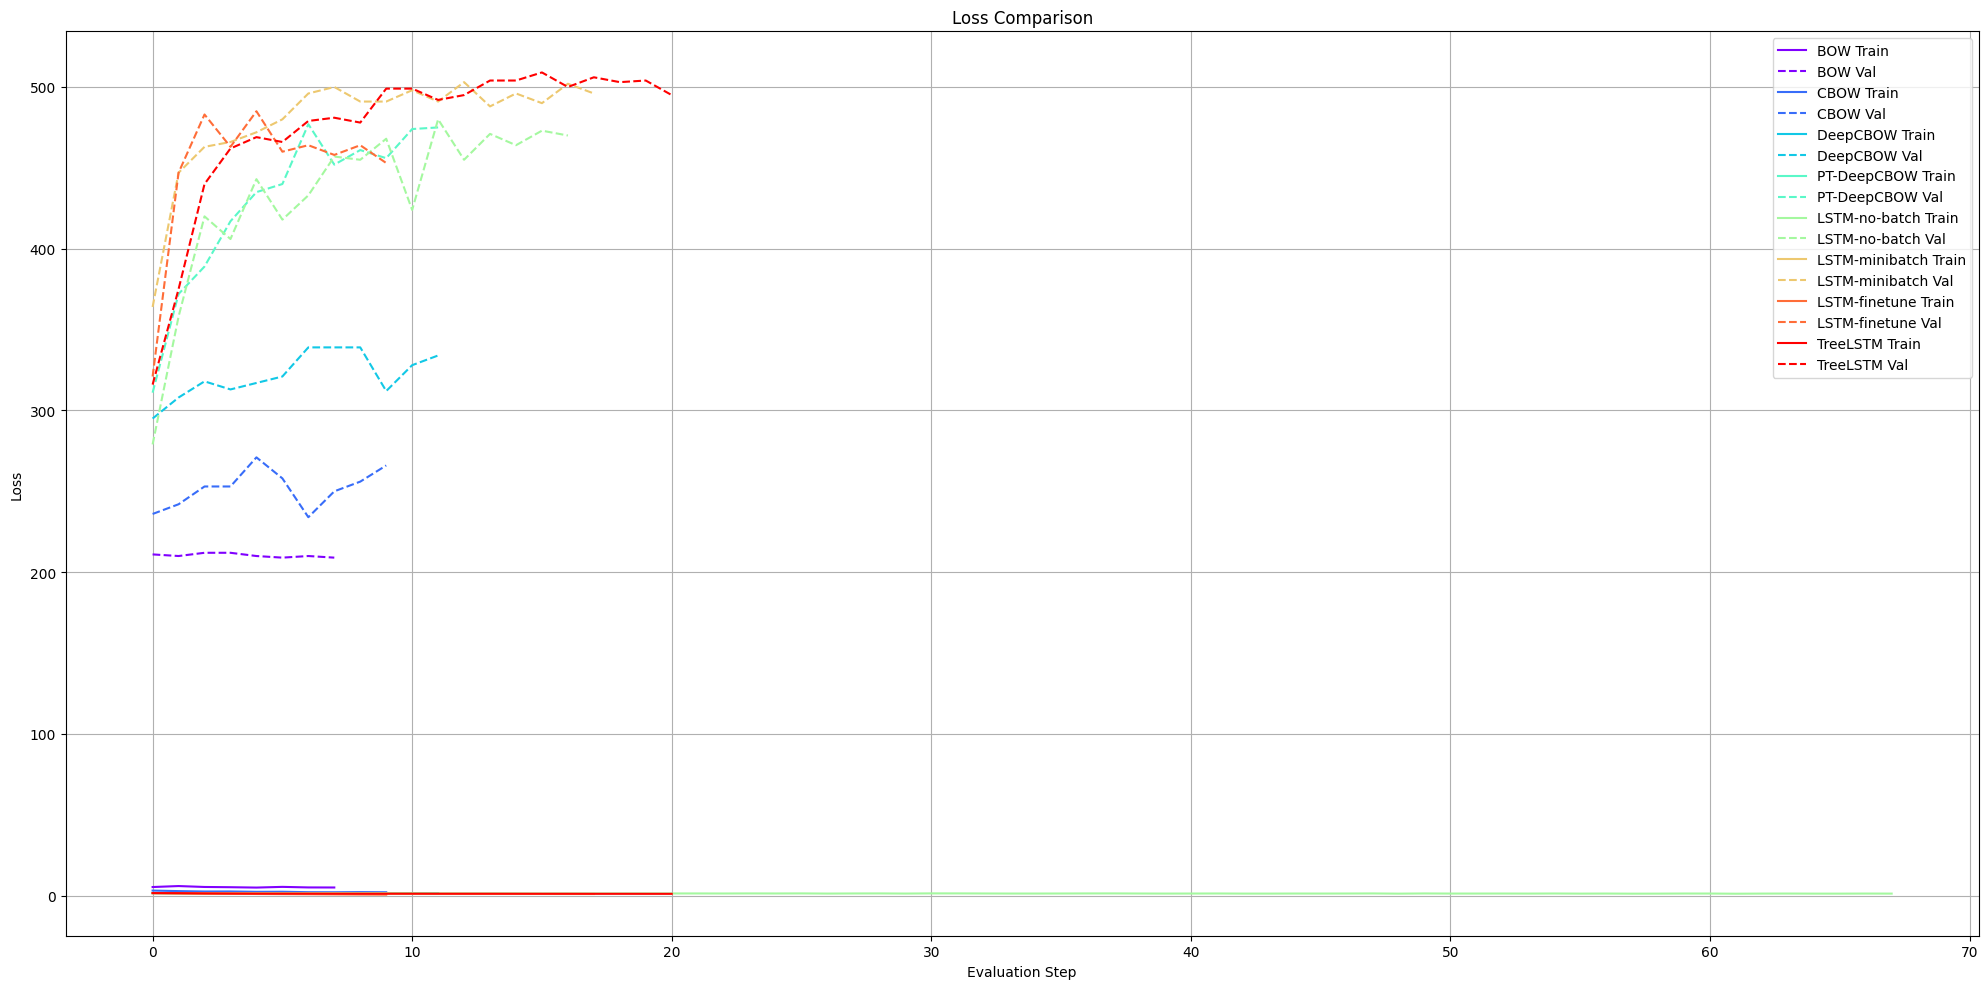

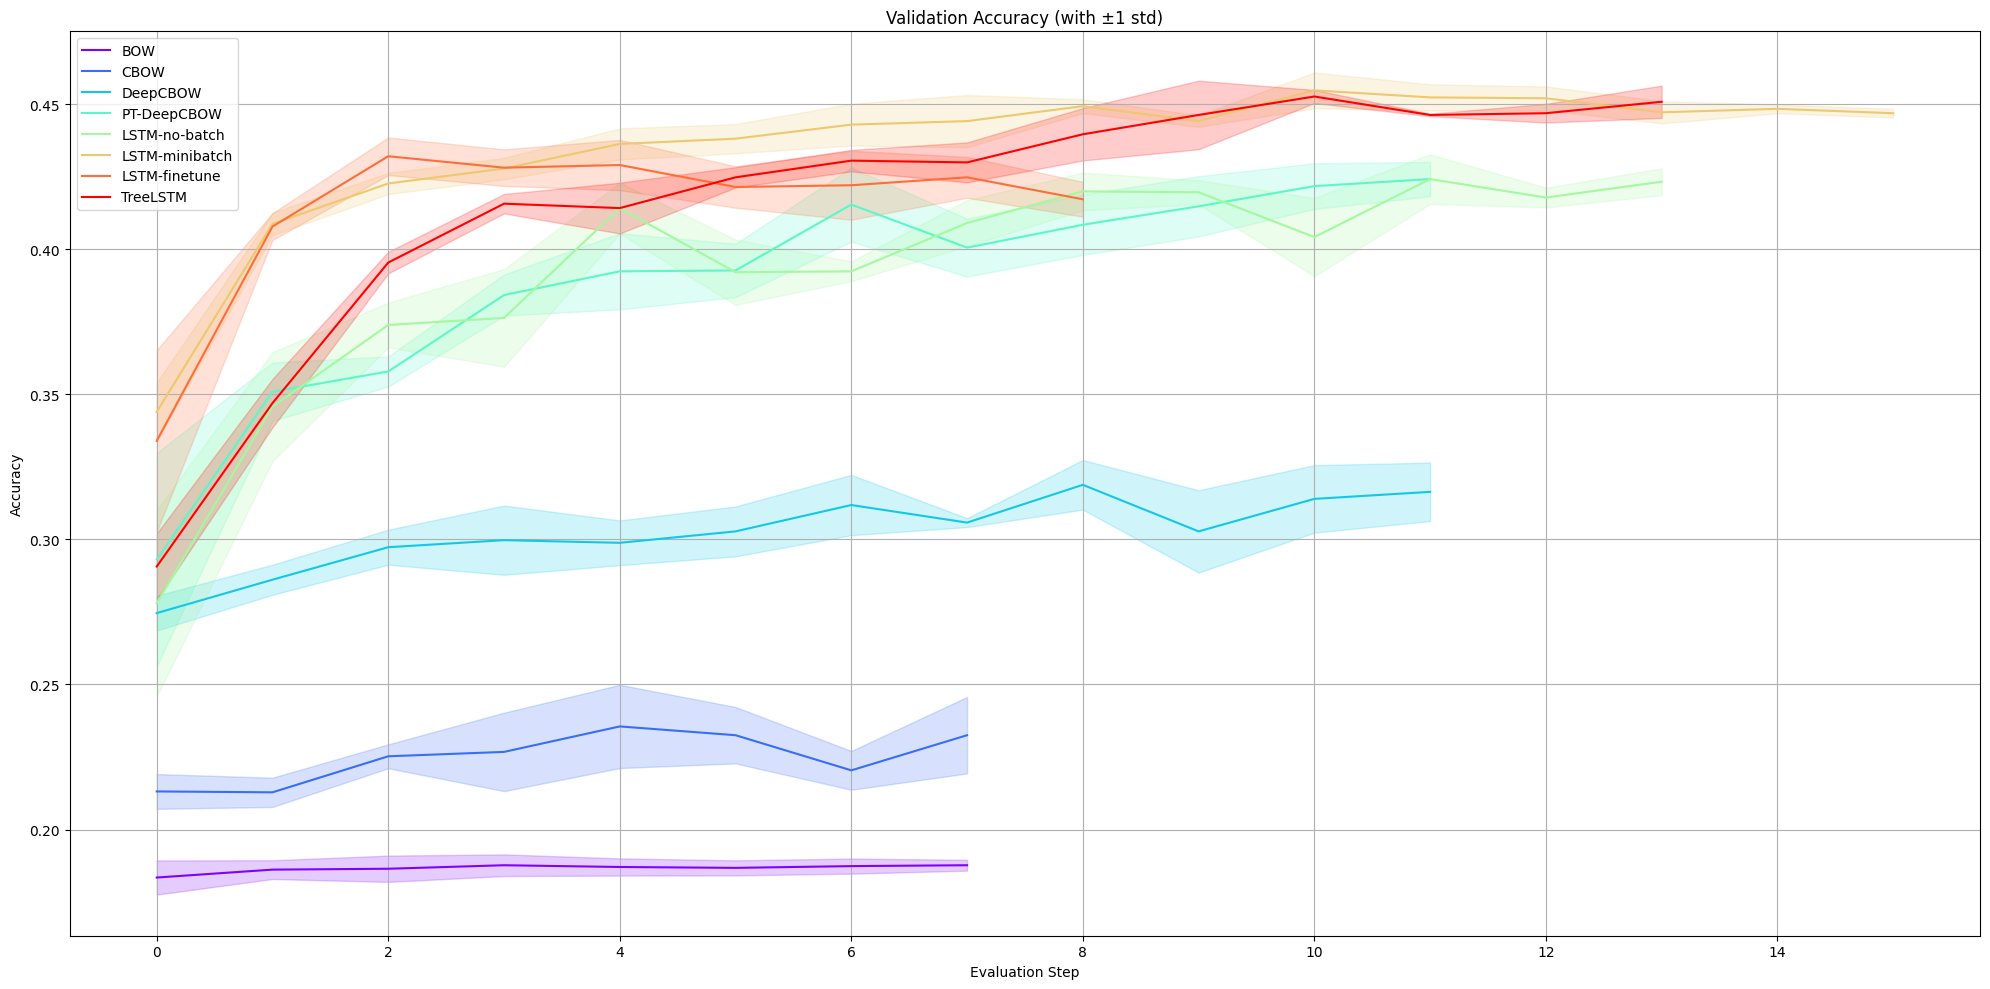

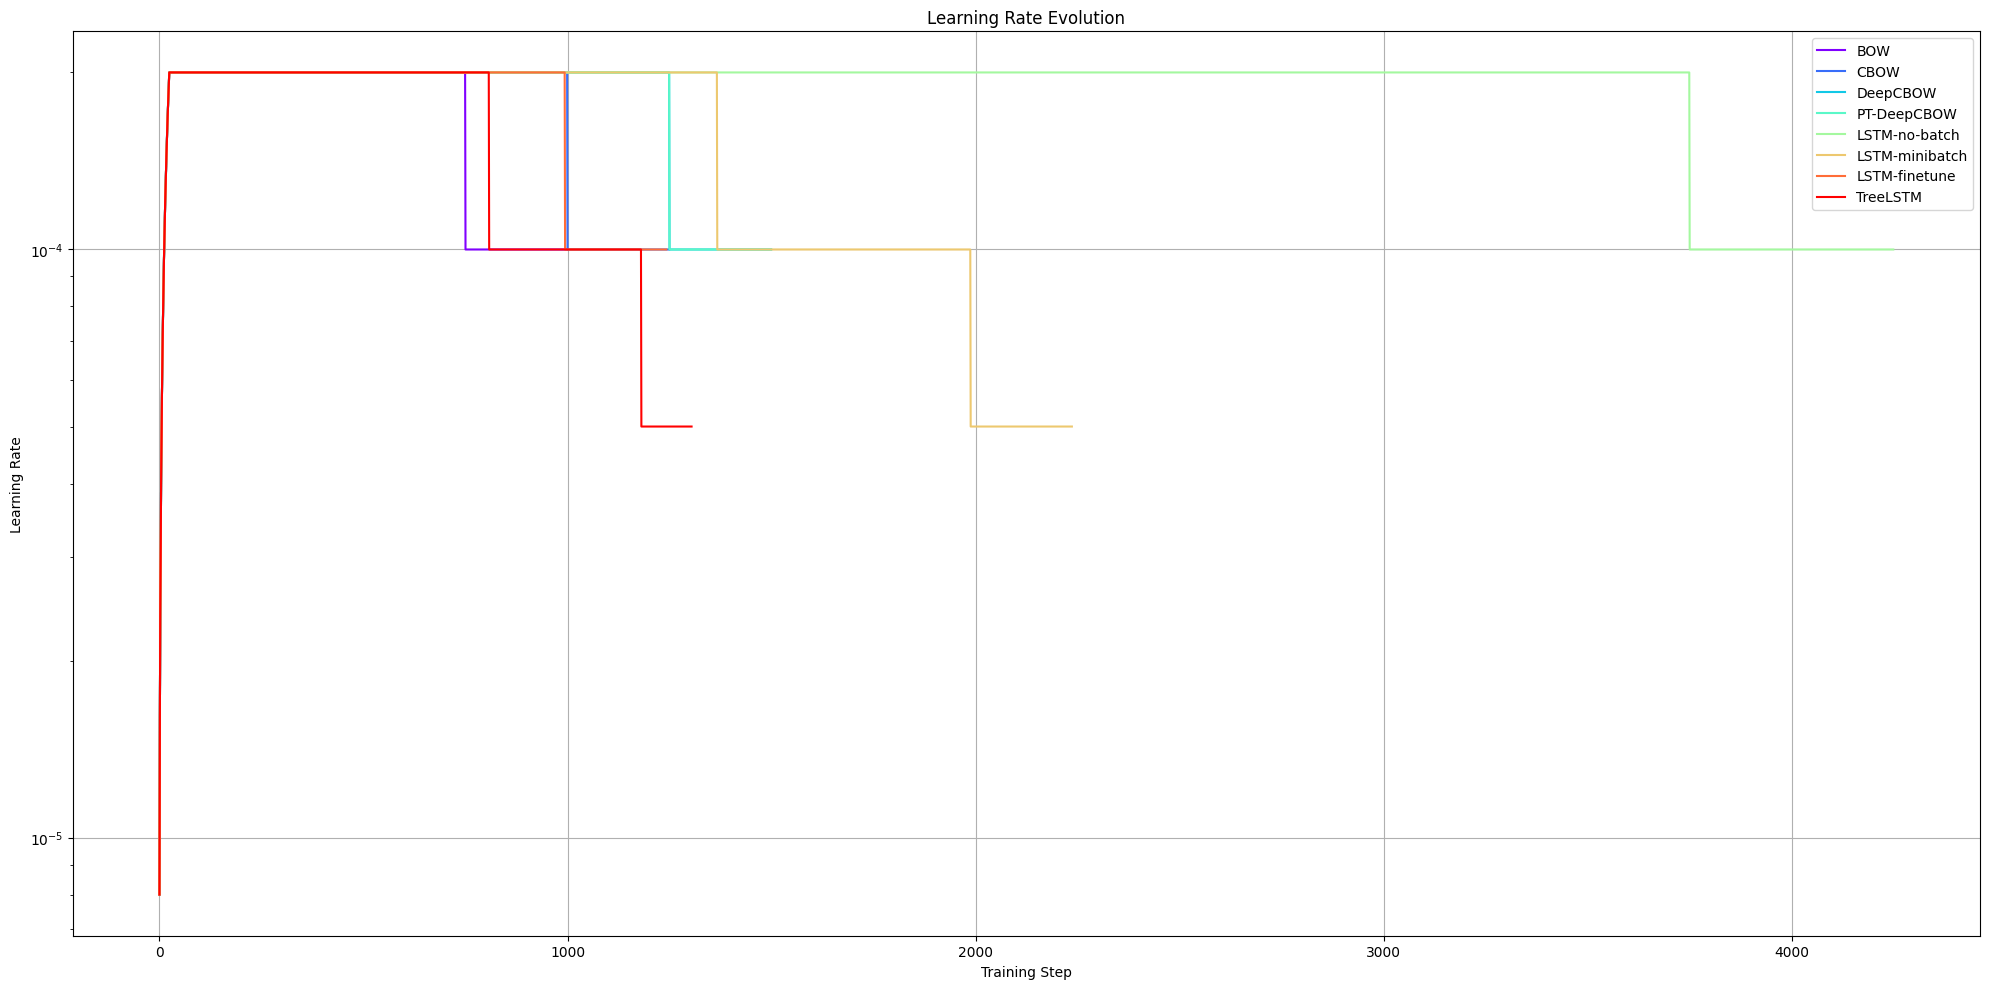

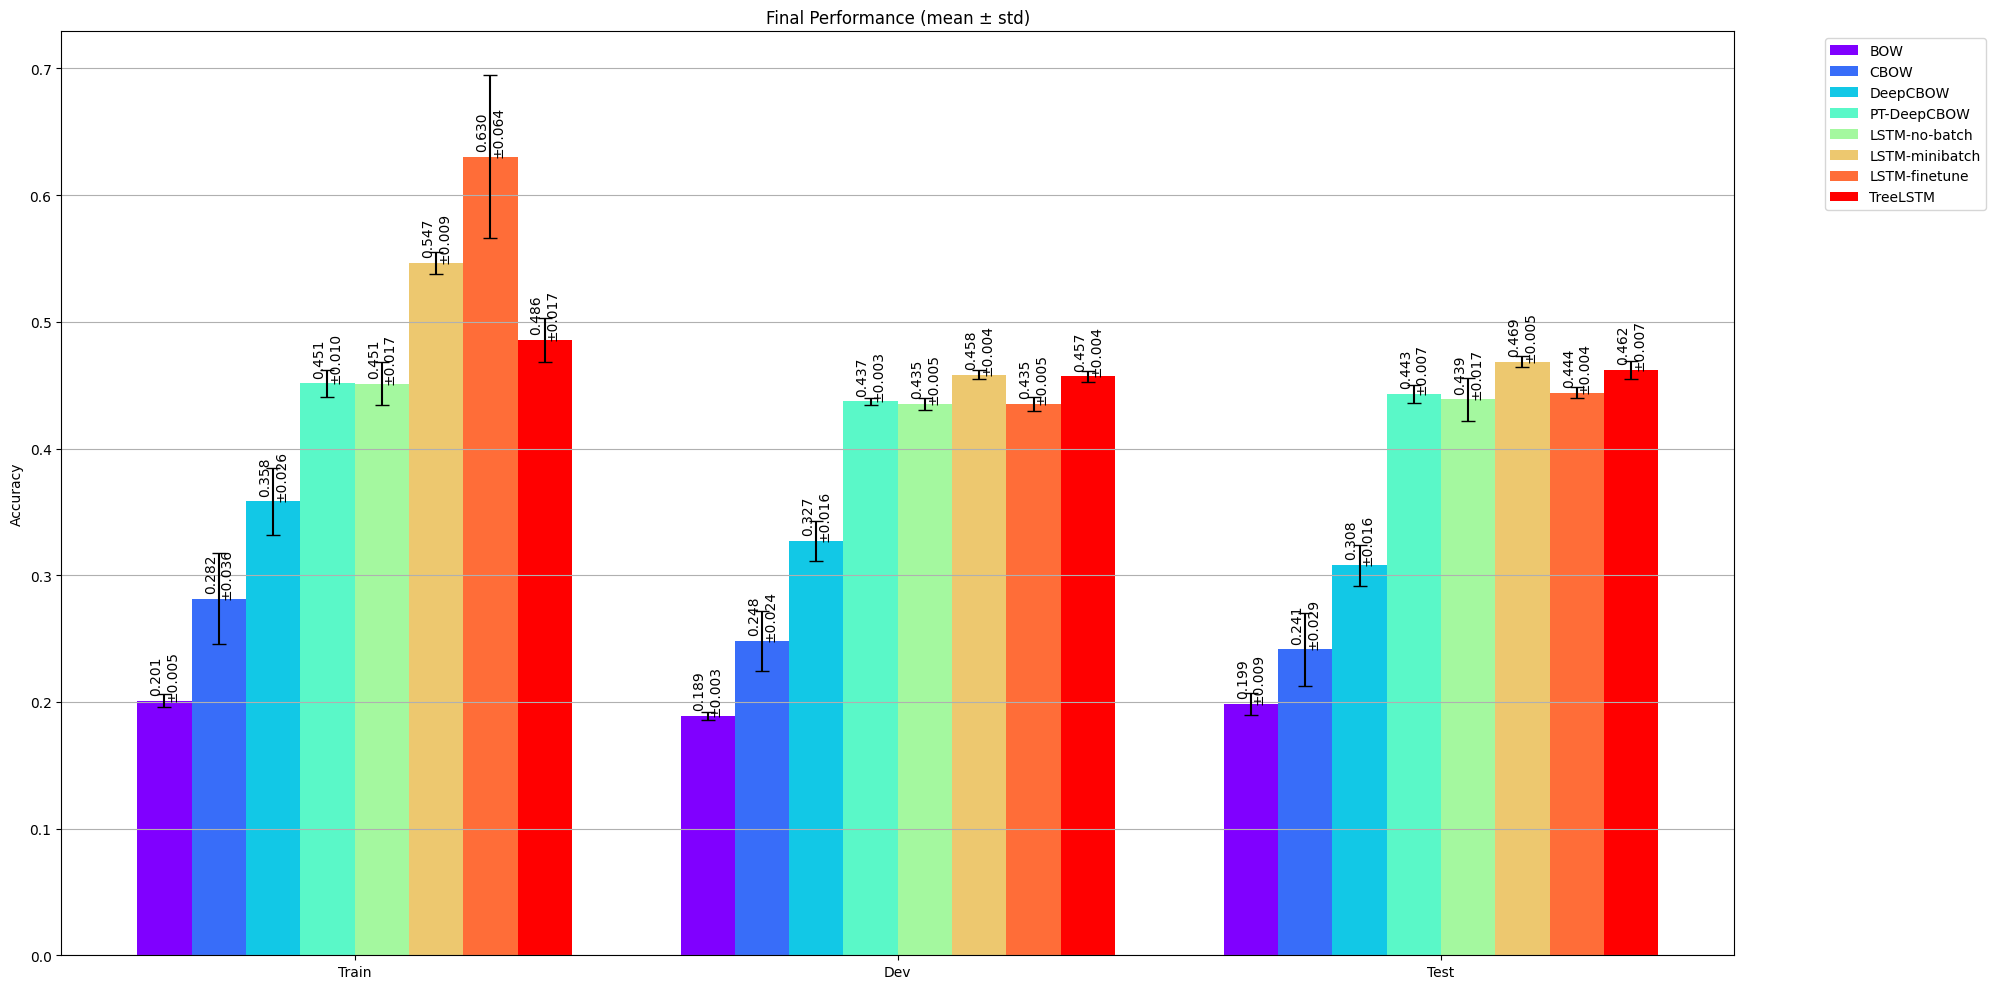

<ipython-input-50-df463904674c>:98: RuntimeWarning: Mean of empty slice
  mean_acc = np.nanmean(all_accs, axis=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


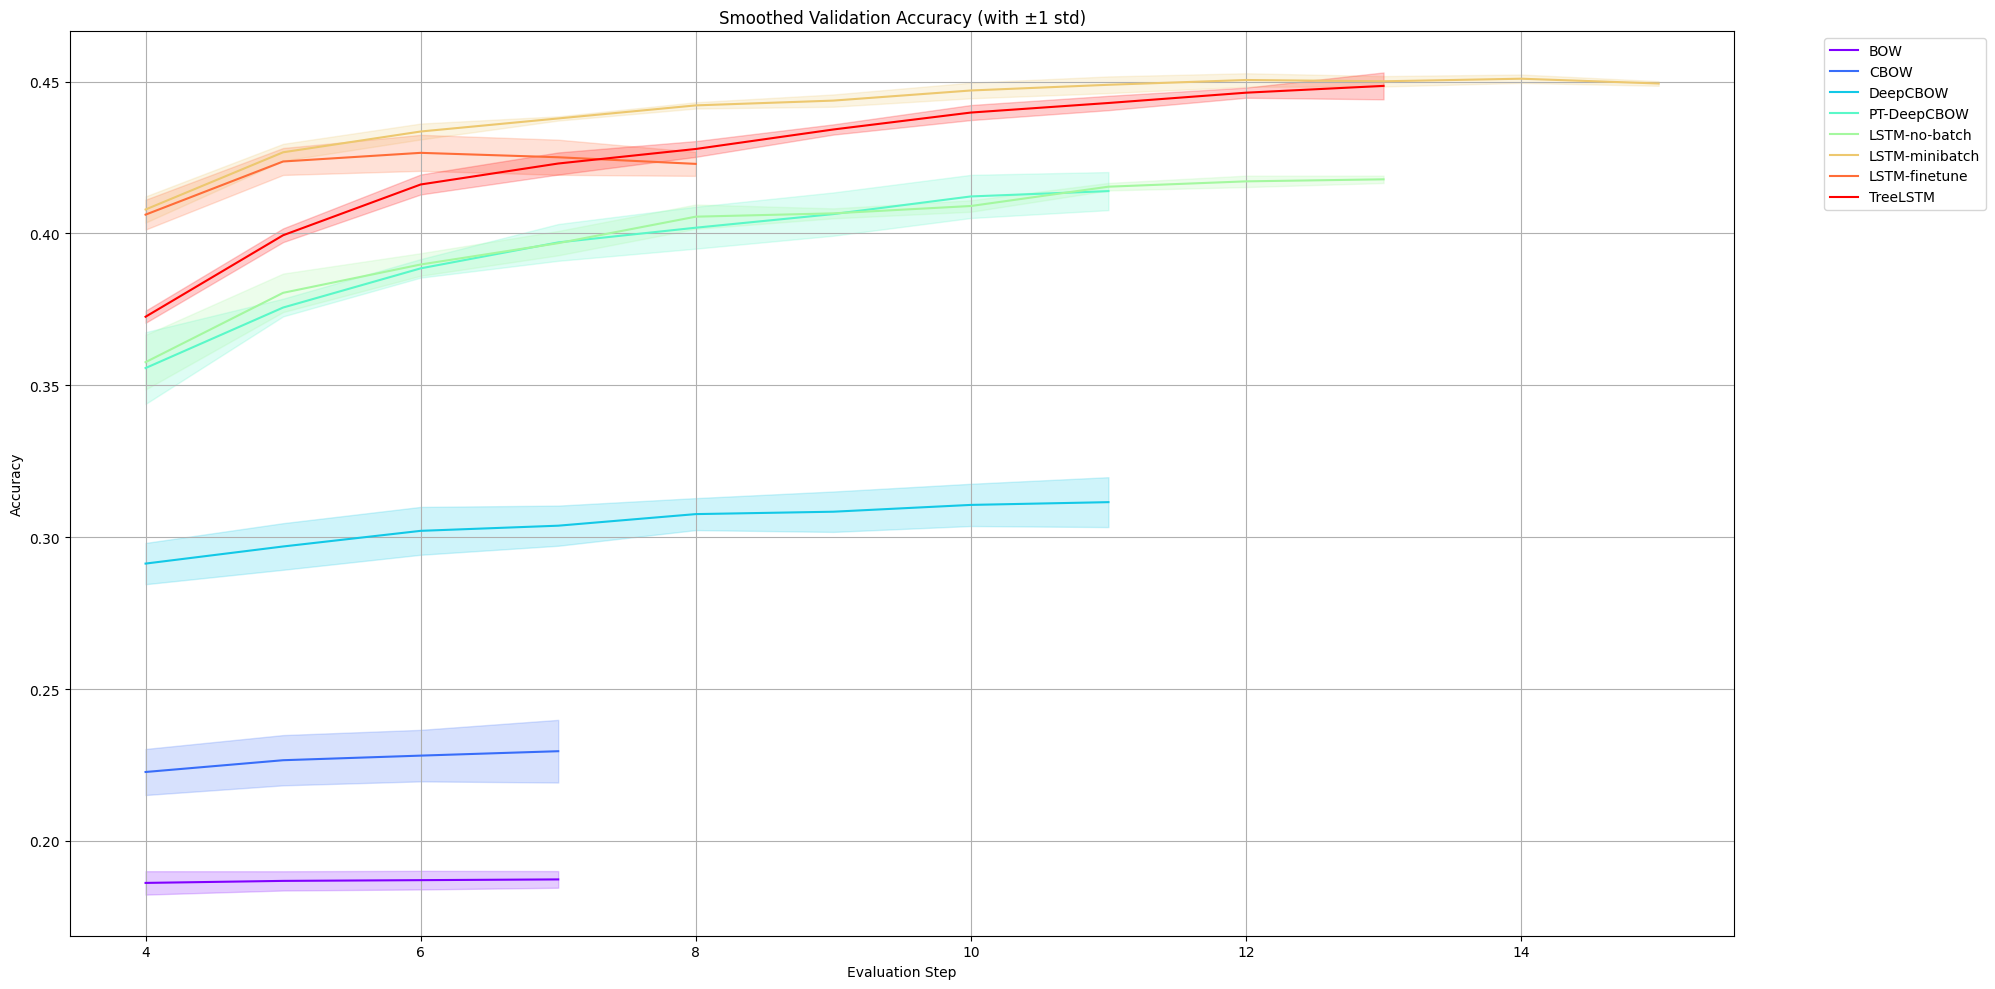


Detailed Model Comparison:

BOW:
Test Accuracy: 0.1986 ± 0.0087
Individual run test accuracies: ['0.2059', '0.1864', '0.2036']

CBOW:
Test Accuracy: 0.2415 ± 0.0288
Individual run test accuracies: ['0.2421', '0.2059', '0.2765']

DeepCBOW:
Test Accuracy: 0.3078 ± 0.0161
Individual run test accuracies: ['0.2919', '0.3018', '0.3299']

PT-DeepCBOW:
Test Accuracy: 0.4431 ± 0.0070
Individual run test accuracies: ['0.4344', '0.4516', '0.4434']

LSTM-no-batch:
Test Accuracy: 0.4388 ± 0.0169
Individual run test accuracies: ['0.4407', '0.4172', '0.4584']

LSTM-minibatch:
Test Accuracy: 0.4686 ± 0.0046
Individual run test accuracies: ['0.4733', '0.4701', '0.4624']

LSTM-finetune:
Test Accuracy: 0.4442 ± 0.0043
Individual run test accuracies: ['0.4452', '0.4489', '0.4385']

TreeLSTM:
Test Accuracy: 0.4620 ± 0.0070
Individual run test accuracies: ['0.4706', '0.4534', '0.4620']


In [86]:
models_comparison = {}

if 'bow_training_stats' in locals():
    models_comparison['BOW'] = bow_training_stats
if 'cbow_training_stats' in locals():
    models_comparison['CBOW'] = cbow_training_stats
if 'deepcbow_training_stats' in locals():
    models_comparison['DeepCBOW'] = deepcbow_training_stats
if 'pt_deep_cbow_training_stats' in locals():
    models_comparison['PT-DeepCBOW'] = pt_deep_cbow_training_stats
if 'lstm_no_batch_training_stats' in locals():
    models_comparison['LSTM-no-batch'] = lstm_no_batch_training_stats
if 'lstm_training_stats' in locals():
    models_comparison['LSTM-minibatch'] = lstm_training_stats
if 'lstm_finetune_training_stats' in locals():
    models_comparison['LSTM-finetune'] = lstm_finetune_training_stats
if 'tree_lstm_training_stats' in locals():
    models_comparison['TreeLSTM'] = tree_lstm_training_stats

print("Available models for comparison:")
for model_name in models_comparison.keys():
    print(f"- {model_name}")

if models_comparison:
    plot_model_comparison(
        training_stats_list=list(models_comparison.values()),
        model_names=list(models_comparison.keys()),
        figsize_single=(20, 10)
    )
else:
    print("No model statistics available for plotting")

In [87]:
# def save_to_gdrive_mounted(local_dir="checkpoints",
#                           gdrive_path="/gdrive/My Drive/experiment_checkpoints"):
#     """Save checkpoints with timestamp to mounted Google Drive"""
#     try:
#         import shutil
#         # Create destination directory
#         os.makedirs(gdrive_path, exist_ok=True)

#         # Create timestamped directory
#         timestamp = time.strftime('%Y%m%d_%H%M%S')
#         dst = os.path.join(gdrive_path, f"checkpoints_{timestamp}")

#         # Copy files
#         shutil.copytree(local_dir, dst)

#         # Also save a summary of what's in each checkpoint
#         summary = []
#         for checkpoint in Path(local_dir).glob("*.pt"):
#             ckpt = torch.load(checkpoint)
#             summary.append({
#                 'filename': checkpoint.name,
#                 'best_eval': ckpt['best_eval'],
#                 'iteration': ckpt['current_iter']
#             })

#         # Save summary
#         with open(os.path.join(dst, 'summary.txt'), 'w') as f:
#             for item in summary:
#                 f.write(f"{item['filename']}: best_eval={item['best_eval']:.4f}, "
#                        f"iter={item['iteration']}\n")

#         print(f"Saved checkpoints and summary to: {dst}")

#     except Exception as e:
#         print(f"Error saving to Google Drive: {str(e)}")

# # Usage:
# save_to_gdrive_mounted()

In [88]:
# from google.colab import drive
# import os
# import torch
# from pathlib import Path
# import shutil

# def load_from_gdrive(gdrive_path="/gdrive/My Drive/experiment_checkpoints",
#                      local_dir="checkpoints"):
#     """Load most recent checkpoints from Google Drive to Colab session"""
#     try:
#         # Mount Google Drive if not already mounted
#         if not os.path.exists('/gdrive'):
#             drive.mount('/gdrive')

#         # Create local directory
#         os.makedirs(local_dir, exist_ok=True)

#         # Find most recent checkpoint directory
#         checkpoint_dirs = [d for d in Path(gdrive_path).glob("checkpoints_*")]
#         if not checkpoint_dirs:
#             raise Exception("No checkpoint directories found")

#         latest_dir = max(checkpoint_dirs, key=os.path.getctime)
#         print(f"Loading checkpoints from: {latest_dir}")

#         # Copy files to local directory
#         for checkpoint in Path(latest_dir).glob("*.pt"):
#             shutil.copy2(checkpoint, local_dir)

#         # Load checkpoints into memory
#         models_comparison = {}
#         name_mapping = {
#             'BOW': 'BOW',
#             'CBOW': 'CBOW',
#             'DeepCBOW': 'DeepCBOW',
#             'PTDeepCBOW': 'PT-DeepCBOW',
#             'LSTMClassifier': 'LSTM-minibatch',
#             'TreeLSTMClassifier': 'TreeLSTM'
#         }

#         # Load best checkpoints for each model
#         for checkpoint_path in Path(local_dir).glob("*_best.pt"):
#             try:
#                 model_name = checkpoint_path.stem.split('_')[0]
#                 if model_name in name_mapping:
#                     ckpt = torch.load(checkpoint_path)
#                     print(f"Loading checkpoint for {name_mapping[model_name]}")
#                     models_comparison[name_mapping[model_name]] = ckpt
#             except Exception as e:
#                 print(f"Error loading {checkpoint_path}: {e}")

#         # Print summary if exists
#         summary_path = os.path.join(latest_dir, 'summary.txt')
#         if os.path.exists(summary_path):
#             print("\nCheckpoint Summary:")
#             with open(summary_path, 'r') as f:
#                 print(f.read())

#         return models_comparison

#     except Exception as e:
#         print(f"Error loading from Google Drive: {str(e)}")
#         return None

# models_comparison = load_from_gdrive()

# if models_comparison:
#     print("\nAvailable models for comparison:")
#     for model_name in models_comparison.keys():
#         print(f"- {model_name}")

#     # Create plots
#     plot_model_comparison(
#         training_stats_list=list(models_comparison.values()),
#         model_names=list(models_comparison.keys()),
#         figsize_single=(20, 10)
#     )
# else:
#     print("No model statistics available for plotting")

# Further experiments and report

For your report, you are expected to answer research questions by doing further experiments.

## Research Questions

Make sure you cover at least the following:

- How important is word order for this task?
- Does the tree structure help to get a better accuracy?
- How does performance depend on the sentence length? Compare the various models. Is there a model that does better on longer sentences? If so, why?
- Do you get better performance if you supervise the sentiment **at each node in the tree**? You can extract more training examples by treating every node in each tree as a separate tree. You will need to write a function that extracts all subtrees given a treestring.
    - Warning: NLTK's Tree function seems to result in invalid trees in some cases, so be careful if you want to parse the string to a tree structure before extraction the phrases.

**To be able to obtain a full grade (10), you should conduct further investigations.** For example, you can also investigate one the following:

- When making a wrong prediction, can you figure out at what point in the tree (sentence) the model fails? You can make a prediction at each node to investigate.
- How does N-ary Tree LSTM compare to the Child-Sum Tree LSTM?
- How do the Tai et al. Tree LSTMs compare to Le & Zuidema's formulation?
- Or... your own research question!

These examples should give you an idea of the expected scope of your further investigations. The maximum number of points awarded for these further investigations depends on the depth of your analysis, and can also be awarded for one of the further research questions already listed above.

In general:

- ***When you report numbers, please report the mean accuracy across 3 (or more) runs with different random seed, together with the standard deviation.*** This is because the final performance may vary per random seed.
More precisely, you should run each model with 3 different seeds, and for each of these 3 runs, evaluate the best model (according to the validation) on the test dataset. The validation dataset is used for finding the best model over iterations, but the accuracy you report should be on the test dataset.

## Report instructions

Your report needs to be written in LaTeX. You are required to use the ACL 2023 template which you can download from or edit directly on [Overleaf](https://www.overleaf.com/latex/templates/acl-2023-proceedings-template/qjdgcrdwcnwp). Make sure your names and student numbers are visible at the top. (Tip: you need to uncomment `\aclfinalcopy`).
You can find some general tips about writing a research paper [here](https://www.microsoft.com/en-us/research/academic-program/write-great-research-paper/), but note that you need to make your own judgment about what is appropriate for this project.

We expect you to use the following structure:
1. Introduction (~1 page) - describe the problem, your research questions and goals, a summary of your findings and contributions. Please cite related work (models, data set) as part of your introduction here, since this is a short paper.
    - Introduce the task and the main goal
    - Present your research questions
    - Motivate the importance of the questions
    - Present and explain your expectations
    - Make clear whether the research questions are addressed or not addressed in the literature
    - Describe the approach you use to answer the research questions
    - Summarise your findings
2. Background (~1/2-1 page) -
cover the main techniques ("building blocks") used in your project (e.g. word embeddings, LSTM, Tree-LSTM) and intuitions behind them. Be accurate and concise.
    - How does each technique work? (Don't just copy the formulas)
    - What is the relation between the techniques?
3. Models (~1/2 page) - Describe the architecture of the final models.
    - How do you use LSTM or Tree-LSTM for the sentiment classification task?
    - What layers do you have, how do you do classification?
    - What is your loss function?
    - Etc.
4. Experiments (~1/2 page) - Describe your experimental setup. This section should allow someone else to reproduce your experiments. Describe how you evaluate the models.
    - Task and the data
    - Training (model, data, parameters and hyper parameters, training algorithms, supervision signals, etc.)
    - Evaluation (e.g. metrics)
5. Results and Analysis (~1 page). Present the results and analyse your findings.
    - Answer each of the research questions you raised in the introduction.
    - Use figures and tables to highlight interesting patterns
    - What are the factors that make model A better than model B in task C? Investigate to prove their effect!
6. Conclusion (~1/4 page). Present the conclusions that can be drawn from your experiments.
    - What have you learned from you experiments?
    - How do your findings relate to what is already known in the literature?
    - Were the results as expected? Any surprising results? Why?
    - Based on what you learned, what would you suggest doing next?


General Tips:

- Math notation – define each variable (either in running text, or in a pseudo-legenda after or before the equation).
- Define technical terminology you need.
- Avoid colloquial language – everything can be said in a scientific-sounding way.
- Avoid lengthy sentences, stay to the point.
- Do not spend space on "obvious" things.
- Do not go over the page limit. (We will deduct points for that.)
- The page limit is 4 pages excluding references and appendix. This is a strict limit; points will be deducted for longer reports.
- There is no strict limit to references and appendix. However, the report needs to remain fully self-contained: the appendix should only include content that is not necessary to understand your work. For example, preprocessing decisions, model parameters, pseudocode, sample system inputs/outputs, and other details that are necessary for the exact replication of your work can be put into the appendix.


An ideal report:
- Precise, scientific, technical, to the point
  - Little general “waffle”/chit-chat
- Not boring – because you don’t explain obvious things too much
- Efficient delivery of (only) the facts that we need to know to understand/reimplement
- Results visually well-presented and described with the correct priority of importance of sub-results
- Insightful analysis – speculation should connect to something interesting and not be too much; the reader “learns something new”
- No typos, no colloquialisms – well-considered language
- This normally means several re-draftings (re-orderings of information)
